In [34]:
import requests
import json
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sqlite3

plt.rcParams['figure.dpi'] = 600

In [2]:
headers = {'User-Agent':'User-Agent'}
r = requests.request(url='https://api.pathofexile.com/ladders/Sentinel?offset=400', headers = headers, method='get')
r

<Response [200]>

The PoE API can only access 200 characters at a time, only saving the top 15000 characters by experience. This API request is to pull every 200 characters up to 15000. It is important to note that any data or conclusions drawn isnt indicative of the playerbase as a whole, but rather those who have the highest level, introducing a bias.

It is important to note that this ladder is looking after 5 weeks of league data. Each league is approximately 3 months long, after which progress gets reset. 

In [3]:
result = r.json()
offset = []
for i in range(0,14801,200):
    offset.append(i)

In [4]:
sc = []
for i in offset:
    r = requests.request(url='https://api.pathofexile.com/ladders/Sentinel?limit=200&offset='+str(i), headers = headers, method='get')
    results = r.json()
    sc.extend(results['entries'])
    time.sleep(2)

In [5]:
scssf = []
for i in offset:
    r = requests.request(url='https://api.pathofexile.com/ladders/SSF%20Sentinel?limit=200&offset='+str(i), headers = headers, method='get')
    results = r.json()
    scssf.extend(results['entries'])
    time.sleep(2)

In [6]:
hc = []
for i in offset:
    r = requests.request(url='https://api.pathofexile.com/ladders/Hardcore%20Sentinel?limit=200&offset='+str(i), headers = headers, method='get')
    results = r.json()
    hc.extend(results['entries'])
    time.sleep(2)

In [7]:
hcssf = []
for i in offset:
    r = requests.request(url='https://api.pathofexile.com/ladders/SSF%20Sentinel%20HC?limit=200&offset='+str(i), headers = headers, method='get')
    results = r.json()
    hcssf.extend(results['entries'])
    time.sleep(2)

In [8]:
sentinel_sc = pd.json_normalize(sc)
sentinel_scssf = pd.json_normalize(scssf)
sentinel_hc = pd.json_normalize(hc)
sentinel_hcssf = pd.json_normalize(hcssf)

Note that SC and HC have similar columns, SCSSF 1 more column and HCSSF has a lot more columns than the rest.

In [9]:
print(sentinel_sc.shape)
print(sentinel_scssf.shape)
print(sentinel_hc.shape)
print(sentinel_hcssf.shape)

(15000, 17)
(15000, 18)
(15000, 17)
(15000, 28)


It's likely that SC trade and HC trade are structured similarly, SCSSF has an extra column and HCSSF has many columns. Let's standardize

In [10]:
[i for i in sentinel_hcssf.columns if i not in sentinel_scssf.columns]

['character.time',
 'character.score',
 'character.progress.UberEaterDefeated',
 'character.progress.UberExarchDefeated',
 'character.progress.UberMavenDefeated',
 'character.progress.UberSirusDefeated',
 'character.progress.UberVenariusDefeated',
 'character.progress.UberUberElderDefeated',
 'character.progress.UberShaperDefeated',
 'account.staff']

In [11]:
[i for i in sentinel_scssf.columns if i not in sentinel_sc.columns]

['retired']

In [12]:
difference = [i for i in sentinel_hcssf.columns if i not in sentinel_hc.columns]
display(difference)
difference.remove('retired')

['character.time',
 'character.score',
 'character.progress.UberEaterDefeated',
 'character.progress.UberExarchDefeated',
 'character.progress.UberMavenDefeated',
 'character.progress.UberSirusDefeated',
 'character.progress.UberVenariusDefeated',
 'character.progress.UberUberElderDefeated',
 'character.progress.UberShaperDefeated',
 'retired',
 'account.staff']

Retired appears in only SSF leagues. HCSSF league has a lot more extra columns, related to the official league start race. Other leagues do not have this information. I will drop them.

In [13]:
sentinel_hcssf = sentinel_hcssf.drop(difference,axis=1)

In [14]:
sentinel_hc['retired'] = 'Cannot migrate'
sentinel_sc['retired'] = 'Cannot migrate'

In [15]:
print(sentinel_sc.shape)
print(sentinel_scssf.shape)
print(sentinel_hc.shape)
print(sentinel_hcssf.shape)

(15000, 18)
(15000, 18)
(15000, 18)
(15000, 18)


In [16]:
sentinel_sc.head()

sentinel_sc = sentinel_sc.drop(['character.id','account.realm','account.twitch.stream.status',
                                            'account.twitch.stream.image','account.twitch.stream.name',
                                            'account.twitch.name'],axis=1)
sentinel_scssf = sentinel_scssf.drop(['character.id','account.realm','account.twitch.stream.status',
                                            'account.twitch.stream.image','account.twitch.stream.name',
                                            'account.twitch.name'],axis=1)
sentinel_hc = sentinel_hc.drop(['character.id','account.realm','account.twitch.stream.status',
                                            'account.twitch.stream.image','account.twitch.stream.name',
                                            'account.twitch.name'],axis=1)
sentinel_hcssf = sentinel_hcssf.drop(['character.id','account.realm','account.twitch.stream.status',
                                            'account.twitch.stream.image','account.twitch.stream.name',
                                            'account.twitch.name'],axis=1)

In [17]:
sentinel_sc.head()

,rank,dead,character.name,character.level,character.class,character.experience,character.depth.default,character.depth.solo,account.name,account.challenges.total,public,retired
0,1,False,Misha_ReallyHard,100,Ascendant,4250334444,1491.0,1491.0,Mikle,24,NaN,Cannot migrate
1,2,False,VlaDick_ReallyHard,100,Assassin,4250334444,NaN,NaN,Gachimuchi_Eternal,9,NaN,Cannot migrate
2,3,False,Quiet_ReallyHard,100,Guardian,4250334444,NaN,NaN,quiet1205,7,NaN,Cannot migrate
3,4,False,Nikita_ReallyHard,100,Deadeye,4250334444,NaN,NaN,FoolTank,12,NaN,Cannot migrate
4,5,False,melancholari_ReallyHard,100,Occultist,4250334444,NaN,NaN,ЖИРУХА_ВИТИ,7,NaN,Cannot migrate


In [18]:
sentinel_sc['character.depth.default'] = sentinel_sc['character.depth.default'].fillna(0)
sentinel_sc['character.depth.solo'] = sentinel_sc['character.depth.solo'].fillna(0)
sentinel_scssf['character.depth.default'] = sentinel_scssf['character.depth.default'].fillna(0)
sentinel_scssf['character.depth.solo'] = sentinel_scssf['character.depth.solo'].fillna(0)
sentinel_hc['character.depth.default'] = sentinel_hc['character.depth.default'].fillna(0)
sentinel_hc['character.depth.solo'] = sentinel_hc['character.depth.solo'].fillna(0)
sentinel_hcssf['character.depth.default'] = sentinel_hcssf['character.depth.default'].fillna(0)
sentinel_hcssf['character.depth.solo'] = sentinel_hcssf['character.depth.solo'].fillna(0)

In [19]:
sentinel_sc['public'] = sentinel_sc['public'].replace(True,'public')
sentinel_scssf['public'] = sentinel_scssf['public'].replace(True,'public')
sentinel_hc['public'] = sentinel_hc['public'].replace(True,'public')
sentinel_hcssf['public'] = sentinel_hcssf['public'].replace(True,'public')

In [20]:
sentinel_sc['public'] = sentinel_sc['public'].fillna('private')
sentinel_scssf['public'] = sentinel_scssf['public'].fillna('private')
sentinel_hc['public'] = sentinel_hc['public'].fillna('private')
sentinel_hcssf['public'] = sentinel_hcssf['public'].fillna('private')

In [21]:
sentinel_sc['retired'] = sentinel_sc['retired'].fillna(False)
sentinel_scssf['retired'] = sentinel_scssf['retired'].fillna(False)
sentinel_hc['retired'] = sentinel_hc['retired'].fillna(False)
sentinel_hcssf['retired'] = sentinel_hcssf['retired'].fillna(False)

In [22]:
sentinel_sc = sentinel_sc.reindex(sorted(sentinel_sc.columns), axis=1)
sentinel_scssf = sentinel_scssf.reindex(sorted(sentinel_scssf.columns), axis=1)
sentinel_hc = sentinel_hc.reindex(sorted(sentinel_hc.columns), axis=1)
sentinel_hcssf = sentinel_hcssf.reindex(sorted(sentinel_hcssf.columns), axis=1)


In [23]:
[print(i) for i in sentinel_sc.columns]

account.challenges.total
account.name
character.class
character.depth.default
character.depth.solo
character.experience
character.level
character.name
dead
public
rank
retired


[None, None, None, None, None, None, None, None, None, None, None, None]

Above are the categories we are working with. Let's rename them for clarity.

In [24]:
sentinel_sc.columns = ['challenges', 'account_name', 'ascendancy', 'league_depth', 'solo_depth', 'experience',
                             'level','character_name', 'dead', 'profile', 'rank', 'migrated']
sentinel_sc = sentinel_sc[['rank', 'level', 'ascendancy', 'character_name', 'account_name', 'experience', 'challenges',
                                      'league_depth', 'solo_depth', 'dead', 'migrated', 'profile']]

sentinel_scssf.columns = ['challenges', 'account_name', 'ascendancy', 'league_depth', 'solo_depth', 'experience',
                             'level','character_name', 'dead', 'profile', 'rank', 'migrated']
sentinel_scssf = sentinel_scssf[['rank', 'level', 'ascendancy', 'character_name', 'account_name', 'experience', 'challenges',
                                      'league_depth', 'solo_depth', 'dead', 'migrated', 'profile']]

sentinel_hc.columns = ['challenges', 'account_name', 'ascendancy', 'league_depth', 'solo_depth', 'experience',
                             'level','character_name', 'dead', 'profile', 'rank', 'migrated']
sentinel_hc = sentinel_hc[['rank', 'level', 'ascendancy', 'character_name', 'account_name', 'experience', 'challenges',
                                      'league_depth', 'solo_depth', 'dead', 'migrated', 'profile']]

sentinel_hcssf.columns = ['challenges', 'account_name', 'ascendancy', 'league_depth', 'solo_depth', 'experience',
                             'level','character_name', 'dead', 'profile', 'rank', 'migrated']
sentinel_hcssf = sentinel_hcssf[['rank', 'level', 'ascendancy', 'character_name', 'account_name', 'experience', 'challenges',
                                      'league_depth', 'solo_depth', 'dead', 'migrated', 'profile']]

In [25]:
sentinel_sc.to_csv('Sentinel SC Trade League Info.csv')
sentinel_scssf.to_csv('Sentinel SCSSF League Info.csv')
sentinel_hc.to_csv('Sentinel HC Trade League Info.csv')
sentinel_hcssf.to_csv('Sentinel HCSSF League Info.csv')

In [2]:
sentinel_sc = pd.read_csv(r"C:\Users\rripa\Desktop\Sentinel SC Trade League Info.csv",index_col=0)
sentinel_scssf = pd.read_csv(r"C:\Users\rripa\Desktop\Sentinel SCSSF League Info.csv",index_col=0)
sentinel_hc = pd.read_csv(r"C:\Users\rripa\Desktop\Sentinel HC Trade League Info.csv",index_col=0)
sentinel_hcssf = pd.read_csv(r"C:\Users\rripa\Desktop\Sentinel HCSSF League Info.csv",index_col=0)

sentinel_hcssf

,rank,level,ascendancy,character_name,account_name,experience,challenges,league_depth,solo_depth,dead,migrated,profile
0,1,100,Champion,Ben_BoneshatterBossing,Darkee,4250334444,40,975.0,975.0,True,False,public
1,2,70,Slayer,whyarekillsaccountwide,nickexile11,364603961,14,0.0,0.0,False,True,private
2,3,99,Champion,ZizaranSplosion,Zizaran,3968537052,20,78.0,78.0,True,False,public
3,4,70,Slayer,GucciBoneZoneSupremacy,GucciPradas,365053954,20,0.0,0.0,False,True,public
4,5,99,Saboteur,Jung_Heist_DocArrive,Jezie,4126478364,13,0.0,0.0,True,False,public
...,...,...,...,...,...,...,...,...,...,...,...,...
14995,14996,71,Elementalist,도도도도도도도돋,ddolrang22,428166730,3,0.0,0.0,True,False,public
14996,14997,71,Occultist,BBC_of_peace,gg2tnt,428136748,5,0.0,0.0,True,False,public
14997,14998,71,Ascendant,fuyukara,MagicalGirlPrime,428095524,4,0.0,0.0,False,False,private
14998,14999,71,Inquisitor,Sucalot,Vepa,428069438,6,0.0,0.0,False,False,public


All league API calls now should have this dataframe structure. While I can now use Pandas to filter and select data, I want to display the SQL I have learned. 

This first requires me to learn how to interact with SQL in python. After that, the select statements should be simple conditional filtering.

In [3]:
conn = sqlite3.connect("Sentinel.db")

sentinel_sc.to_sql('SC', conn)
sentinel_scssf.to_sql('SCSSF', conn)
sentinel_hc.to_sql('HC', conn)
sentinel_hcssf.to_sql('HCSSF',conn)

15000

### Data Questions:

What percentage of the ladder migrated to SSFSC to SC Trade? SSFHC and HC Trade?

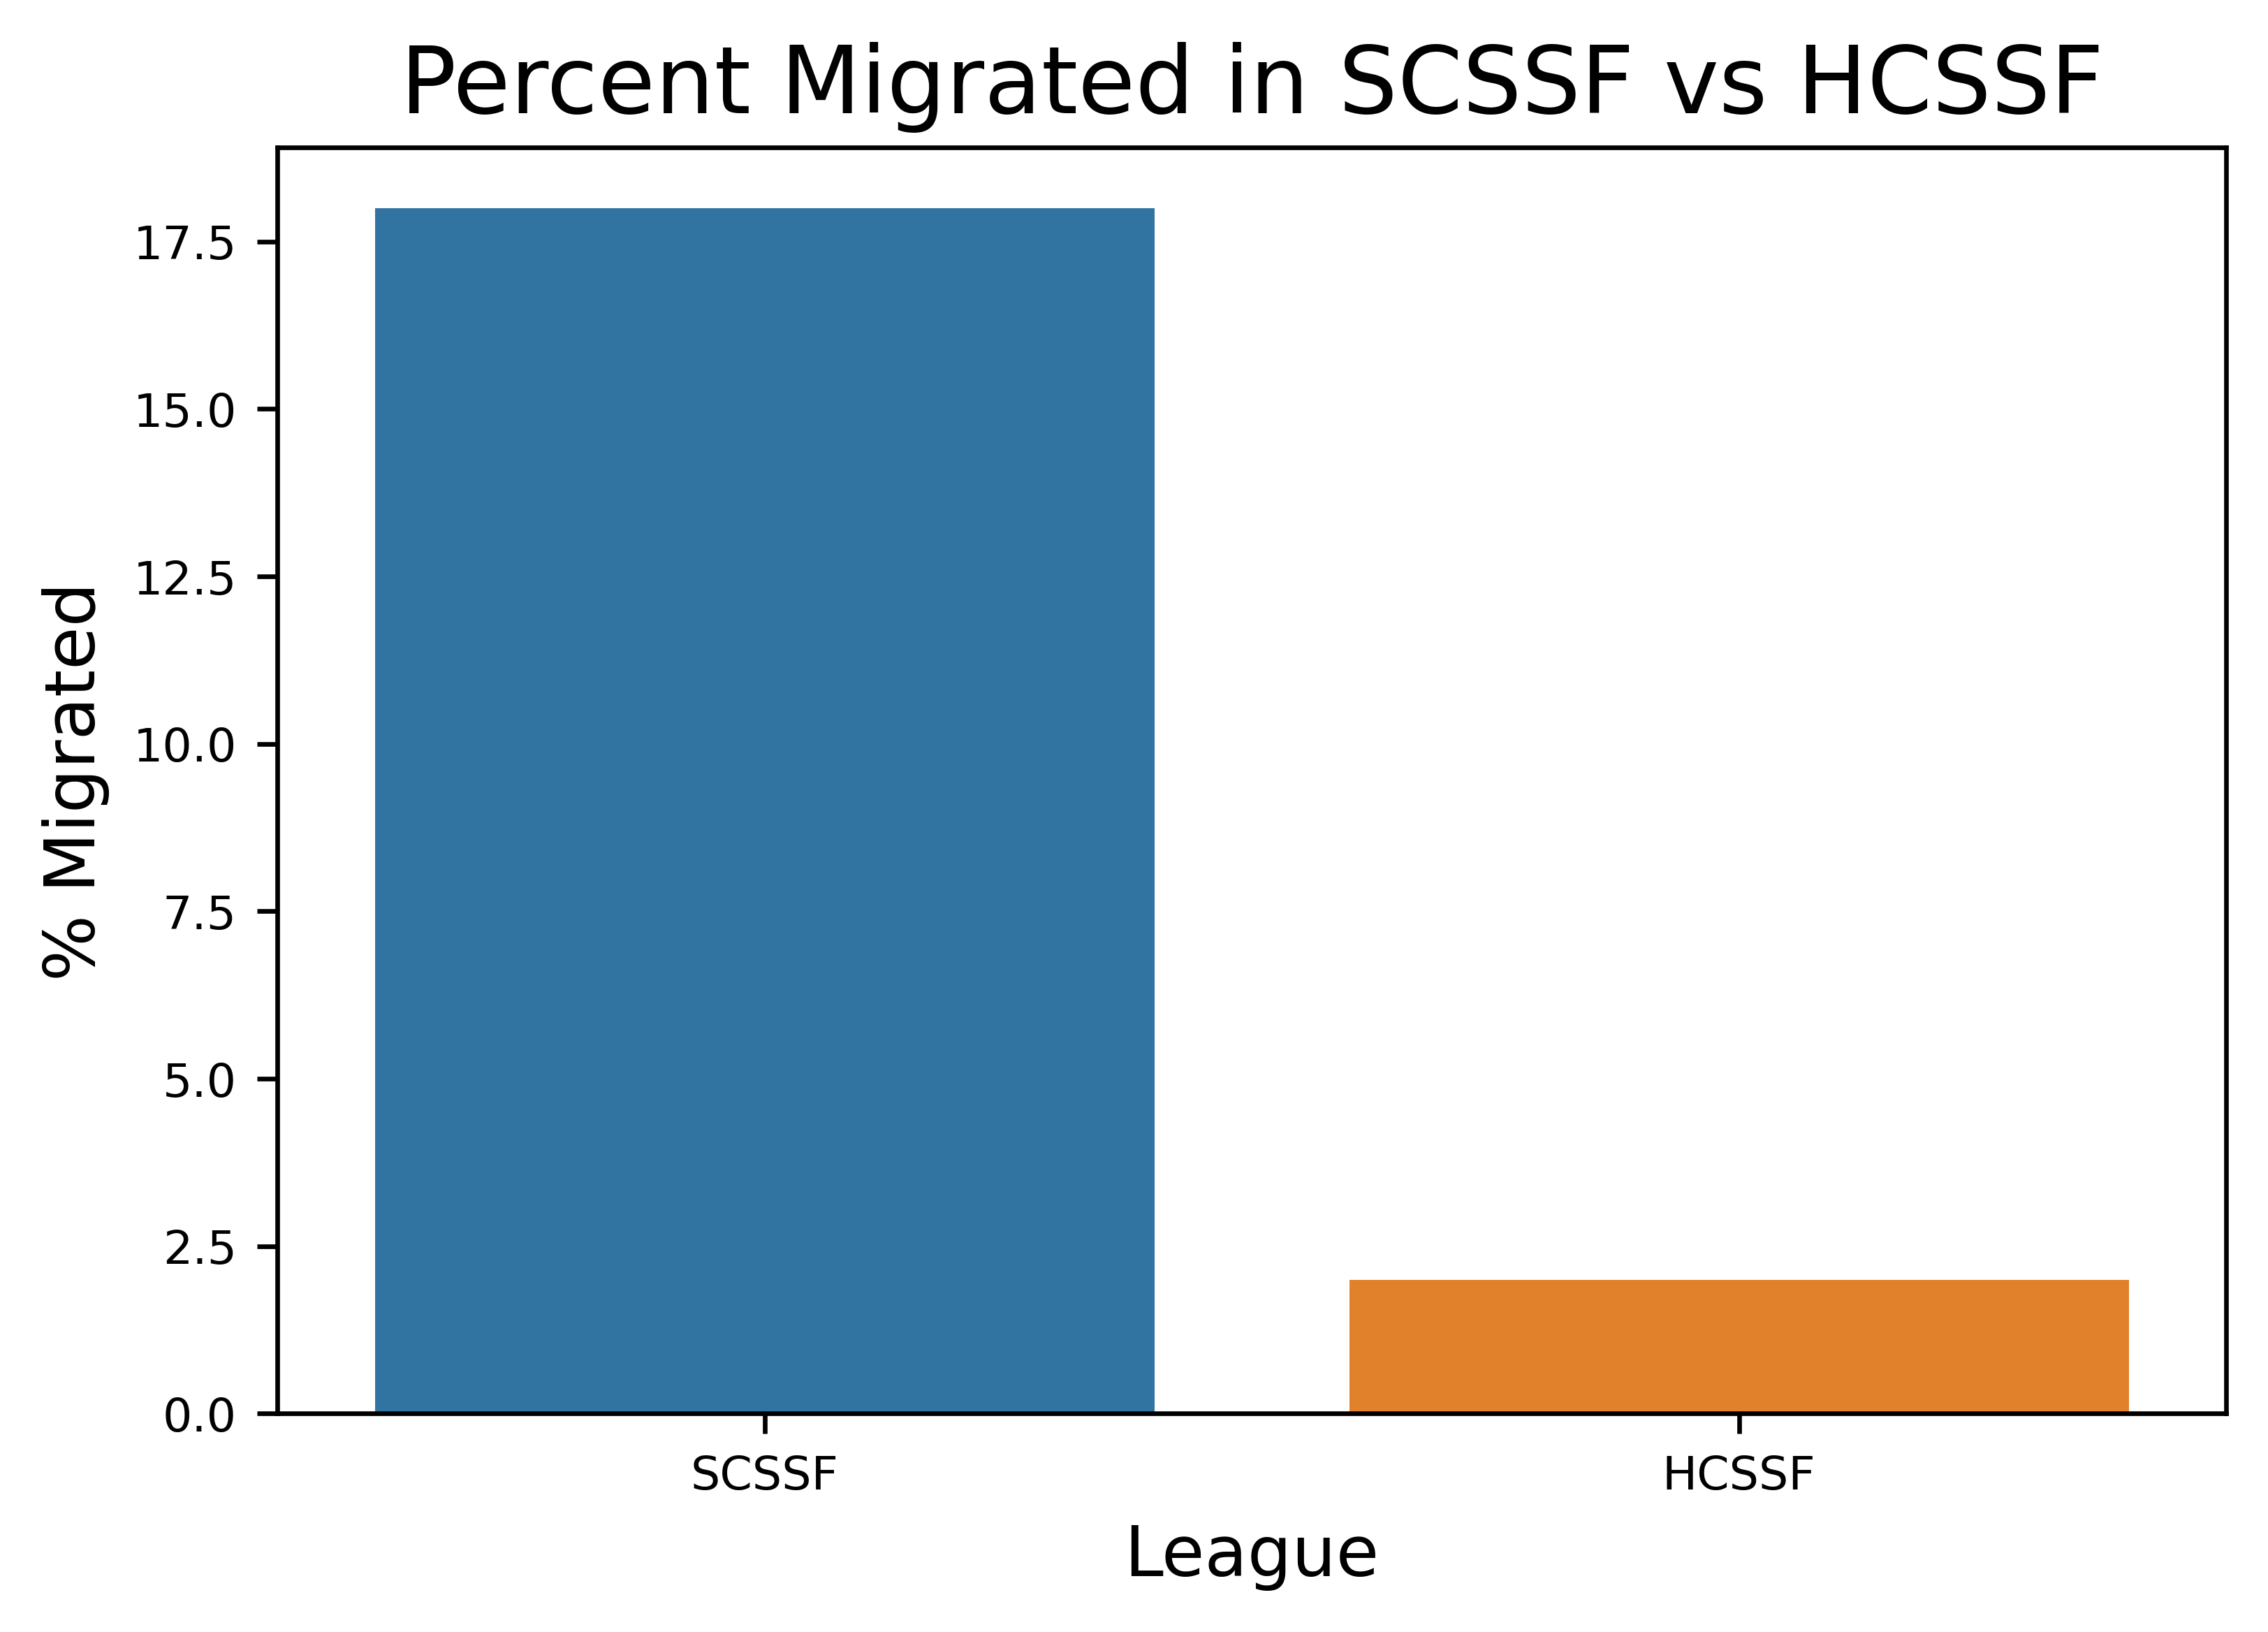

<Figure size 3600x2400 with 0 Axes>

In [35]:
sc_migrate = 'select 100*sum(case when migrated = 1 then 1 else 0 end)/count(*) as scssf_perc_migrated from scssf'
hc_migrate = 'select 100*sum(case when migrated = 1 then 1 else 0 end)/count(*) as hcssf_perc_migrated from hcssf'

sc_migrate_df = pd.read_sql_query(sc_migrate, conn)

hc_migrate_df = pd.read_sql_query(hc_migrate, conn)

migrate = pd.concat([sc_migrate_df, hc_migrate_df],axis=1)

perc_migrated = sns.barplot(data=migrate)

plt.title(label = 'Percent Migrated in SCSSF vs HCSSF', fontsize = 16)

plt.xlabel('League', fontsize = 12)
plt.xticks(ticks = [0,1], labels = ['SCSSF','HCSSF'], fontsize = 8)

plt.ylabel('% Migrated', fontsize = 12)
plt.yticks(fontsize = 8)

plt.figure(dpi=600)
plt.tight_layout()

The league is called Sentinel, and Sent might be a good abbreviation for a character name. How many people have Sent in their name?

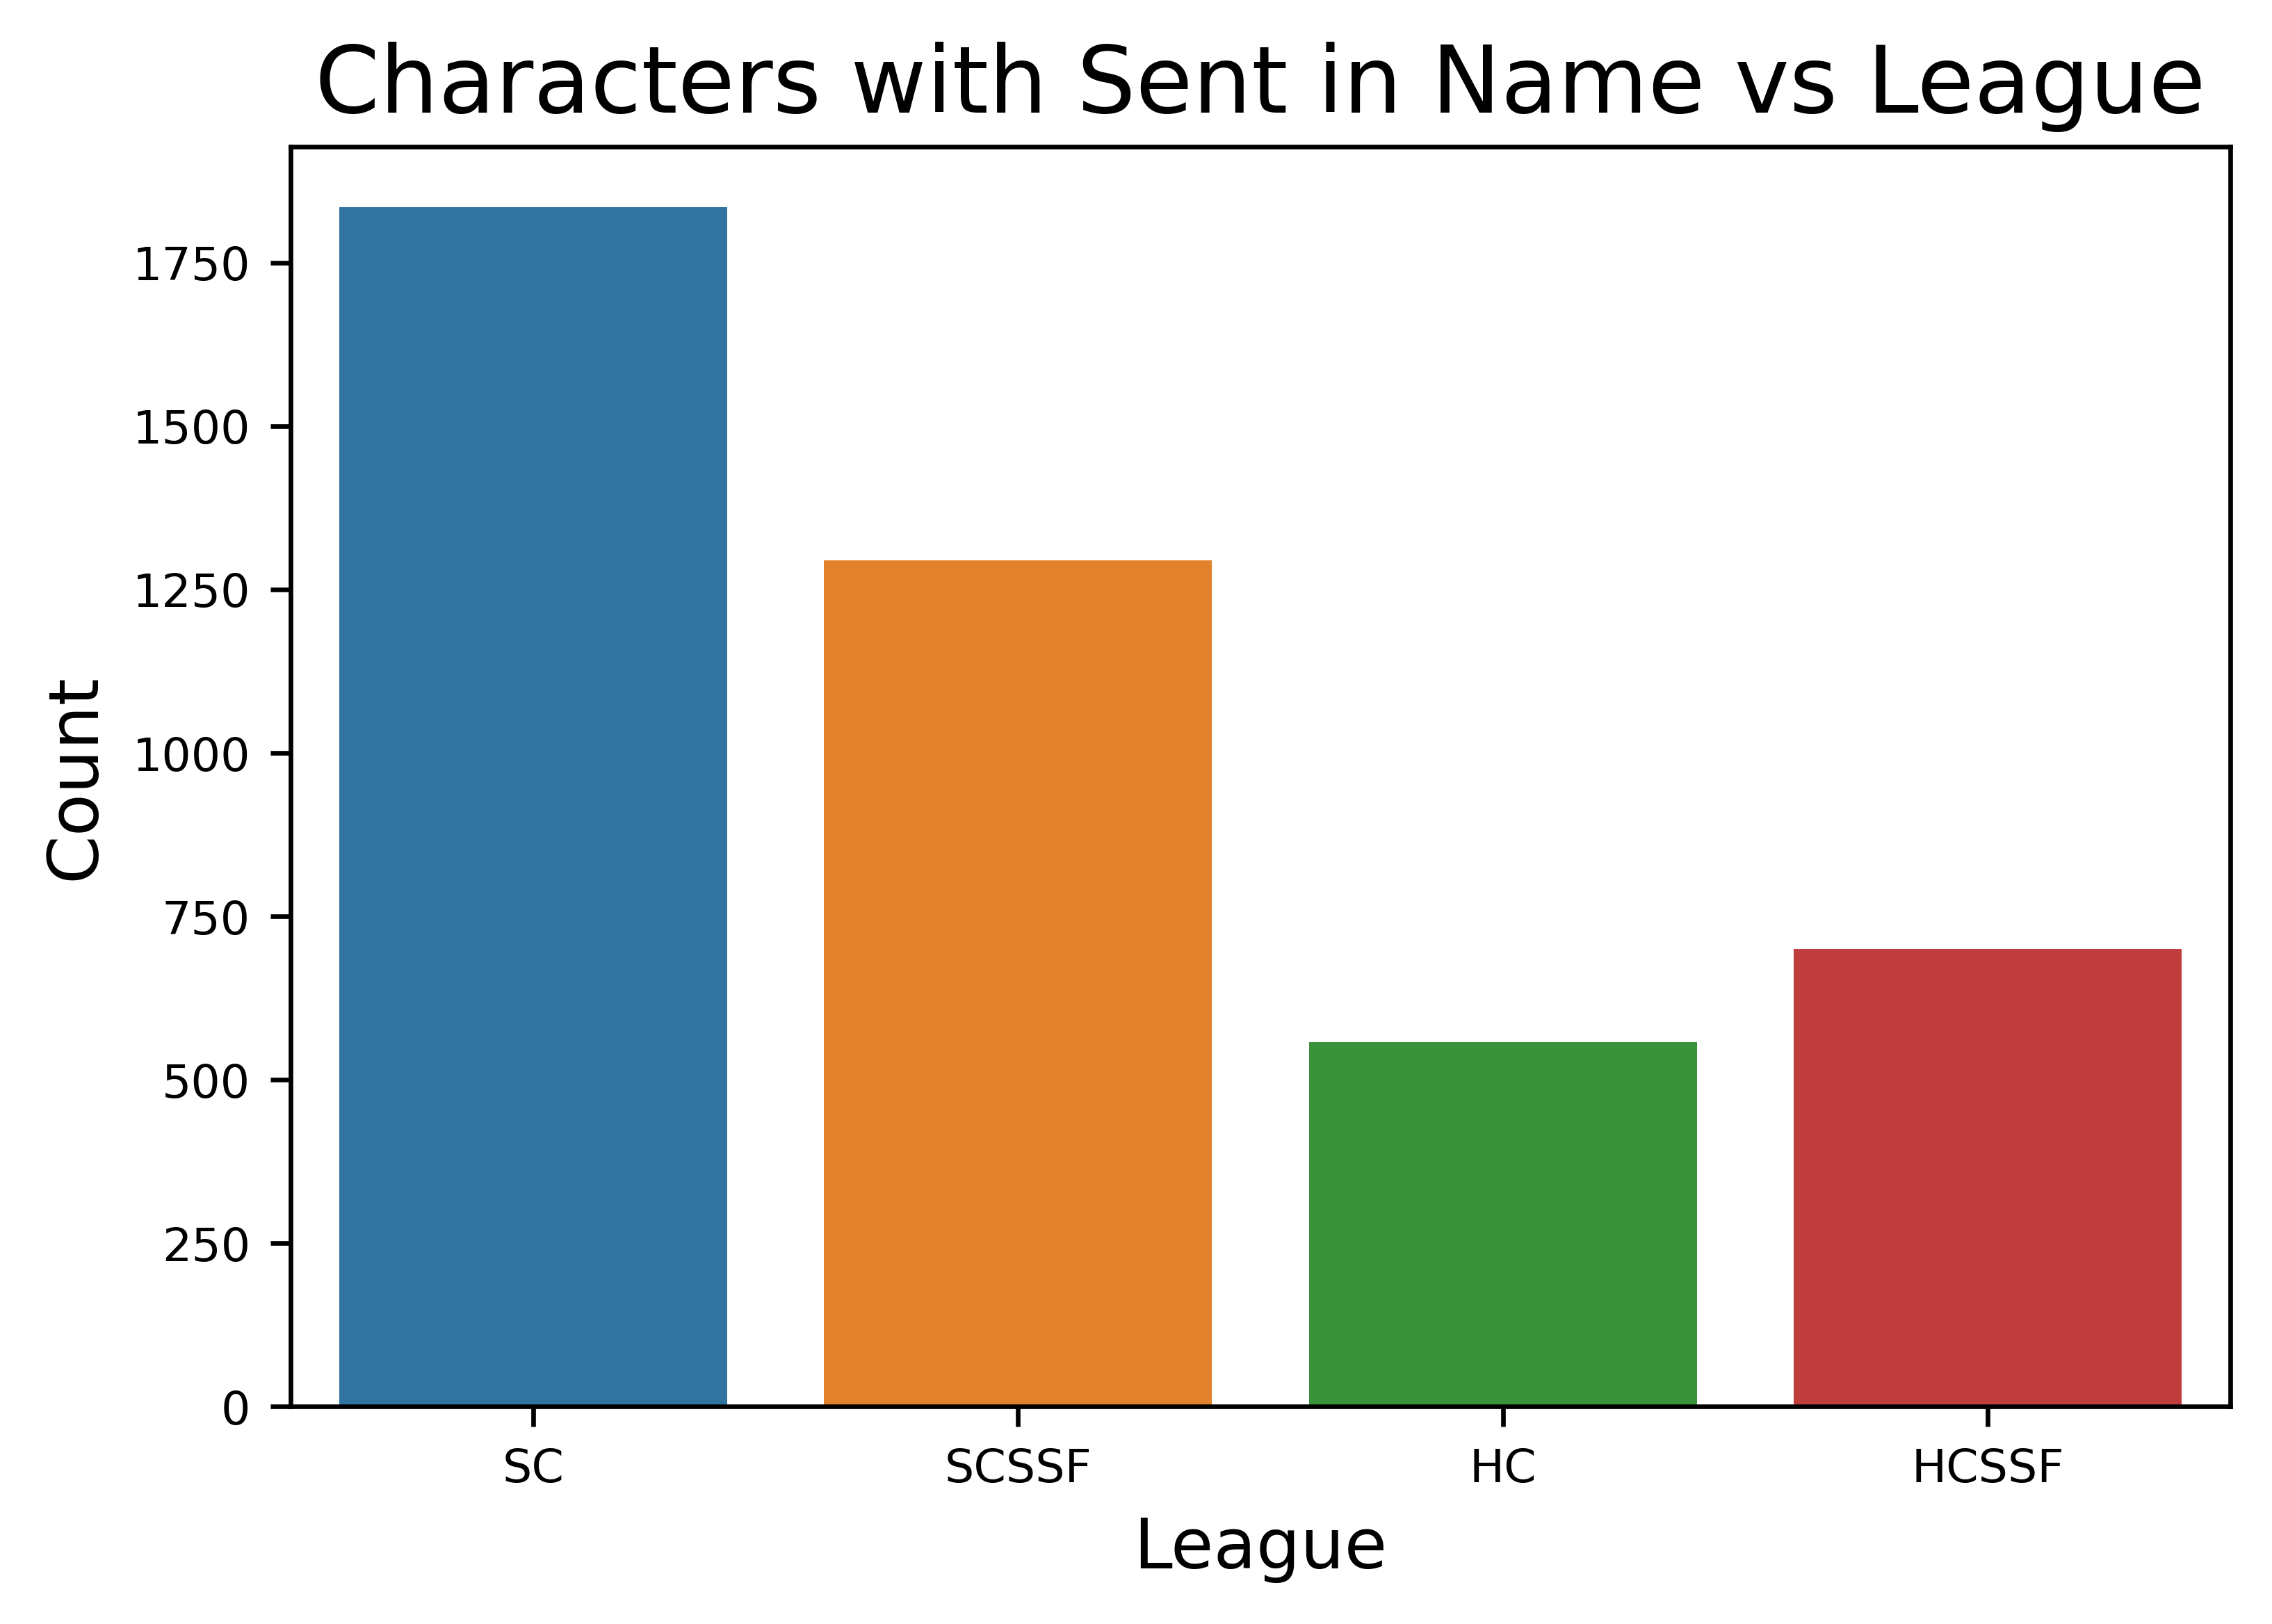

<Figure size 3600x2400 with 0 Axes>

In [36]:
sc_sent_name = 'select sum(case when character_name like \'%sent%\'then 1 else 0 end) as sctrade_sent_in_name from sc'
sc_sent_name_df = pd.read_sql_query(sc_sent_name, conn)

scssf_sent_name = 'select sum(case when character_name like \'%sent%\'then 1 else 0 end) as scssf_sent_in_name from scssf'
scssf_sent_name_df = pd.read_sql_query(scssf_sent_name, conn)

hc_sent_name = 'select sum(case when character_name like \'%sent%\'then 1 else 0 end) as hctrade_sent_in_name from hc'
hc_sent_name_df = pd.read_sql_query(hc_sent_name, conn)

hcssf_sent_name = 'select sum(case when character_name like \'%sent%\'then 1 else 0 end) as hcssf_sent_in_name from hcssf'
hcssf_sent_name_df = pd.read_sql_query(hcssf_sent_name, conn)

sent_name_df = pd.concat([sc_sent_name_df, scssf_sent_name_df, hc_sent_name_df, hcssf_sent_name_df], axis = 1)
sent_name_df

sent_name = sns.barplot(data=sent_name_df)
plt.title(label = 'Characters with Sent in Name vs League', fontsize = 16)

plt.xlabel('League', fontsize = 12)
plt.xticks(ticks = [0,1,2,3], labels = ['SC','SCSSF','HC','HCSSF'], fontsize = 8)

plt.ylabel('Count', fontsize = 12)
plt.yticks(fontsize = 8)

plt.figure(dpi=600)
plt.tight_layout()

How many people have their full account name in their character name? 

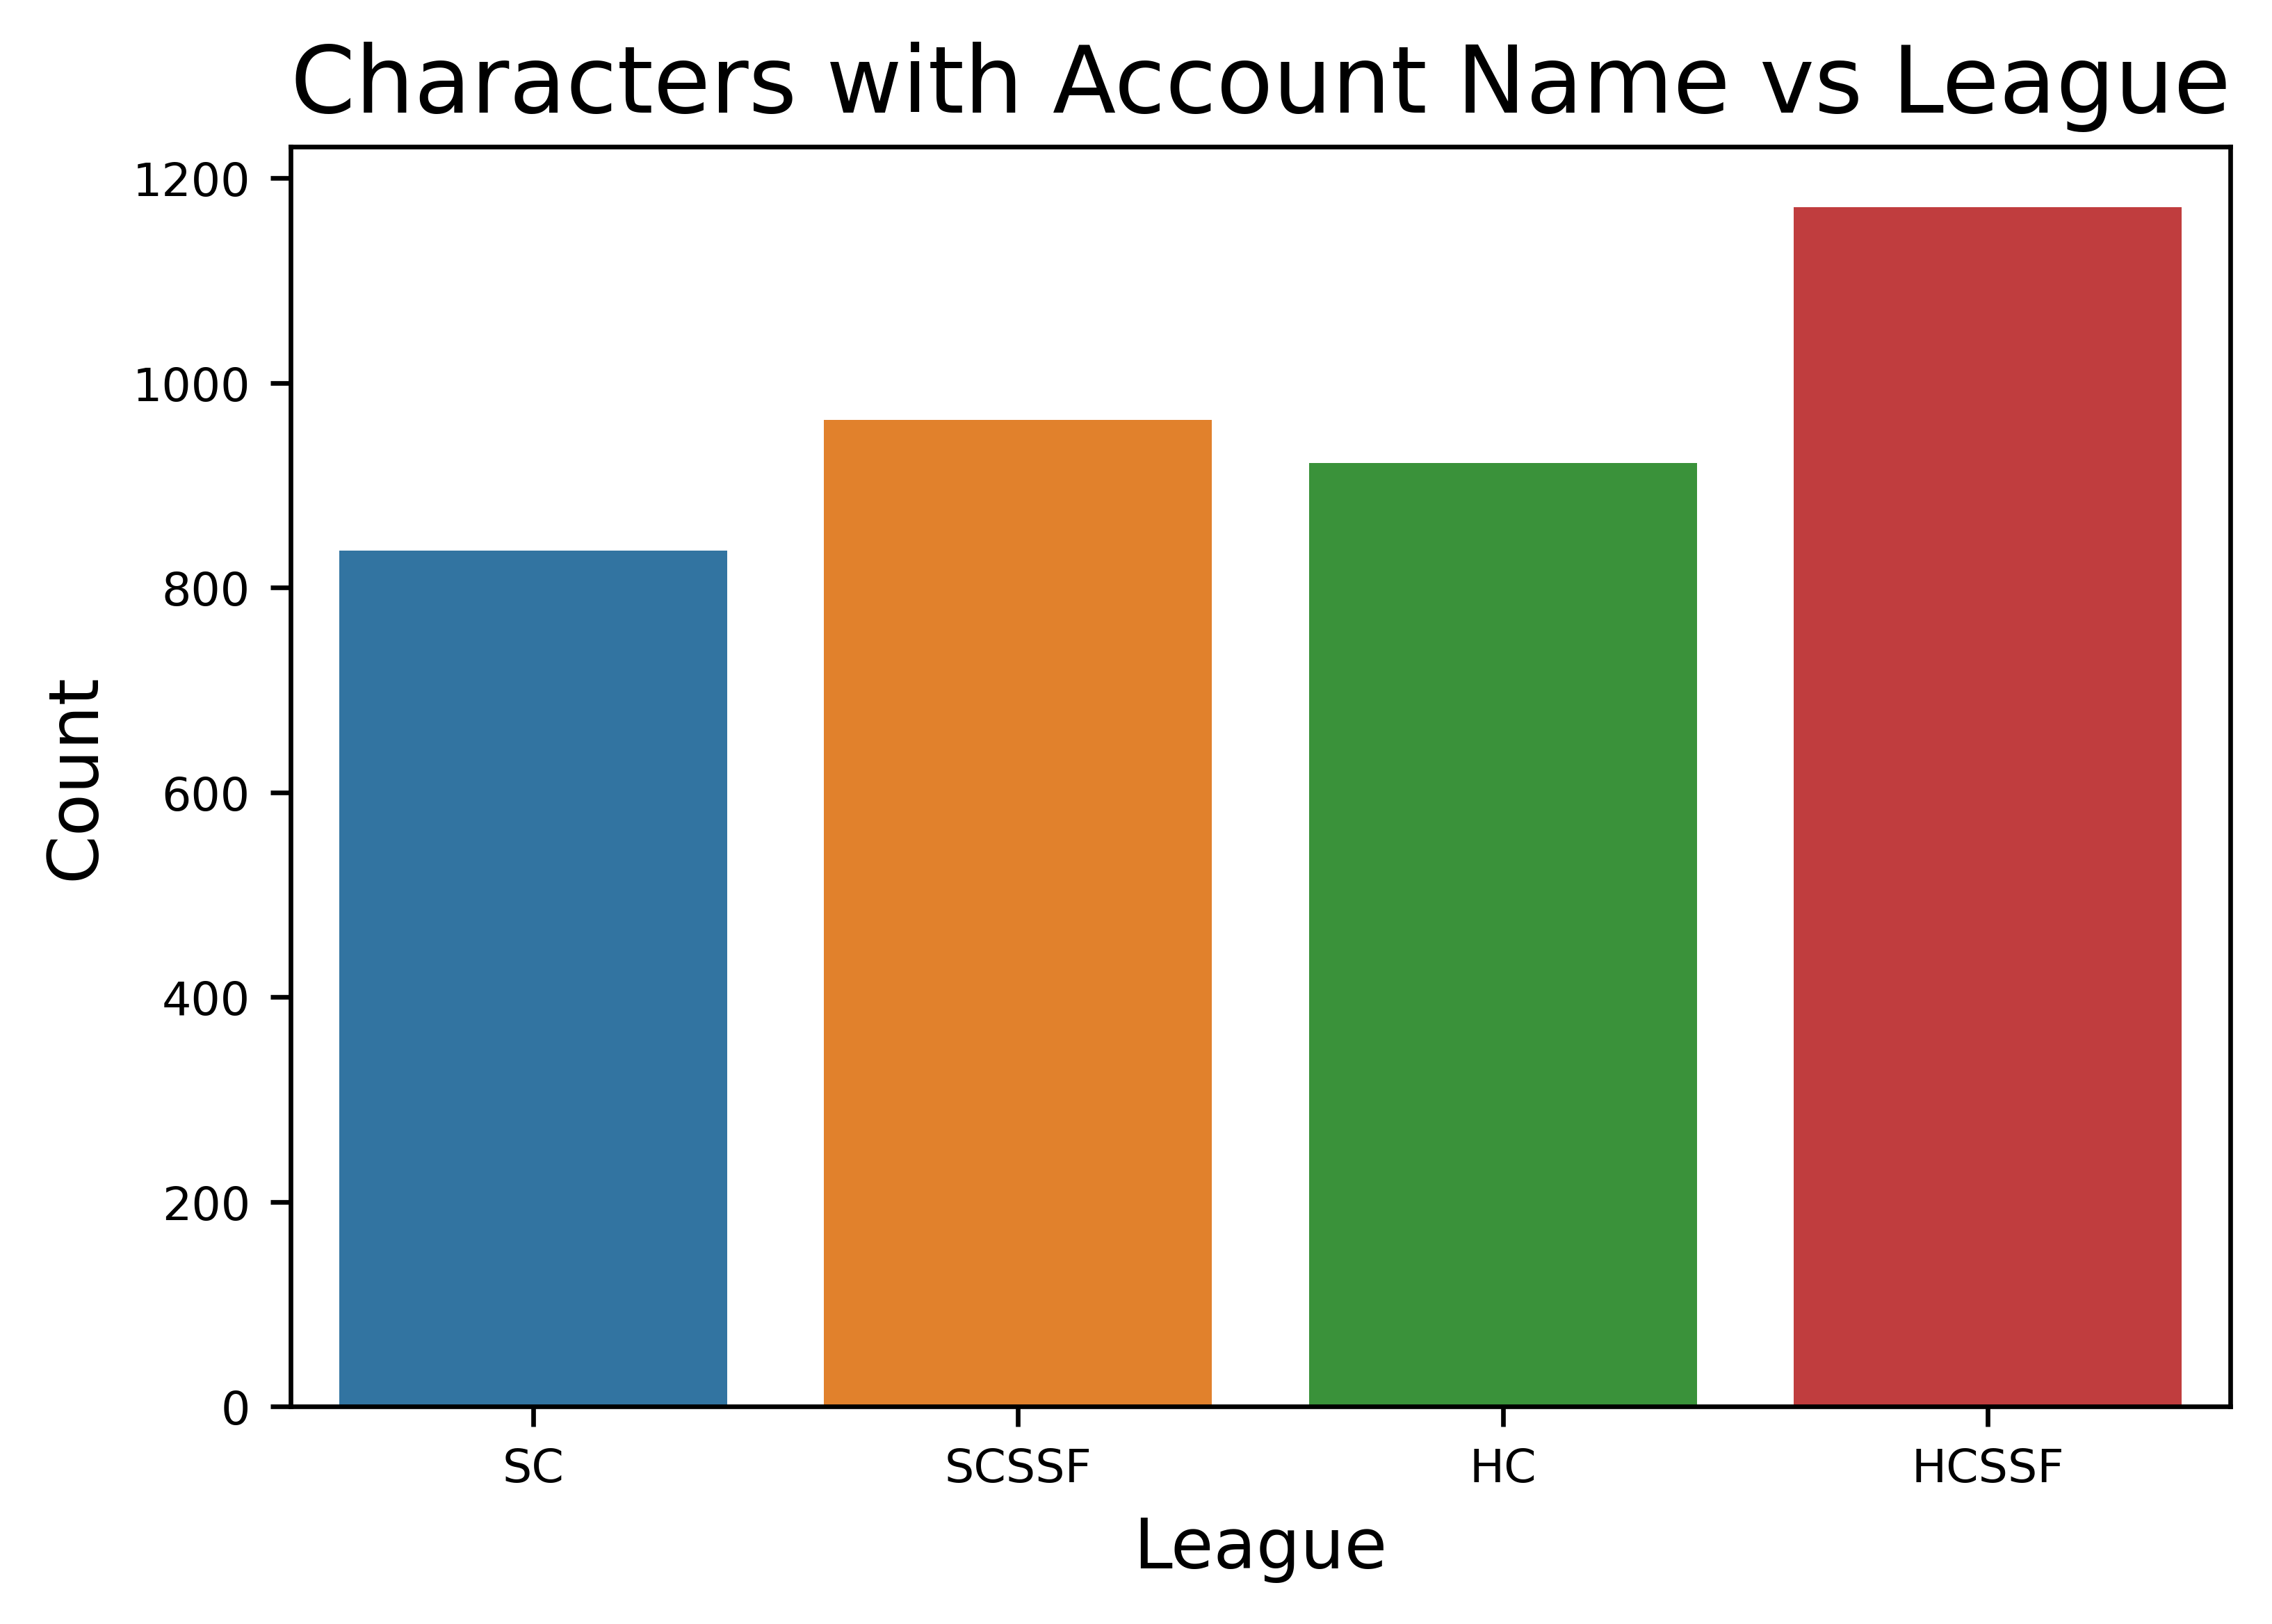

<Figure size 3600x2400 with 0 Axes>

In [37]:
sc_char_acct_name = 'select count(*) as account_name_in_char_SC from SC where character_name like \'%\' || account_name || \'%\''
sc_char_acct_name_df = pd.read_sql_query(sc_char_acct_name, conn)
sc_char_acct_name_df

scssf_char_acct_name = 'select count(*) as account_name_in_char_SCSSF from SCSSF where character_name like \'%\' || account_name || \'%\''
scssf_char_acct_name_df = pd.read_sql_query(scssf_char_acct_name, conn)
scssf_char_acct_name_df

hc_char_acct_name = 'select count(*) as account_name_in_char_HC from HC where character_name like \'%\' || account_name || \'%\''
hc_char_acct_name_df = pd.read_sql_query(hc_char_acct_name, conn)
hc_char_acct_name_df

hcssf_char_acct_name = 'select count(*) as account_name_in_char_HCSSF from HCSSF where character_name like \'%\' || account_name || \'%\''
hcssf_char_acct_name_df = pd.read_sql_query(hcssf_char_acct_name, conn)
hcssf_char_acct_name_df

char_acct_name = pd.concat([sc_char_acct_name_df, scssf_char_acct_name_df, hc_char_acct_name_df, hcssf_char_acct_name_df],axis=1)
char_acct_name

acct_name = sns.barplot(data=char_acct_name)
plt.title(label = 'Characters with Account Name vs League', fontsize = 16)

plt.xlabel('League', fontsize = 12)
plt.xticks(ticks = [0,1,2,3], labels = ['SC','SCSSF','HC','HCSSF'], fontsize = 8)

plt.ylabel('Count', fontsize = 12)
plt.yticks(fontsize = 8)

plt.figure(dpi=600)
plt.tight_layout()

Which players have shown up the most on SSFHC? HC Trade?

In [7]:
hcssf_char_num = 'select account_name, count(*) as num_ladder_char_hcssf from HCSSF group by account_name order by num_ladder_char_hcssf desc limit 10'
hcssf_char_num_df = pd.read_sql_query(hcssf_char_num, conn)
hcssf_char_num_df

hc_char_num = 'select account_name, count(*) as num_ladder_char_hc from HC group by account_name order by num_ladder_char_hc desc limit 10'
hc_char_num_df = pd.read_sql_query(hc_char_num, conn)

hc_hcssf_char_num = pd.concat([hc_char_num_df, hcssf_char_num_df],axis=1)
hc_hcssf_char_num

,account_name,num_ladder_char_hc,account_name,num_ladder_char_hcssf
0,kepchuk88,18,idrinkgasoline,21
1,xSATROSx,17,inkki,17
2,Storm_The_House,16,gunterxc,17
3,bkthom,14,Zekju,17
4,Phyzix,14,Bradfordh1995,17
5,P4nd4n1k3,14,AnTiCkY,17
6,BrotherAlbin,14,AiSatan,17
7,Anvies,14,nimroz,16
8,koleski,13,kenjiboddah,16
9,akanimo,13,Poiuytr133,16


That's a lot of characters shown up on the ladder. The ladder only pulls the top 15000 characters. Whats the lowest character level in all 4 leagues?

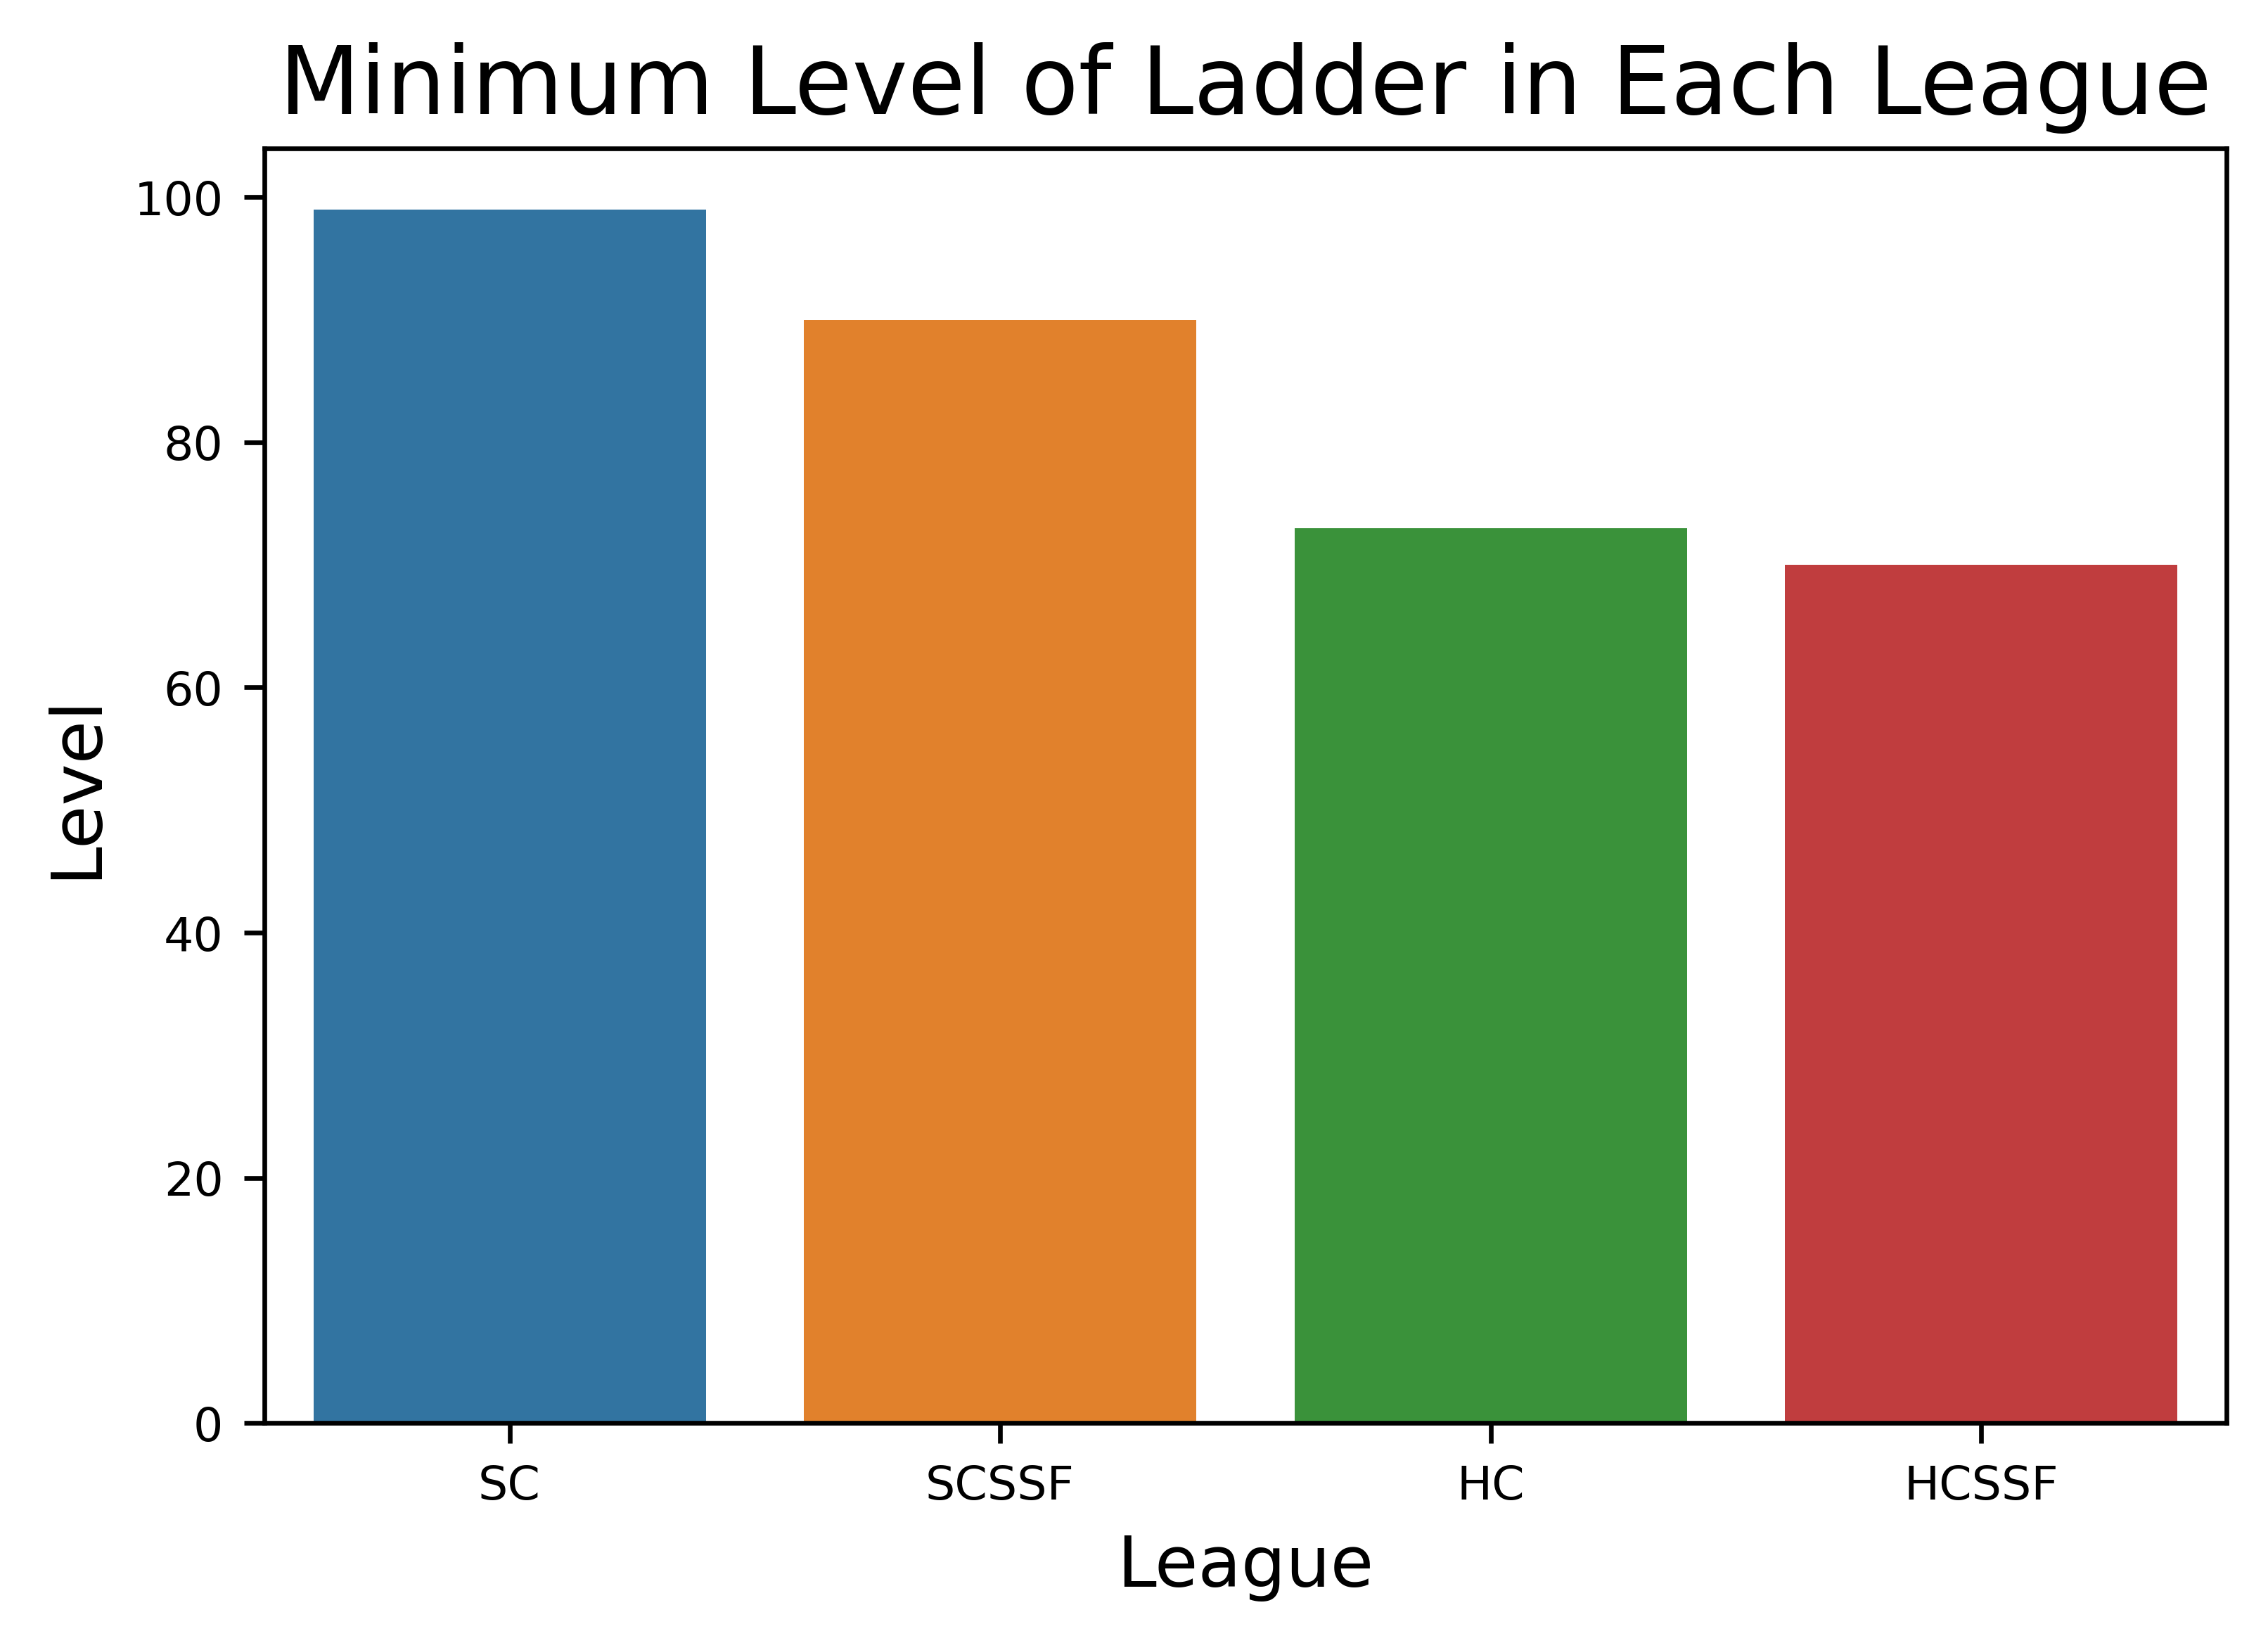

<Figure size 3600x2400 with 0 Axes>

In [38]:
sc_min_level = 'select min(level) as sc_min_level from sc'
sc_min_level_df = pd.read_sql_query(sc_min_level, conn)

scssf_min_level = 'select min(level) as scssf_min_level from scssf'
scssf_min_level_df = pd.read_sql_query(scssf_min_level, conn)

hc_min_level = 'select min(level) as hc_min_level from hc'
hc_min_level_df = pd.read_sql_query(hc_min_level, conn)

hcssf_min_level = 'select min(level) as hcssf_min_level from hcssf'
hcssf_min_level_df = pd.read_sql_query(hcssf_min_level, conn)

min_level = pd.concat([sc_min_level_df, scssf_min_level_df, hc_min_level_df, hcssf_min_level_df], axis=1)
min_level

sns.barplot(data = min_level)
plt.title(label = 'Minimum Level of Ladder in Each League', fontsize = 16)

plt.xlabel('League', fontsize = 12)
plt.xticks(ticks = [0,1,2,3], labels = ['SC','SCSSF','HC','HCSSF'], fontsize = 8)

plt.ylabel('Level', fontsize = 12)
plt.yticks(fontsize = 8)

plt.figure(dpi=600)
plt.tight_layout()

This does not put into perspective how much more popular SC as a league are compared to HC. 

A more interesting query would be to see the total number of 100s in a league 

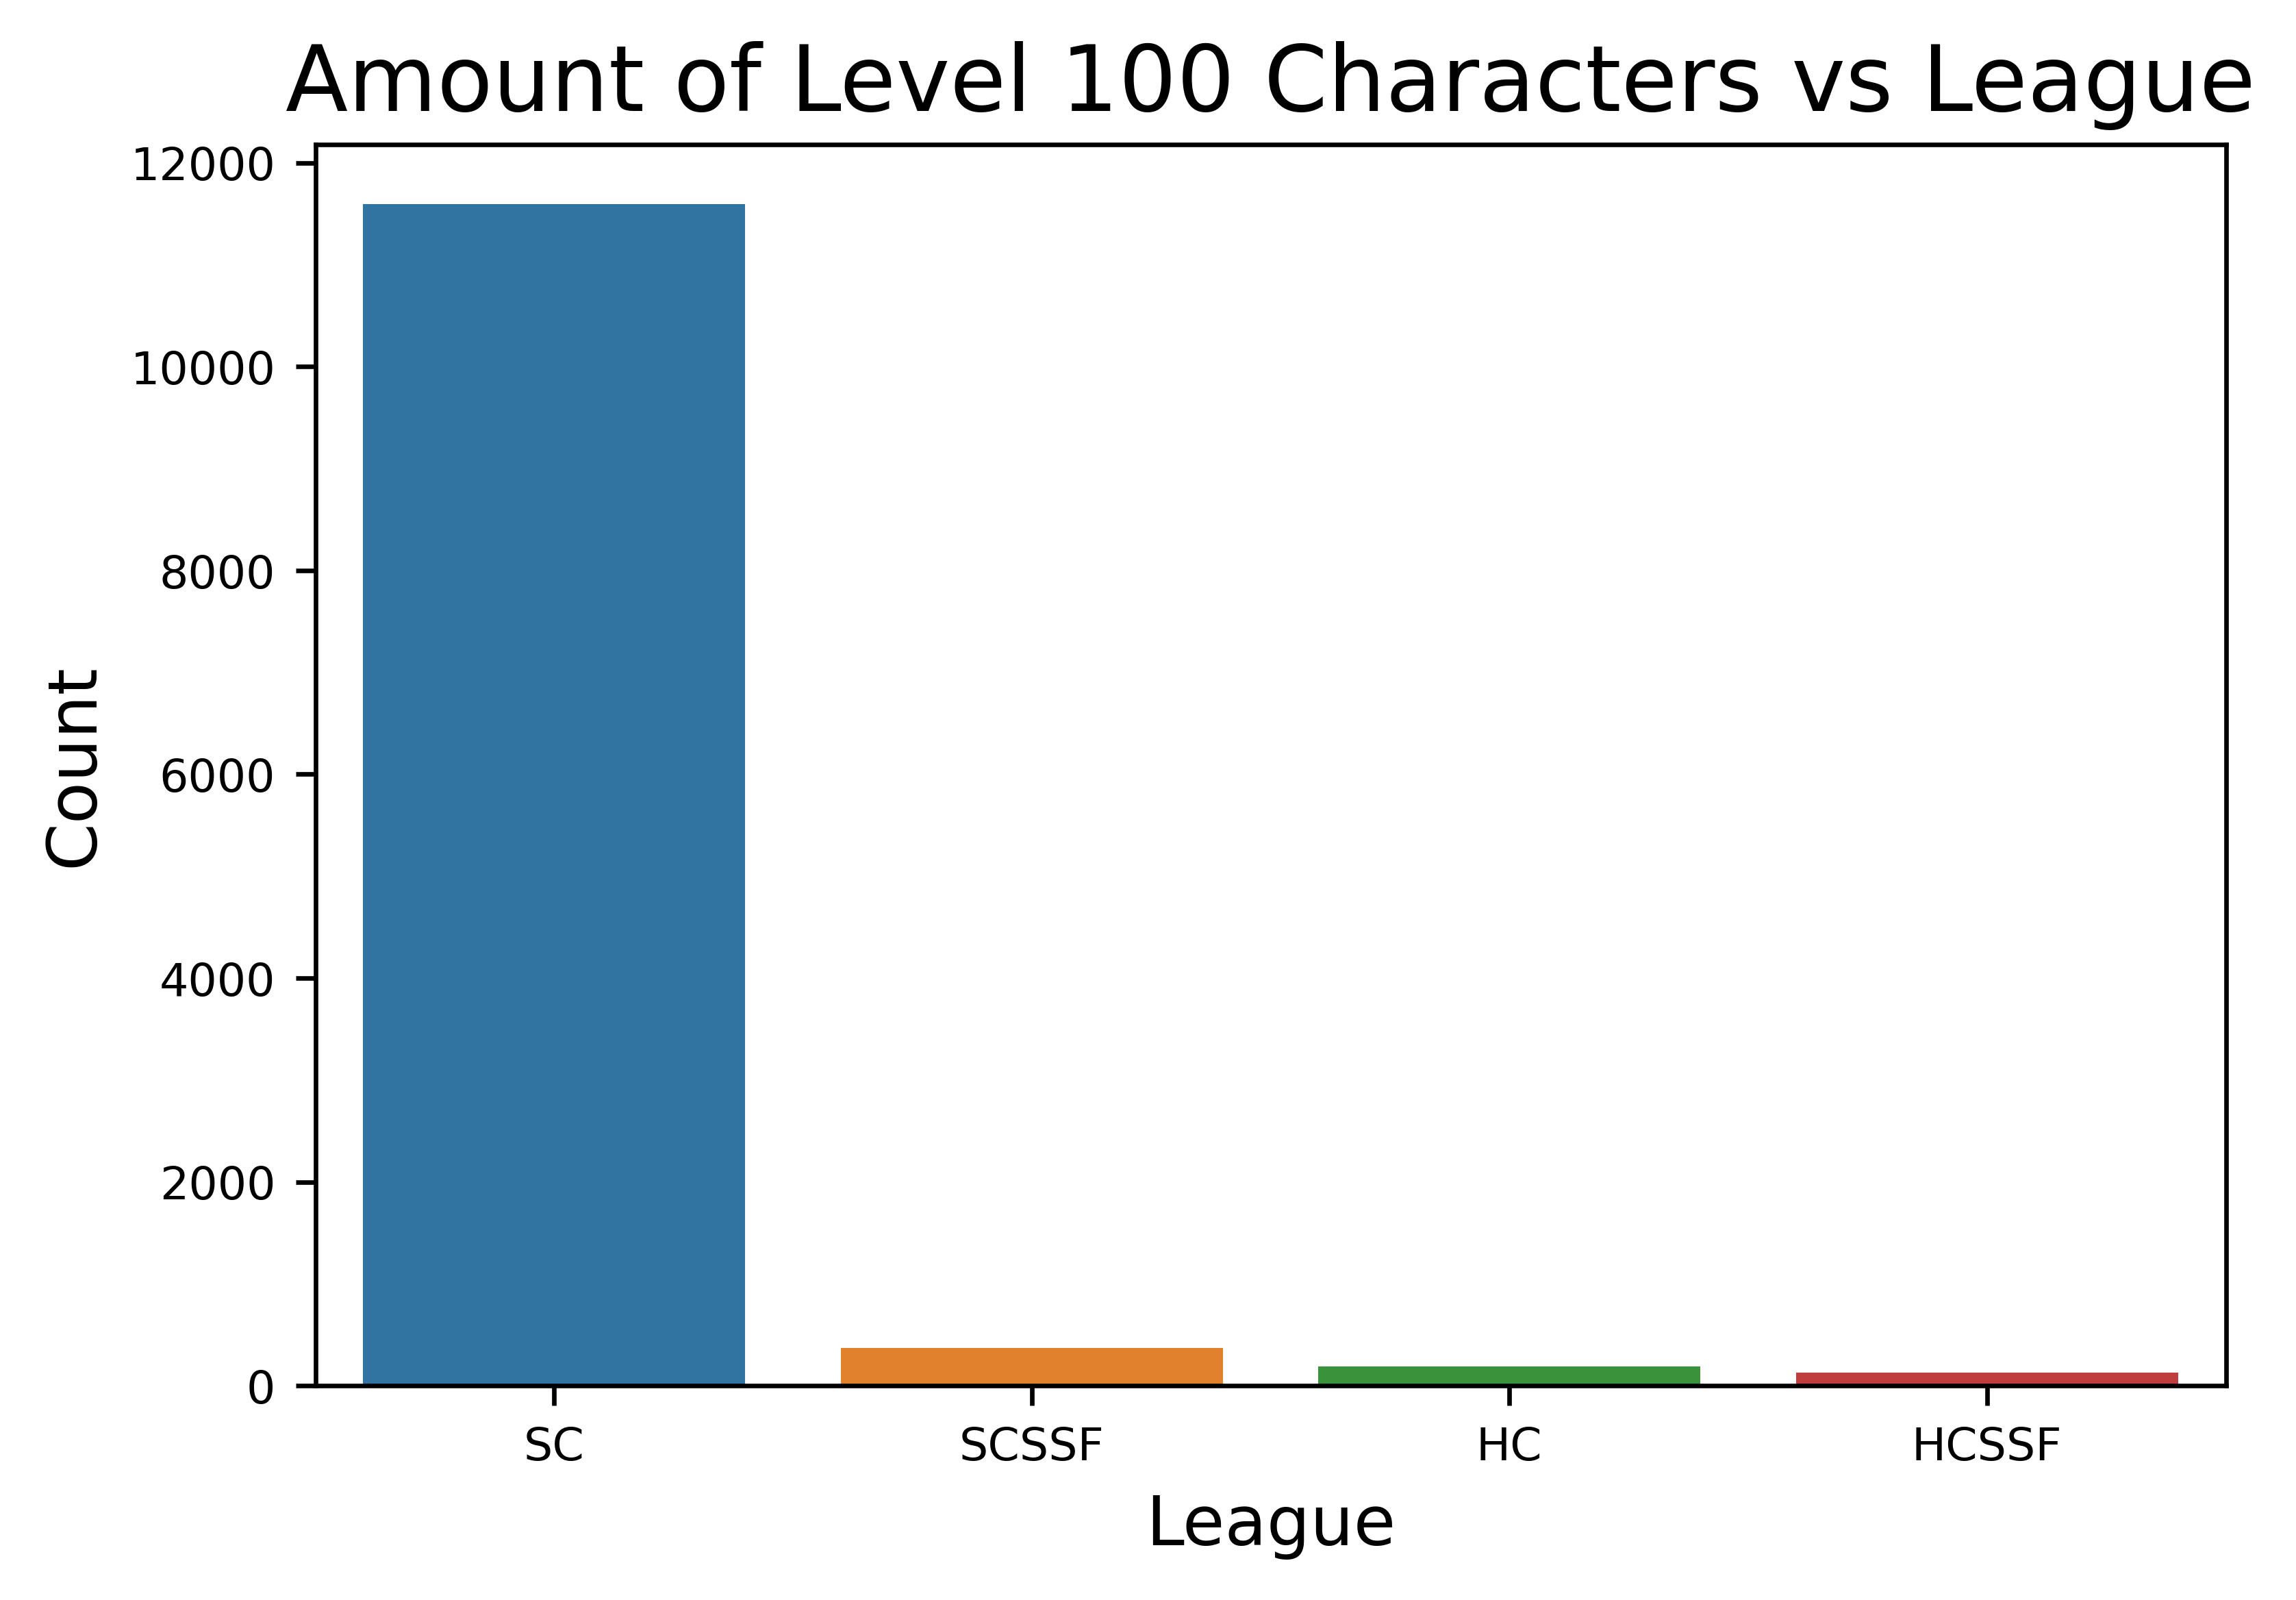

<Figure size 3600x2400 with 0 Axes>

In [39]:
sc_char_num_100 = 'select count(*) as sc_100s from SC where level=100'
sc_char_num_100_df = pd.read_sql_query(sc_char_num_100, conn)

scssf_char_num_100 = 'select count(*) as scssf_100s from SCSSF where level=100'
scssf_char_num_100_df = pd.read_sql_query(scssf_char_num_100, conn)


hc_char_num_100 = 'select count(*) as hc_100s from HC where level=100'
hc_char_num_100_df = pd.read_sql_query(hc_char_num_100, conn)

hcssf_char_num_100 = 'select count(*) as hcssf_100s from HCSSF where level=100'
hcssf_char_num_100_df = pd.read_sql_query(hcssf_char_num_100, conn)

level100s = pd.concat([sc_char_num_100_df, scssf_char_num_100_df, hc_char_num_100_df, hcssf_char_num_100_df],axis=1)
level100s

level100s_graph = sns.barplot(data=level100s)
plt.title(label = 'Amount of Level 100 Characters vs League', fontsize = 16)

plt.xlabel('League', fontsize = 12)
plt.xticks(ticks = [0,1,2,3], labels = ['SC','SCSSF','HC','HCSSF'], fontsize = 8)

plt.ylabel('Count', fontsize = 12)
plt.yticks(fontsize = 8)

plt.figure(dpi=600)
plt.tight_layout()

How many characters on the SC trade ladder are less than 10% of the way to level 100?

In [10]:
exp_to_gain = 317515914*.9
sc_trade_99_over90 = 'select count(*) as closer_to_100 from sc where experience>'+str(exp_to_gain)+' +3932818530 and level!=100'
sc_trade_99_over90_df = pd.read_sql_query(sc_trade_99_over90, conn)
sc_trade_99_over90_df

,closer_to_100
0,56


In [11]:
sc_trade_99_sub10 = 'select count(*) as closer_to_99 from sc where experience>=(3932818530+0.1*317515914) and level=99'
sc_trade_99_sub10_df = pd.read_sql_query(sc_trade_99_sub10, conn)
sc_trade_99_sub10_df

,closer_to_99
0,2427


Visualize the distribution of XP of those that are level 99 in SC trade. The POE API pulls only the top 15000 characters in terms of XP, so there's likely a lot more at level 99 than what is showing!

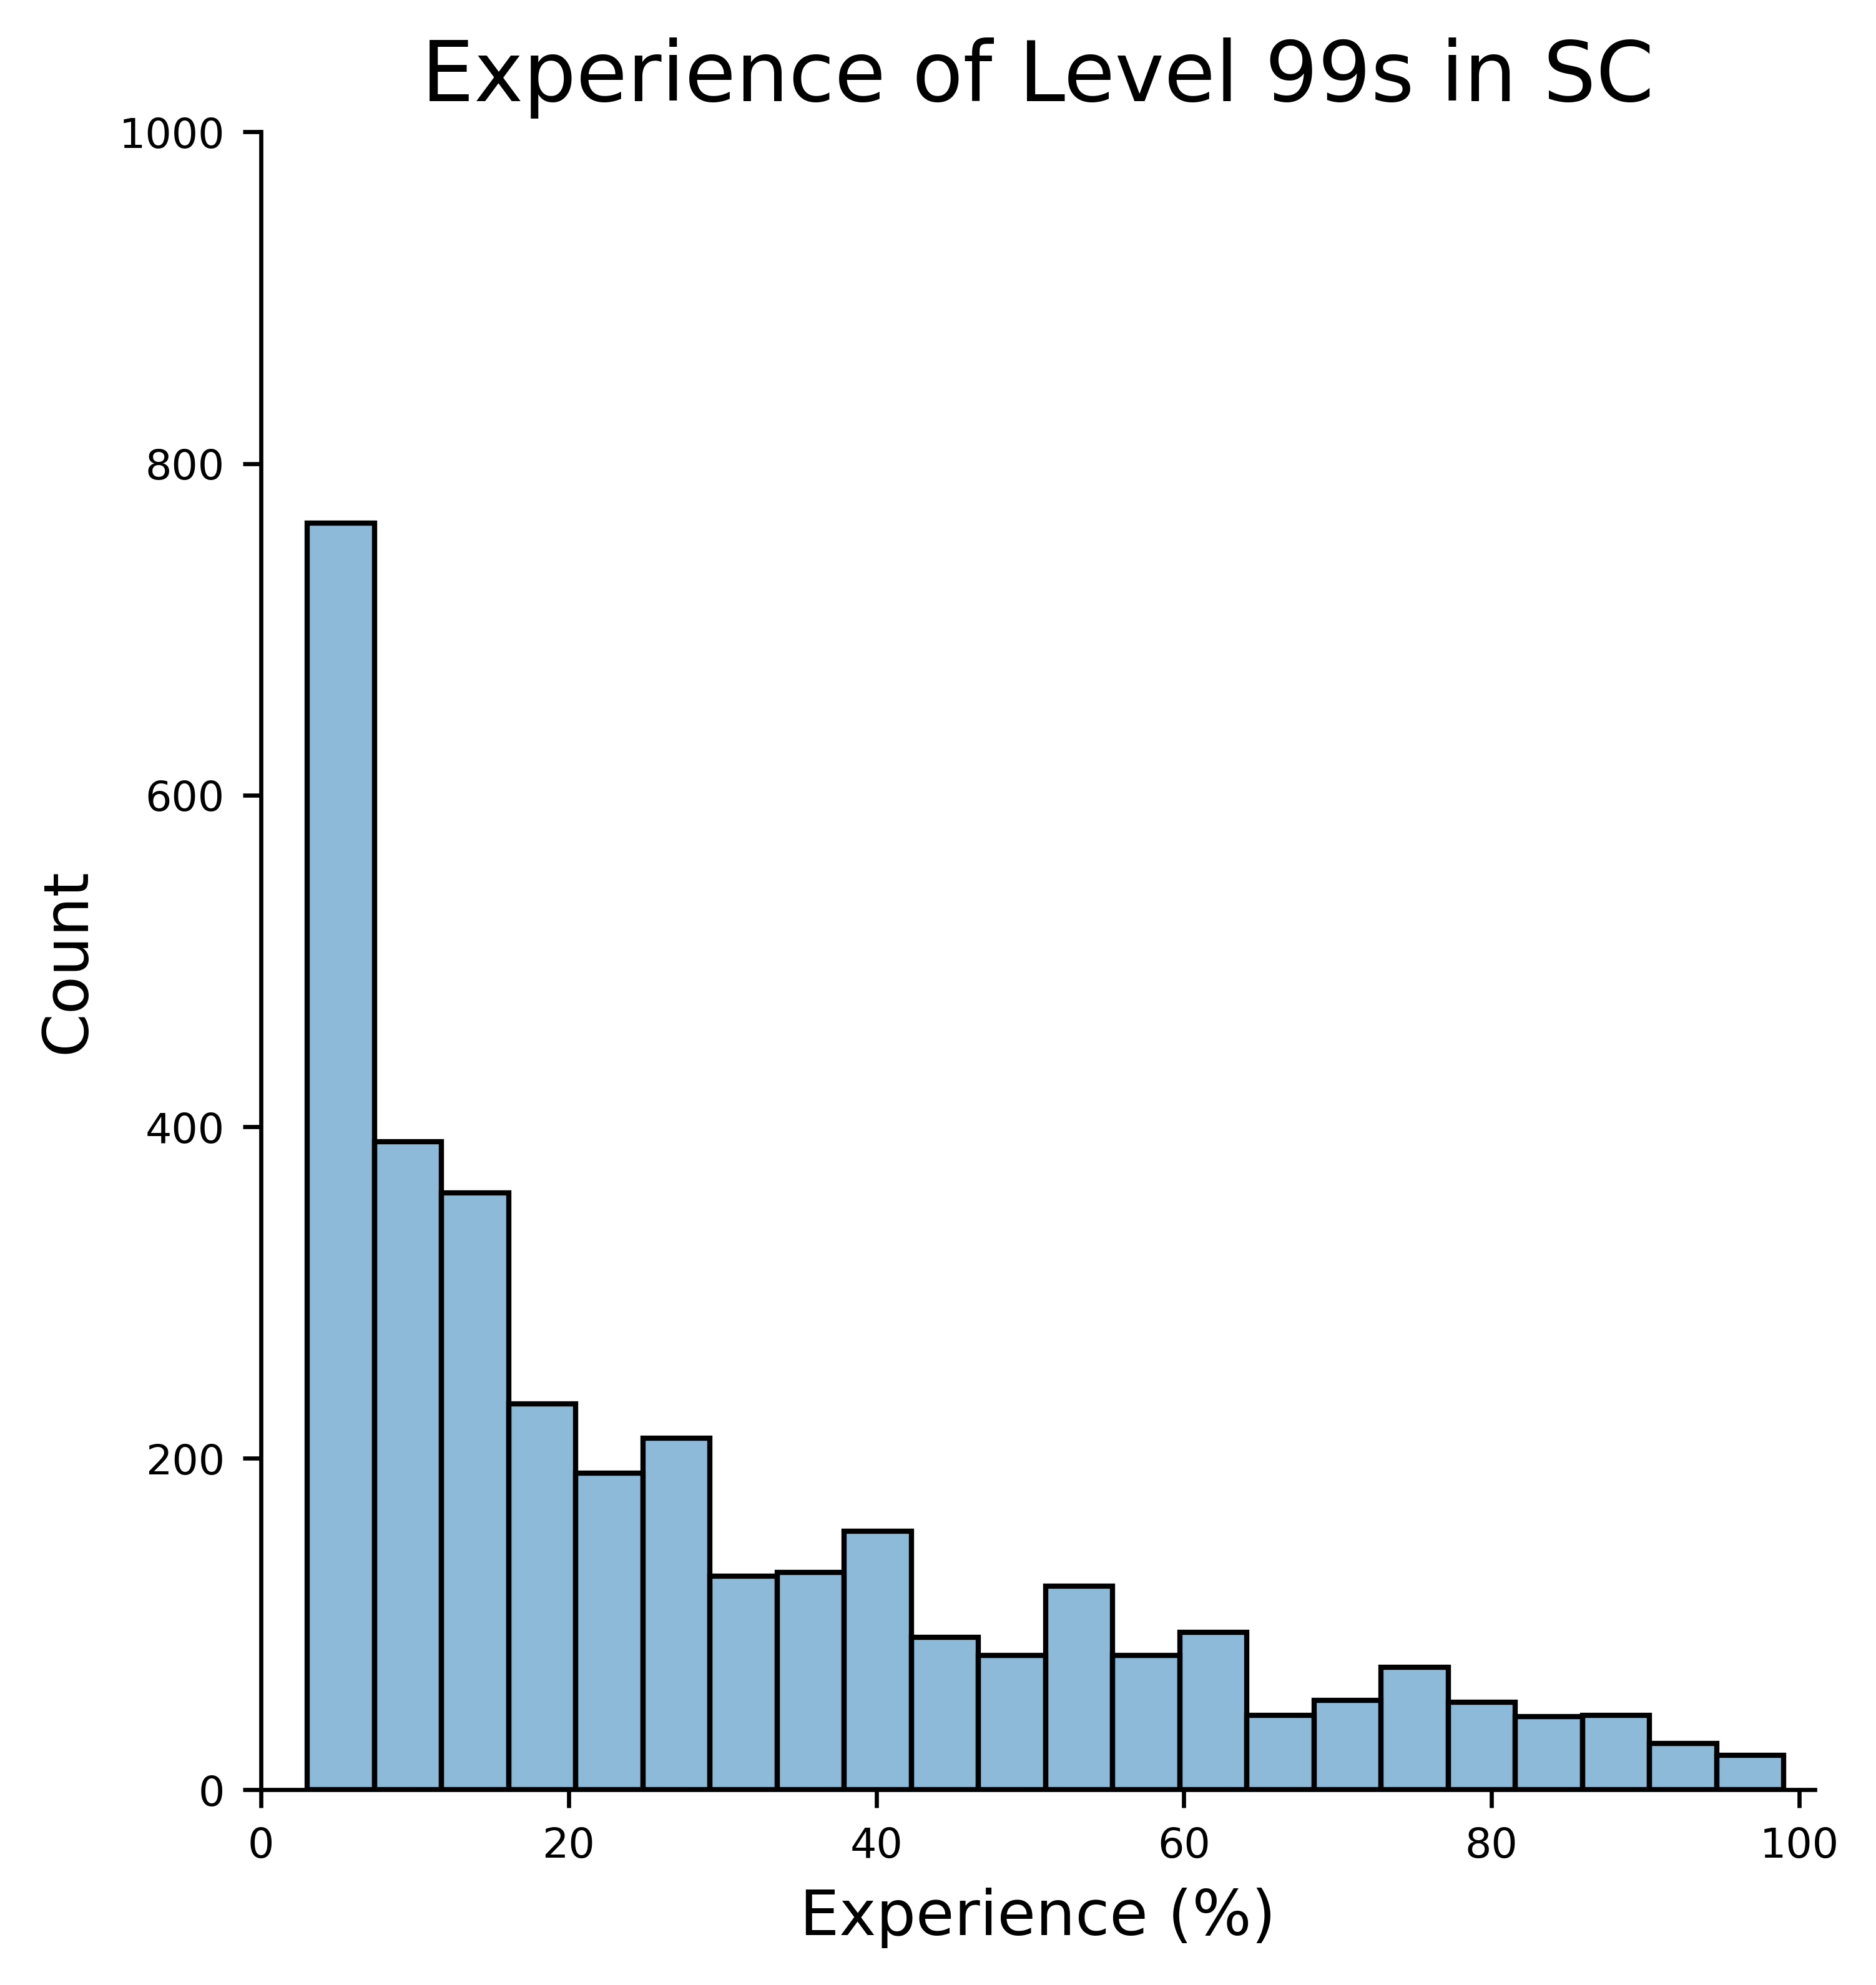

<Figure size 3600x2400 with 0 Axes>

In [40]:
exp_99 = 'select 100*(experience-3932818530)/317515914 as perc_to_100 from SC where level=99'
exp_99_df = pd.read_sql_query(exp_99,conn)

exp_99_graph = sns.displot(data=exp_99_df, legend=None)

plt.title(label = 'Experience of Level 99s in SC', fontsize = 16)
plt.xlabel('Experience (%)', fontsize = 12)
plt.xticks(fontsize = 8)
plt.xlim(0,101)

plt.ylabel('Count', fontsize = 12)
plt.yticks(fontsize = 8)
plt.ylim(0,1000)

plt.figure(dpi=600)
plt.tight_layout()

Does anyone show up in all four ladders?

In [13]:
sc_ssfhc = 'select account_name from HCSSF where account_name in (select account_name from SC) and account_name in (select account_name from SCSSF) and (select account_name from HC)'
sc_ssfhc_df = pd.read_sql_query(sc_ssfhc,conn)
sc_ssfhc_df

,account_name


How many characters are dead in HCSSF vs HC Trade?

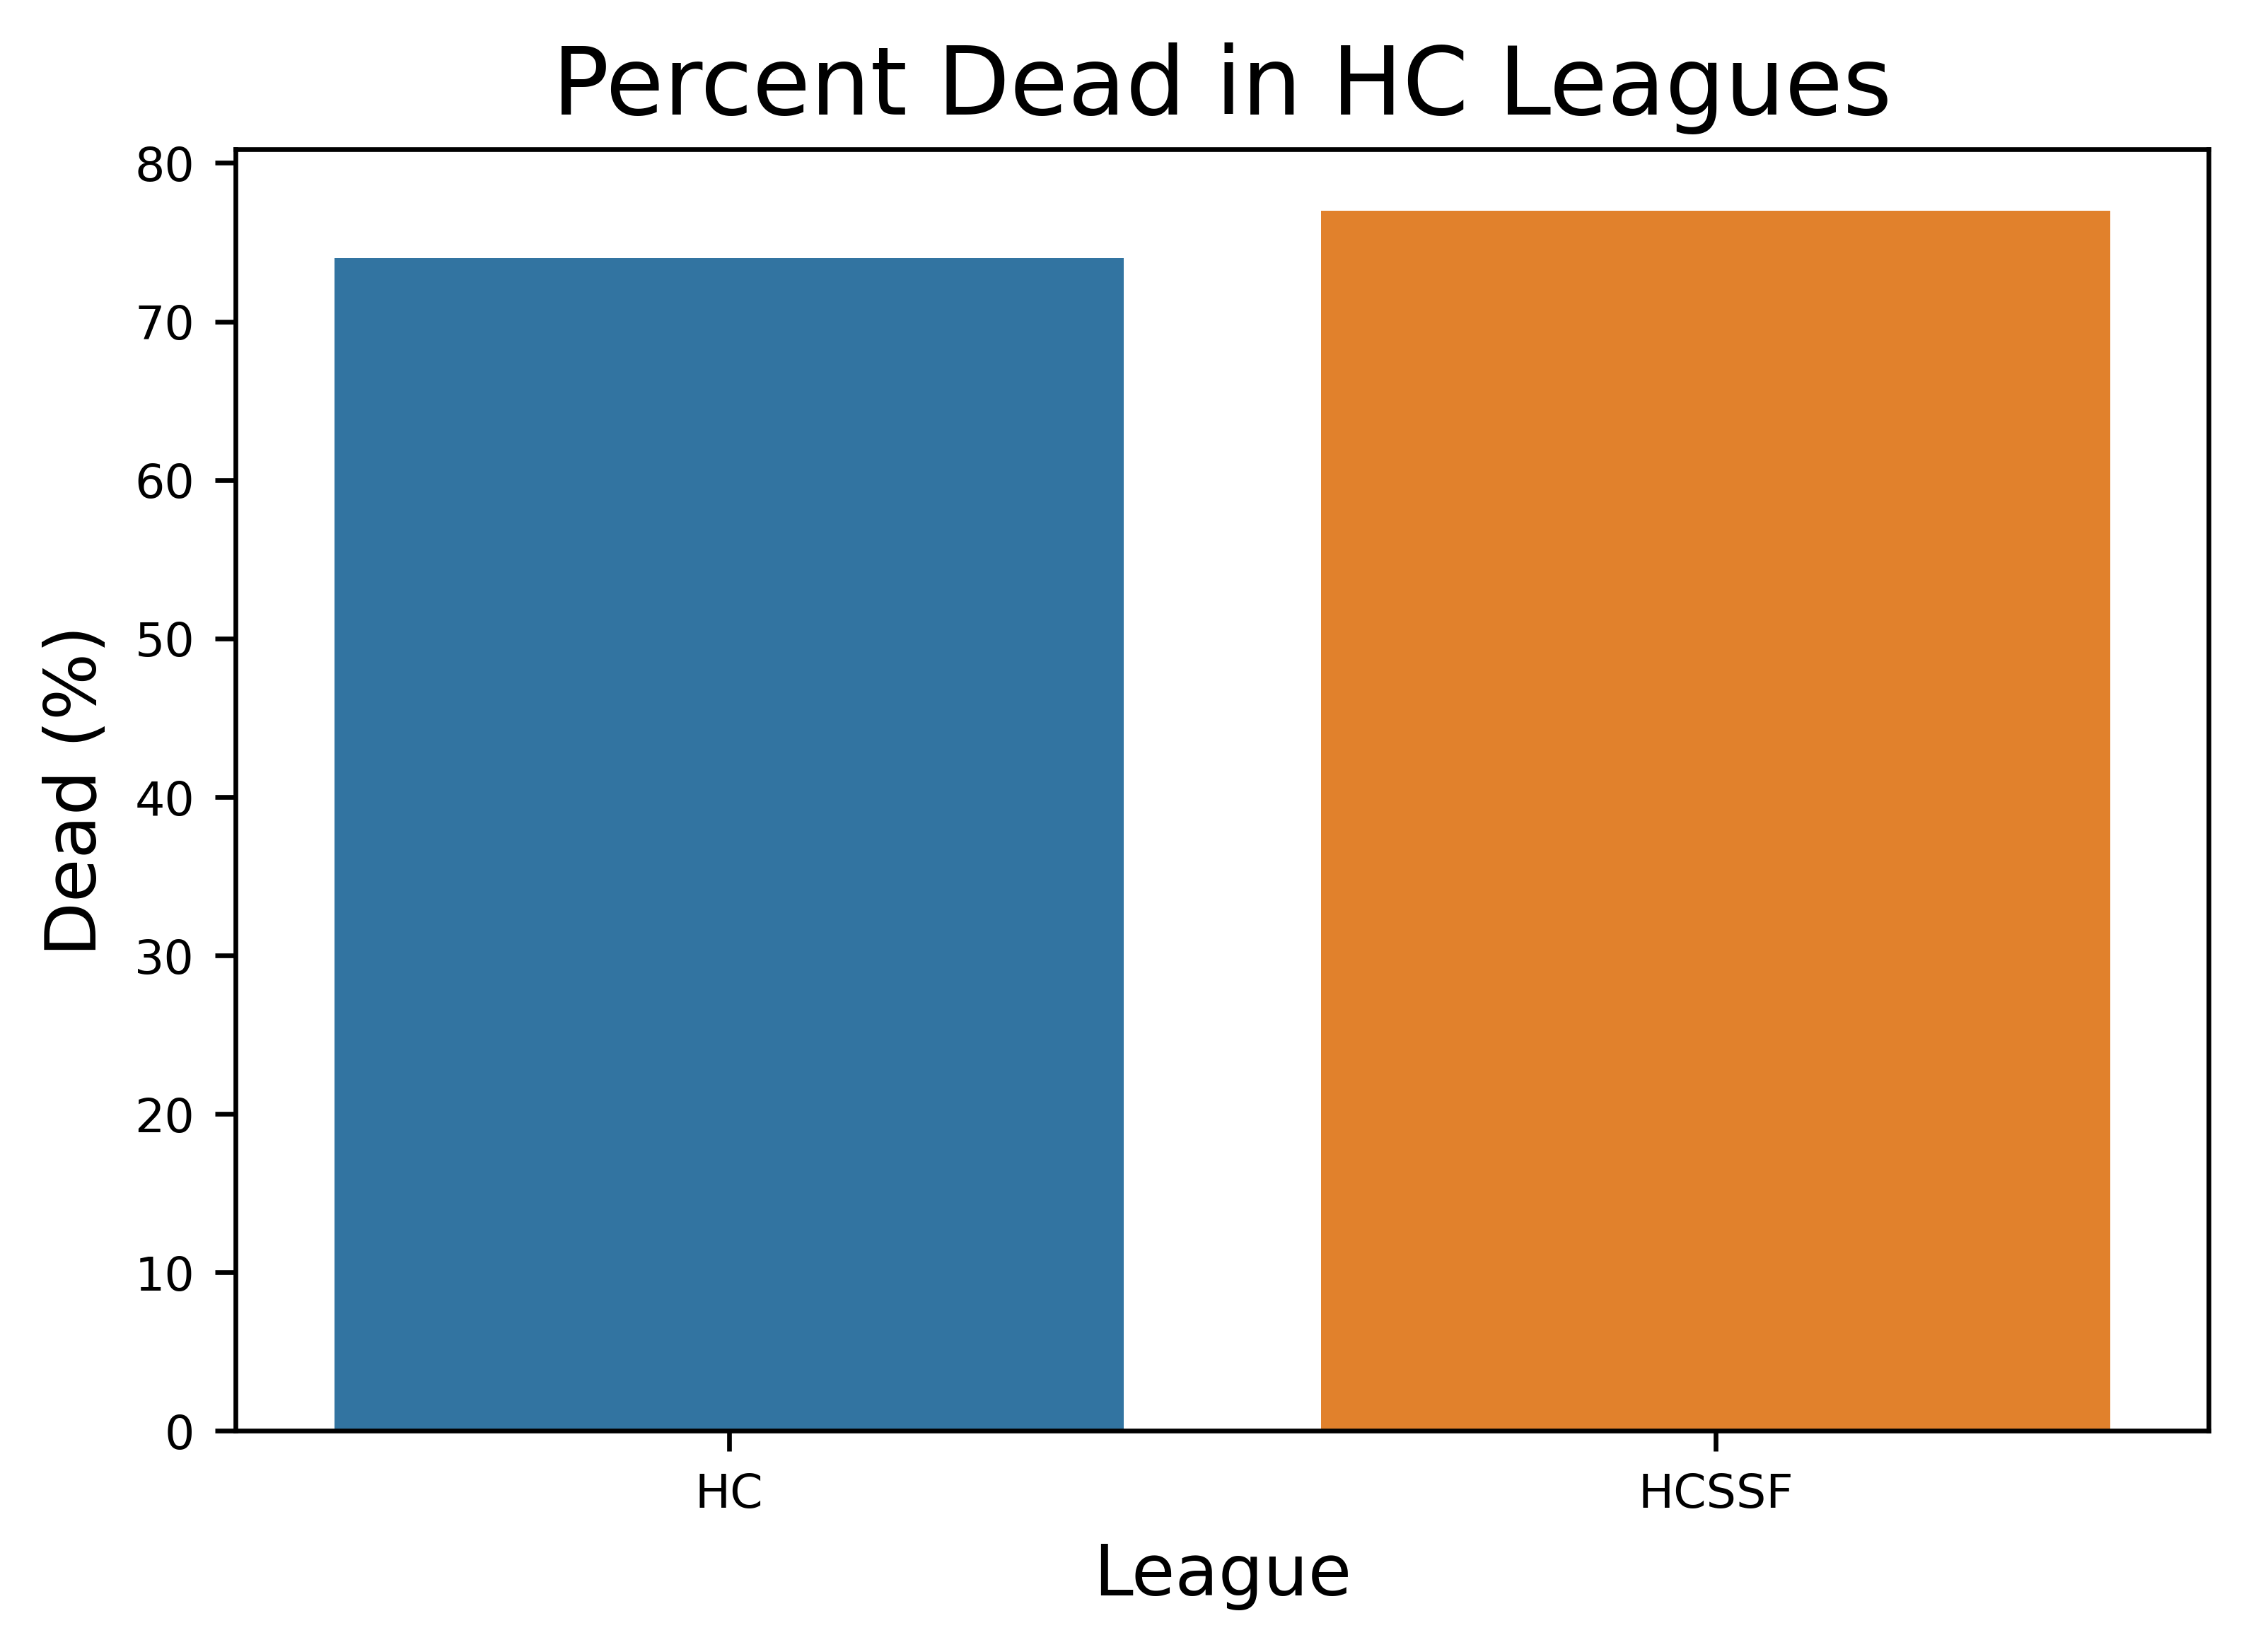

<Figure size 3600x2400 with 0 Axes>

In [41]:
hc_dead = 'select 100*count(*)/15000 as perc_dead_HC from HC where dead = 1'
hc_dead_df = pd.read_sql_query(hc_dead,conn)
hc_dead_df

hcssf_dead = 'select 100*count(*)/15000 as perc_dead_HCSSF from HCSSF where dead = 1'
hcssf_dead_df = pd.read_sql_query(hcssf_dead,conn)
hcssf_dead_df

hc_perc_dead = pd.concat([hc_dead_df,hcssf_dead_df], axis=1)
hc_perc_dead_graph = sns.barplot(data=hc_perc_dead)

plt.title(label = 'Percent Dead in HC Leagues', fontsize = 16)

plt.xlabel('League', fontsize = 12)
plt.xticks(ticks = [0,1], labels = ['HC','HCSSF'], fontsize = 8)

plt.ylabel('Dead (%)', fontsize = 12)
plt.yticks(fontsize = 8)

plt.figure(dpi=600)
plt.tight_layout()

Of the 19 ascendancies in Path of Exile, which are the most popular in each league that make it to 95+?

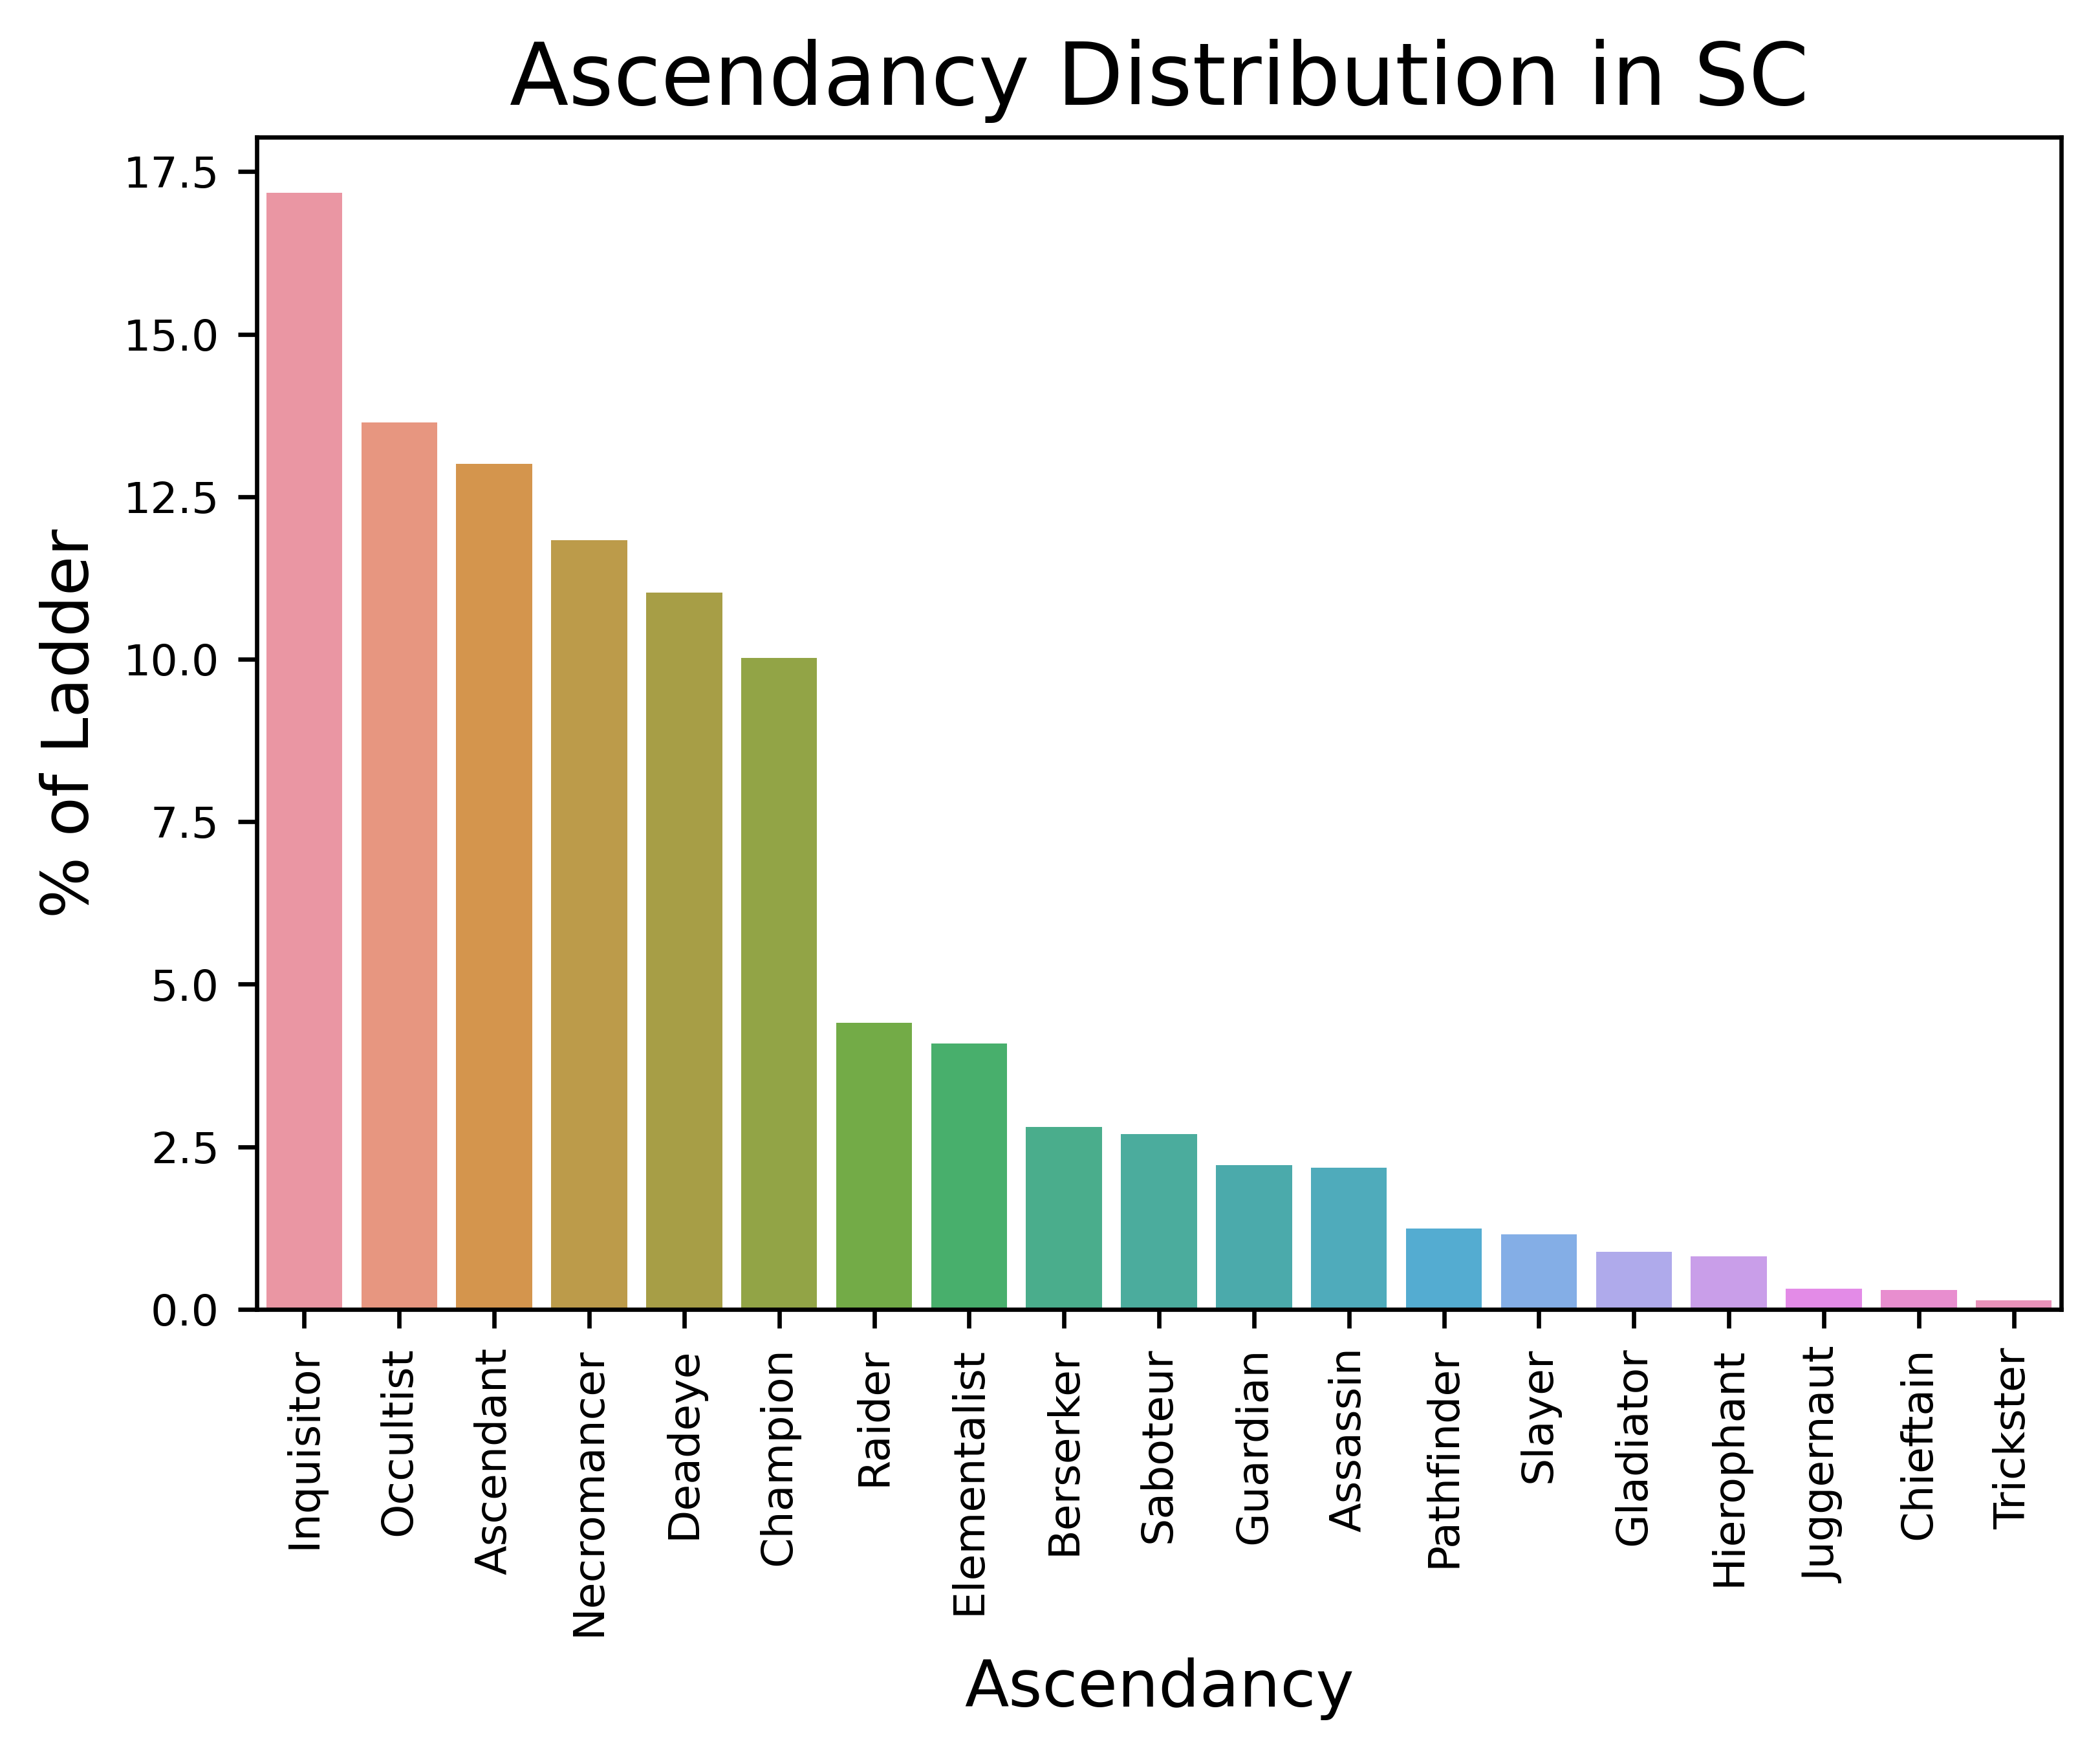

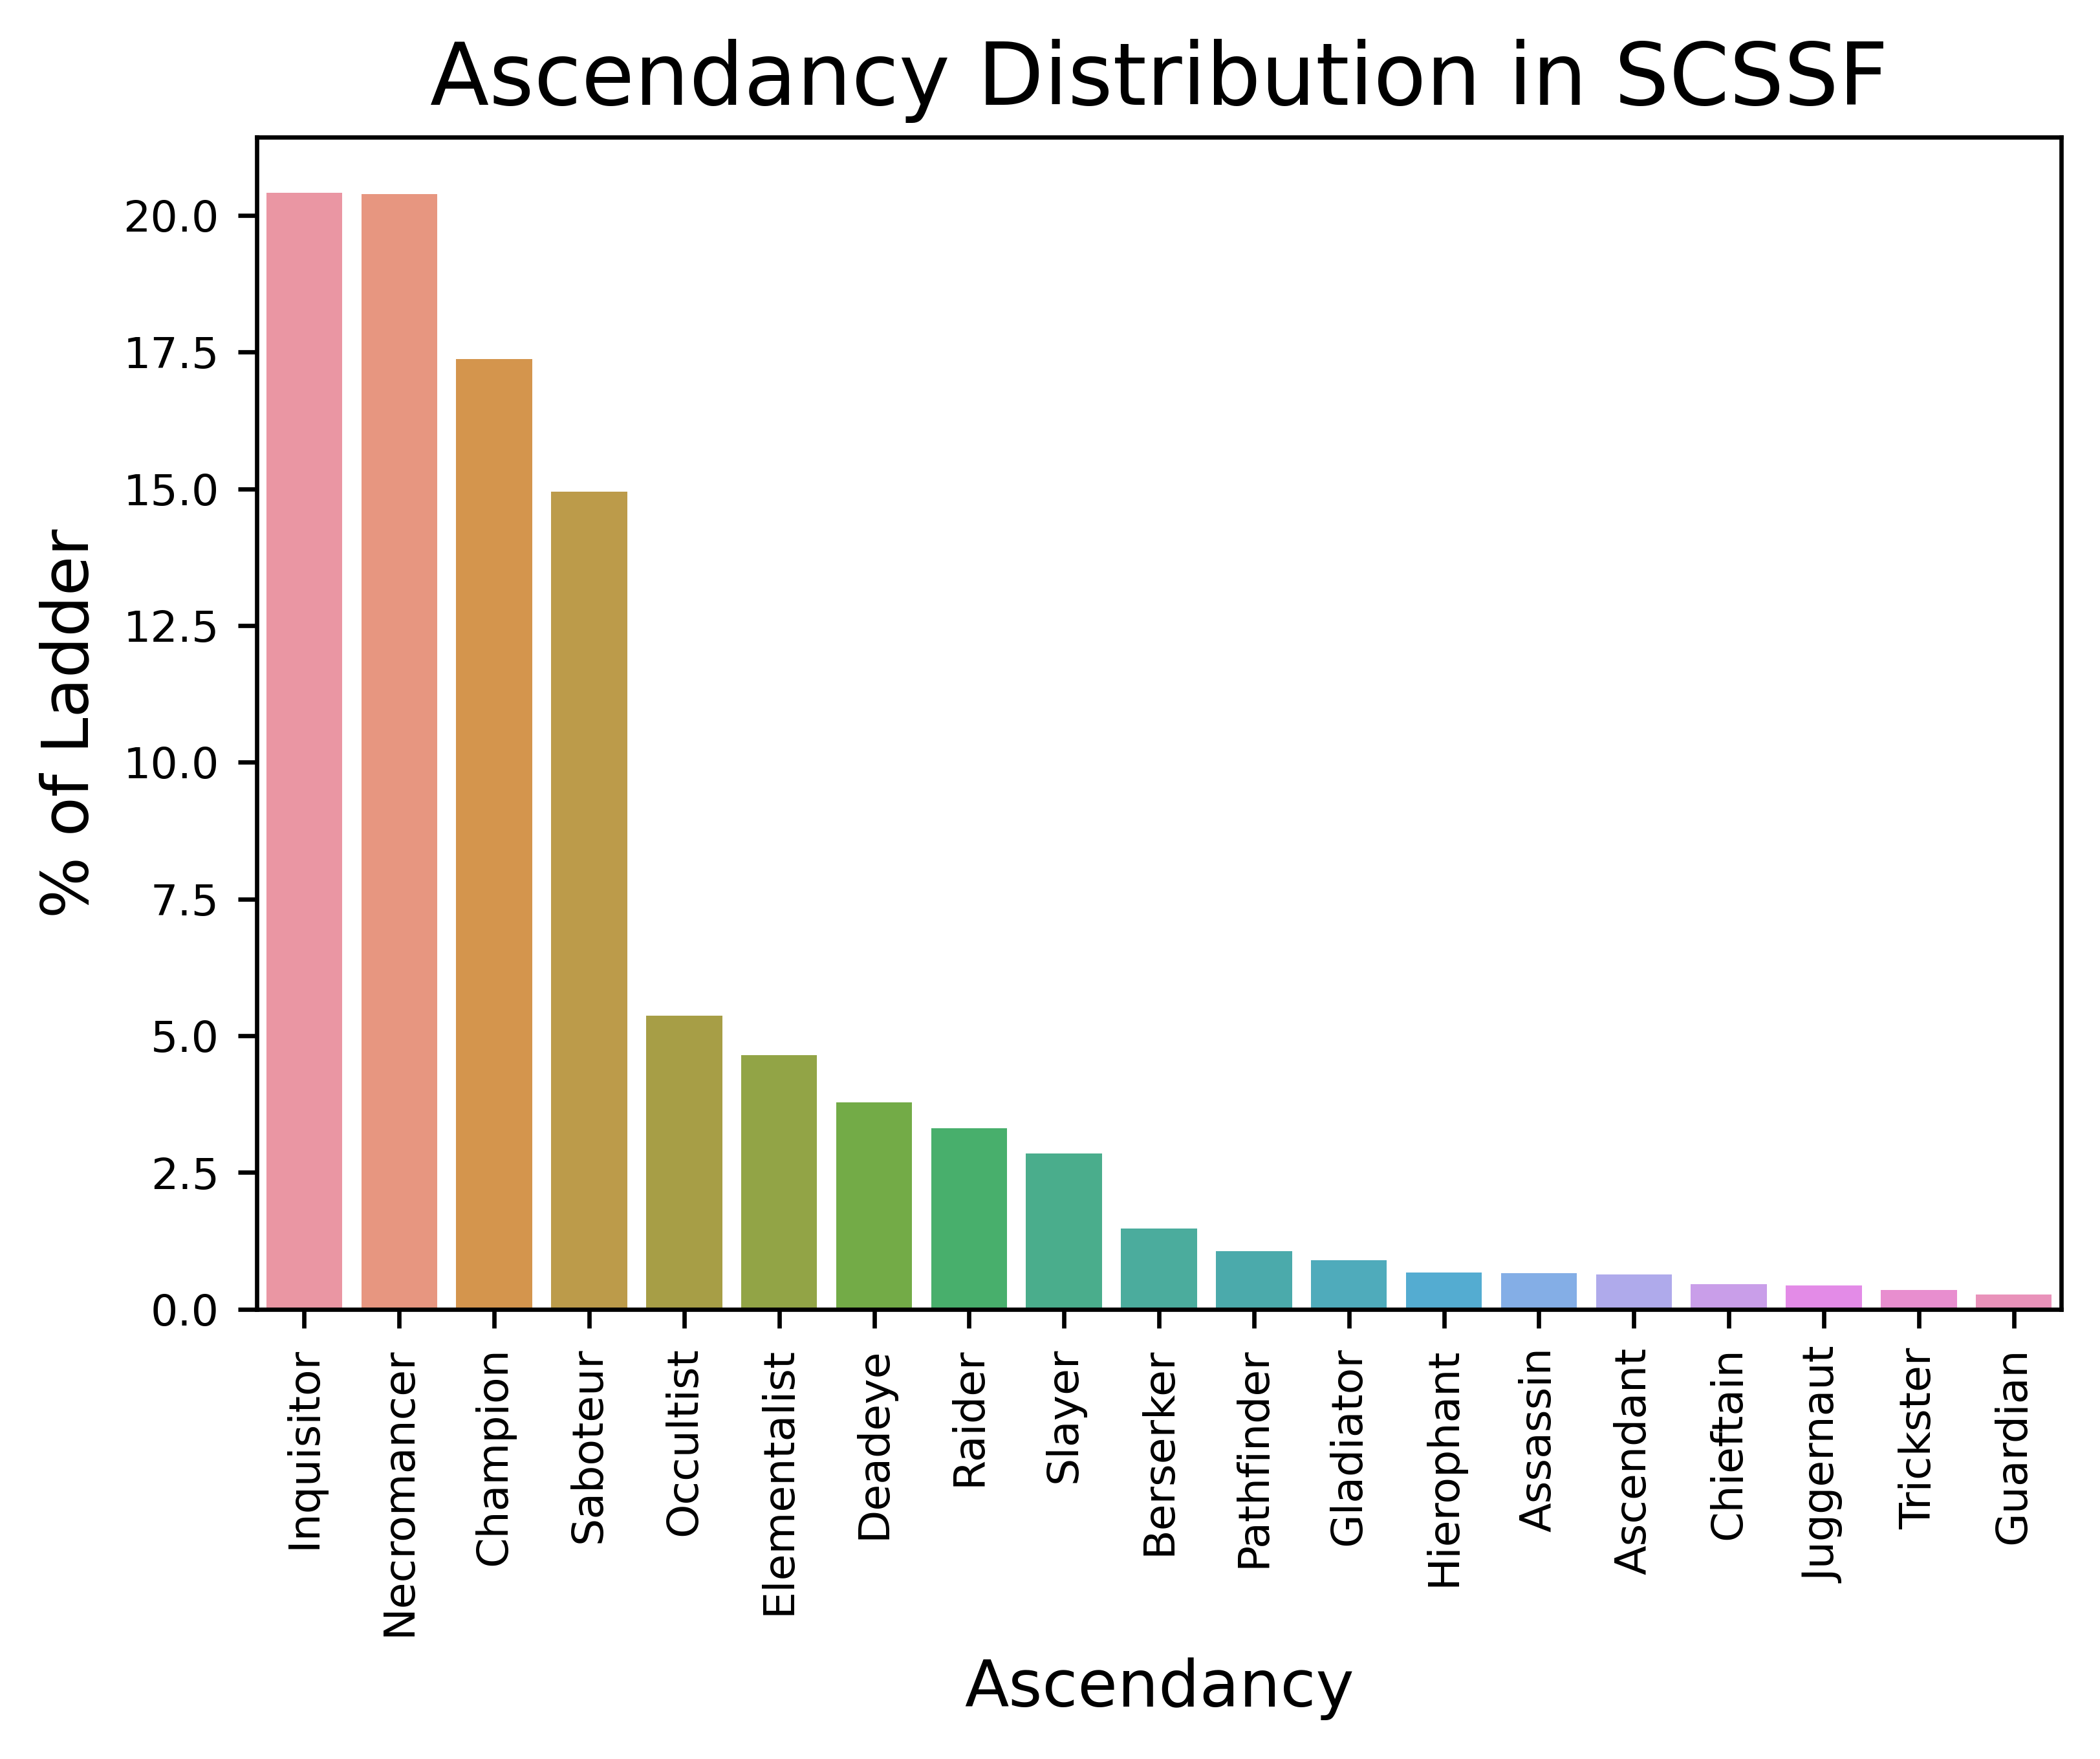

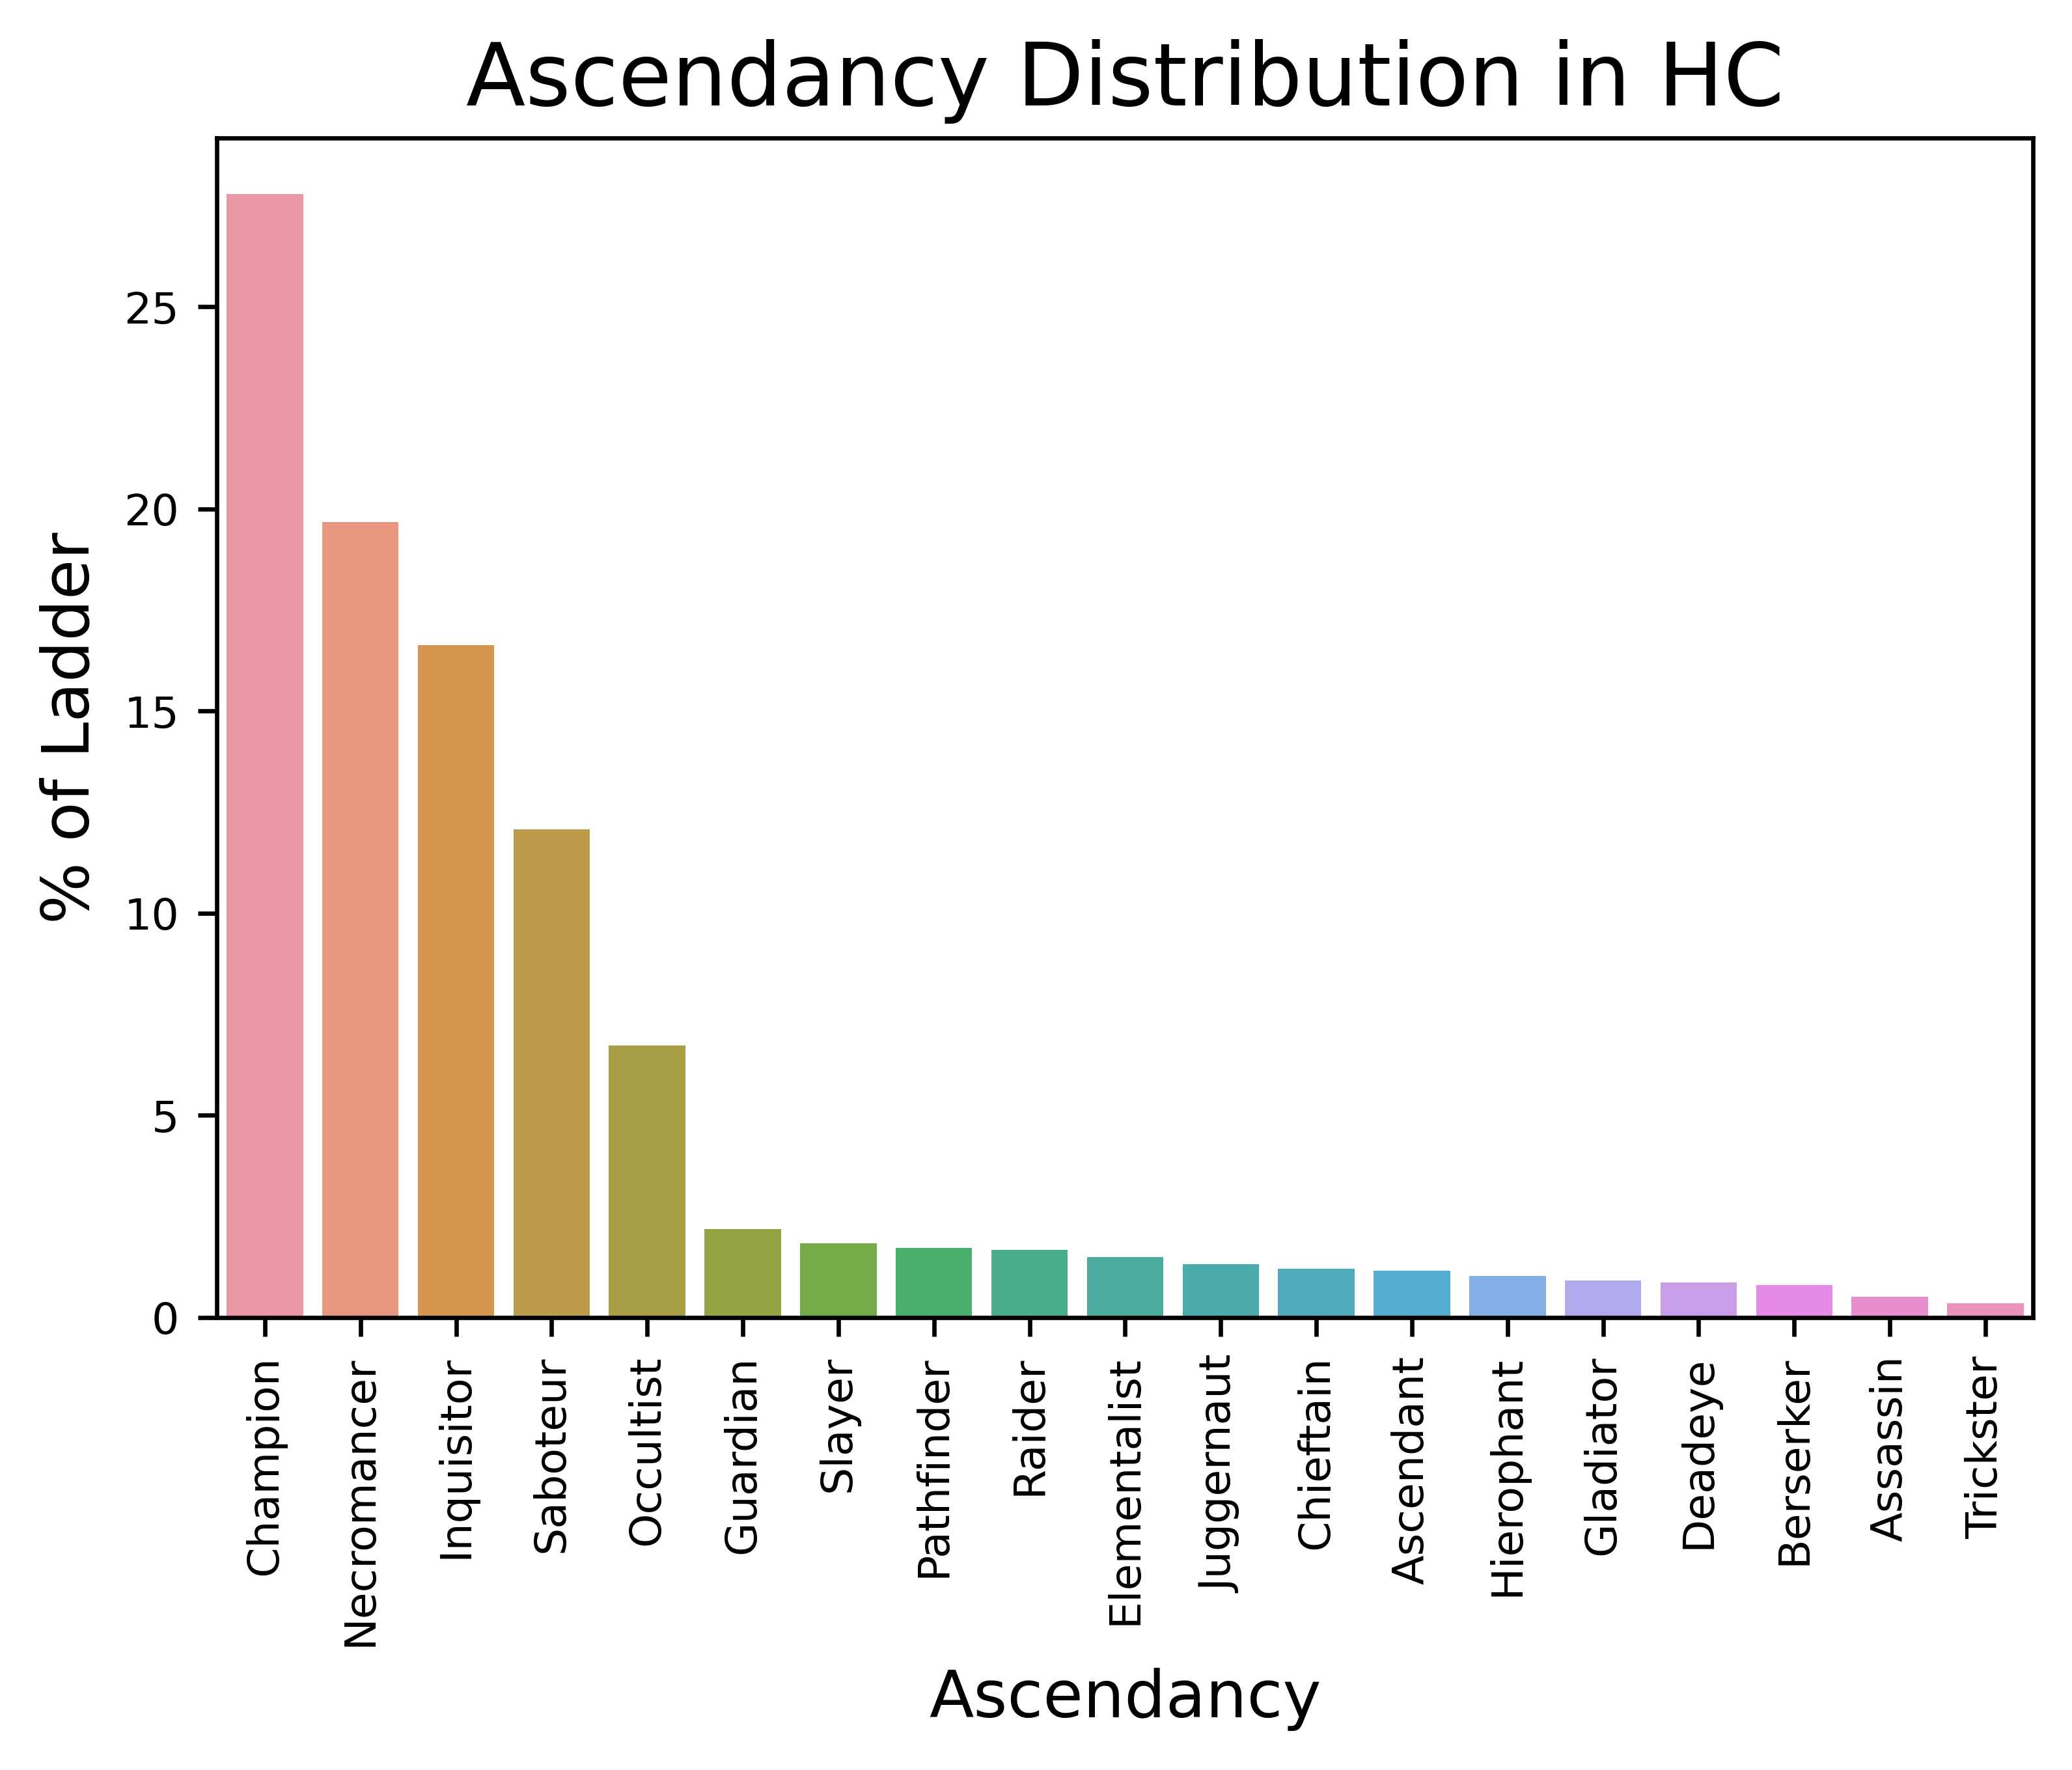

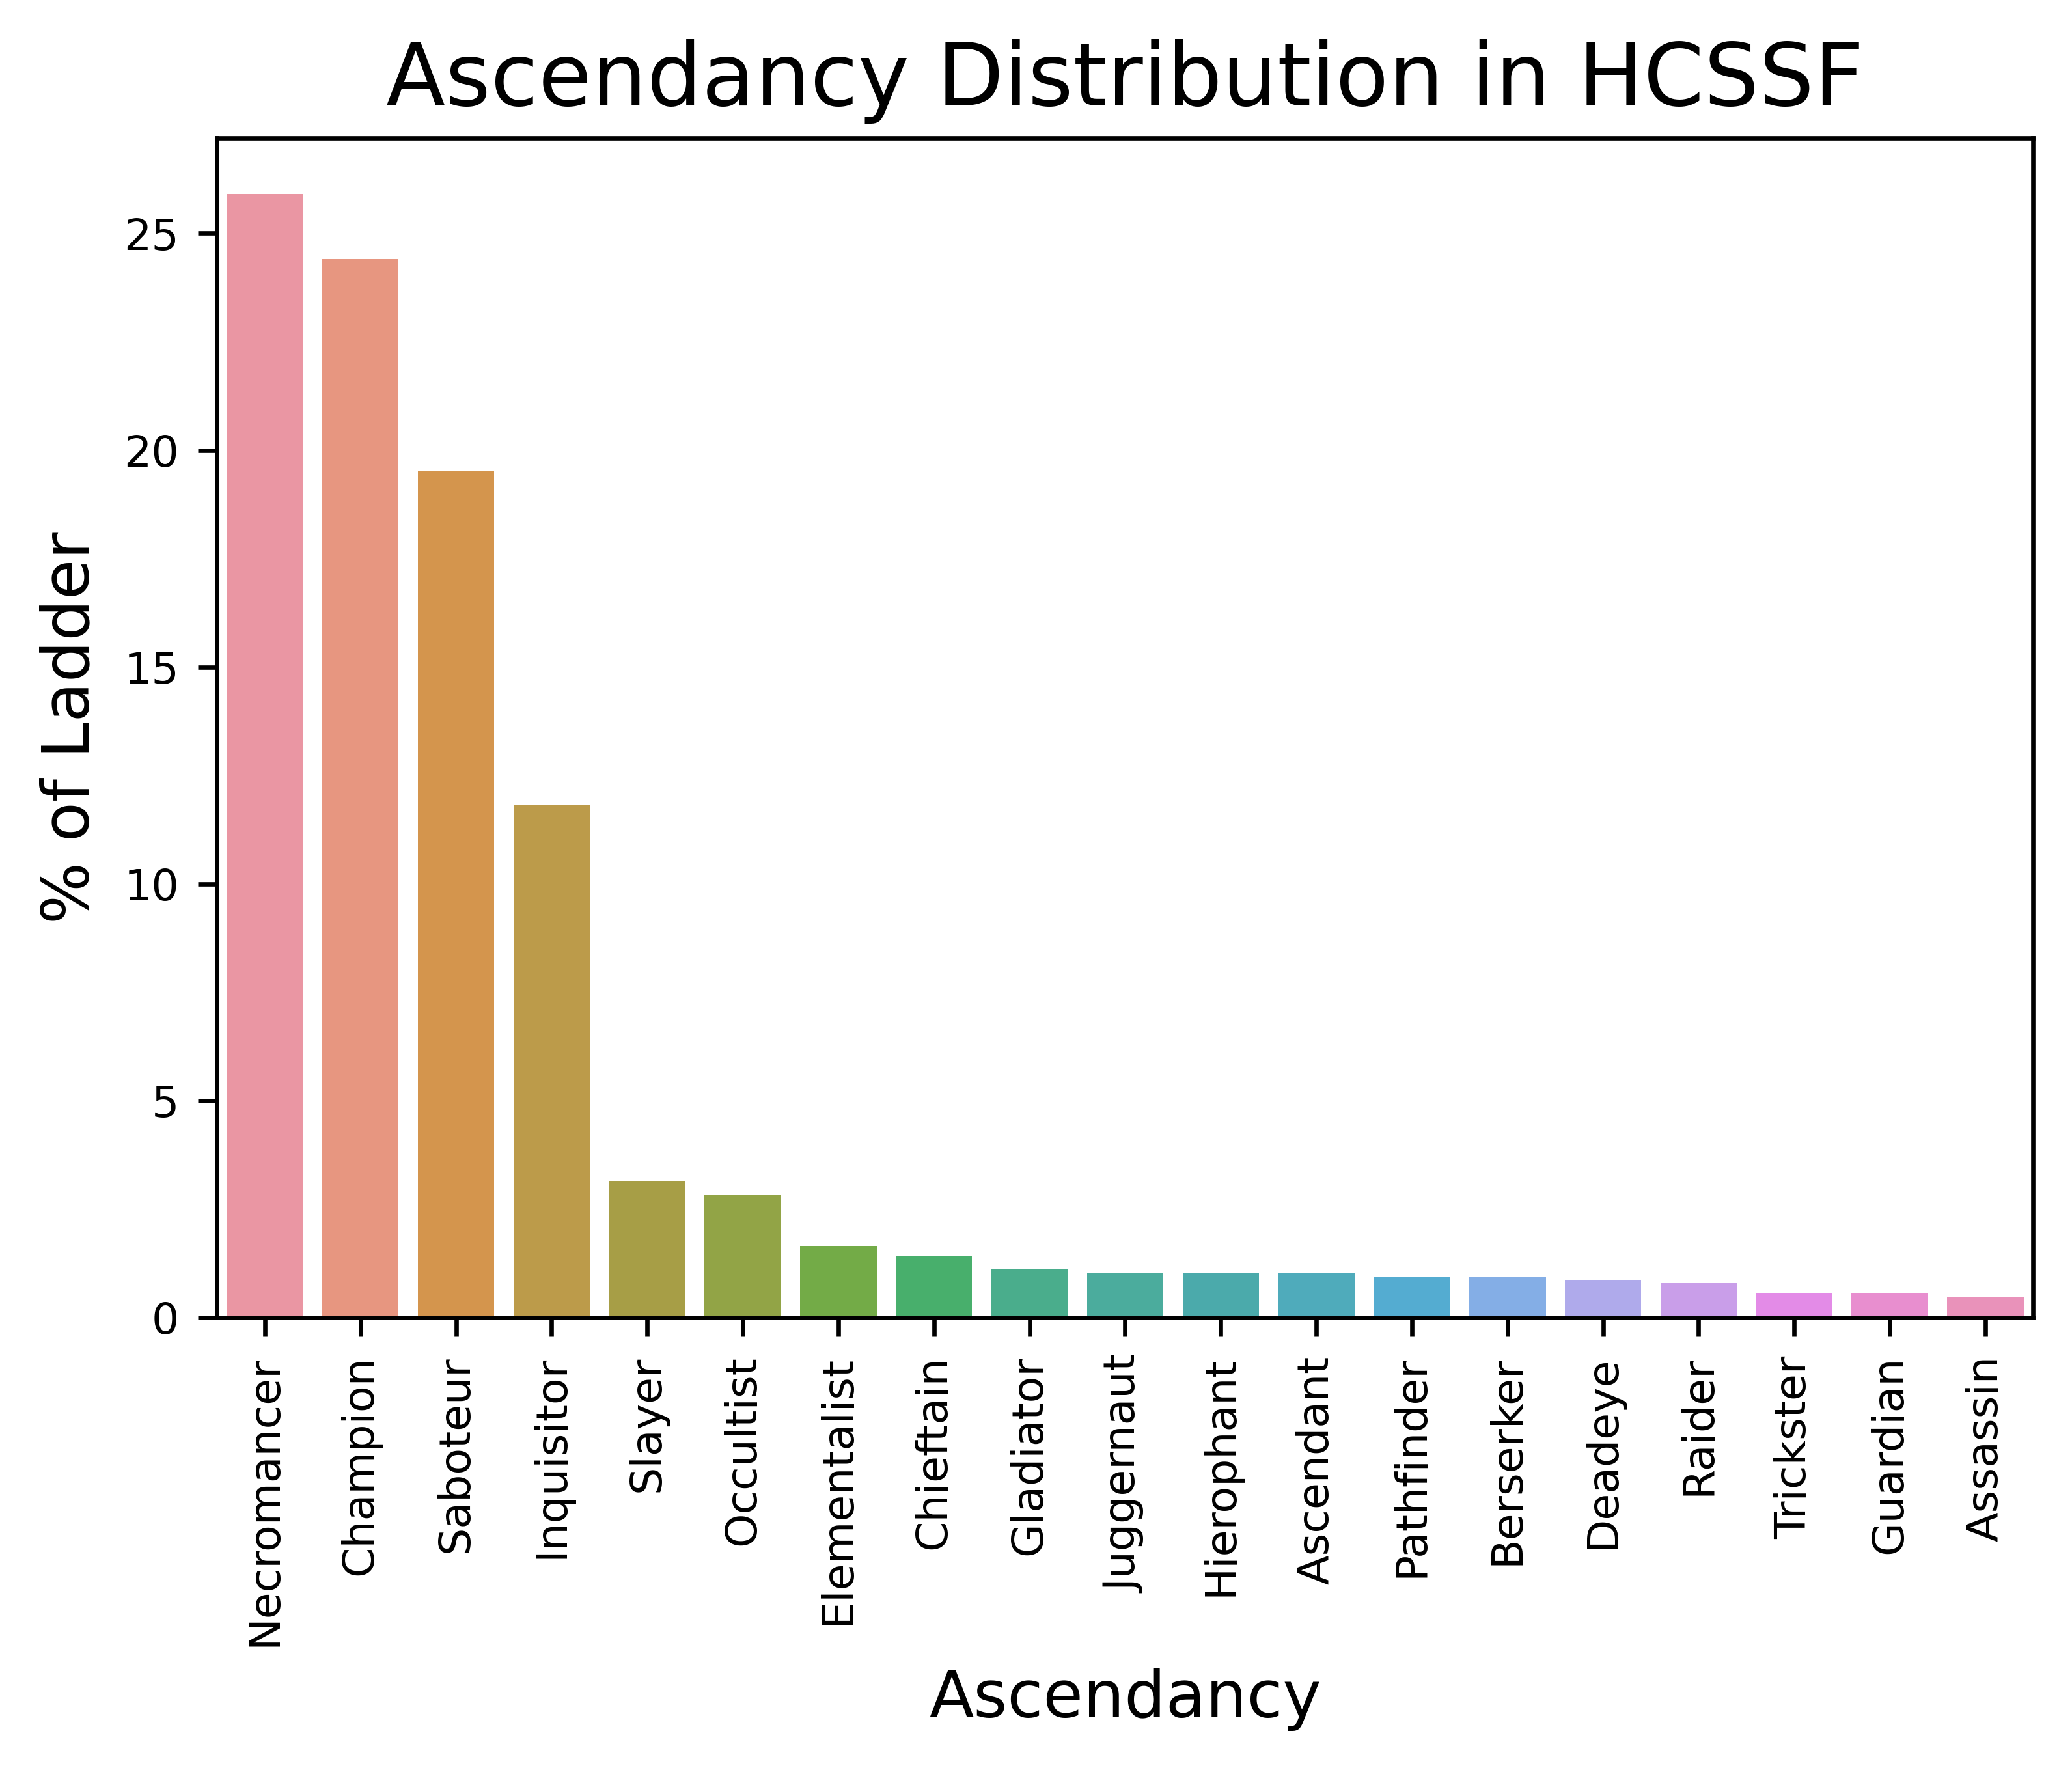

<Figure size 3600x2400 with 0 Axes>

In [42]:
sc_asc = 'select ascendancy,  100.0*sum(case when level>=95 then 1 else 0 end)/(select count(*) from SC where level>=95) as sc_asc_count from SC group by ascendancy order by sc_asc_count desc limit 19'
sc_ssf_asc = 'select ascendancy,  100.0*sum(case when level>=95 then 1 else 0 end)/(select count(*) from SCSSF where level>=95) as scssf_asc_count from SCSSF group by ascendancy order by scssf_asc_count desc limit 19'
hc_asc = 'select ascendancy,  100.0*sum(case when level>=95 then 1 else 0 end)/(select count(*) from HC where level>=95) as hc_asc_count from  HC group by ascendancy order by hc_asc_count desc limit 19'
hc_ssf_asc = 'select ascendancy,  100.0*sum(case when level>=95 then 1 else 0 end)/(select count(*) from HCSSF where level>=95) as hcssf_asc_count from HCSSF group by ascendancy order by hcssf_asc_count desc limit 19'


scasc_df = pd.read_sql_query(sc_asc, conn)
scssf_asc_df = pd.read_sql_query(sc_ssf_asc, conn)
hc_asc_df = pd.read_sql_query(hc_asc, conn)
hcssf_asc_df = pd.read_sql_query(hc_ssf_asc, conn)

scasc_graph = sns.barplot(data=scasc_df, x='ascendancy',y='sc_asc_count')
plt.title(label = 'Ascendancy Distribution in SC', fontsize = 16)

plt.xlabel('Ascendancy', fontsize = 12)
plt.xticks(rotation=90, fontsize = 8)

plt.ylabel('% of Ladder', fontsize = 12)
plt.yticks(fontsize = 8)

plt.figure(dpi=600)
plt.tight_layout()

scssf_asc_graph = sns.barplot(data=scssf_asc_df, x='ascendancy',y='scssf_asc_count')
plt.title(label = 'Ascendancy Distribution in SCSSF', fontsize = 16)

plt.xlabel('Ascendancy', fontsize = 12)
plt.xticks(rotation=90, fontsize = 8)

plt.ylabel('% of Ladder', fontsize = 12)
plt.yticks(fontsize = 8)

plt.figure(dpi=600)
plt.tight_layout()

hc_asc_graph = sns.barplot(data=hc_asc_df, x='ascendancy',y='hc_asc_count')
plt.title(label = 'Ascendancy Distribution in HC', fontsize = 16)

plt.xlabel('Ascendancy', fontsize = 12)
plt.xticks(rotation=90, fontsize = 8)

plt.ylabel('% of Ladder', fontsize = 12)
plt.yticks(fontsize = 8)

plt.figure(dpi=600)
plt.tight_layout()

hcssf_asc_graph = sns.barplot(data=hcssf_asc_df, x='ascendancy',y='hcssf_asc_count')
plt.title(label = 'Ascendancy Distribution in HCSSF', fontsize = 16)

plt.xlabel('Ascendancy', fontsize = 12)
plt.xticks(rotation=90, fontsize = 8)

plt.ylabel('% of Ladder', fontsize = 12)
plt.yticks(fontsize = 8)

plt.figure(dpi=600)
plt.tight_layout()


How many SC trade players have 38 challenges vs 40? There are no significant reward difference from 38 vs 40 challenges

In [17]:
challenge38 = 'select count(*) as num_38_challenge from sc where challenges=38'
challenge38_df = pd.read_sql_query(challenge38, conn)

challenge40 = 'select count(*) as num_40_challenge from sc where challenges=40'
challenge40_df = pd.read_sql_query(challenge40, conn)

challenge_38_40 = pd.concat([challenge38_df,challenge40_df],axis=1)
challenge_38_40

,num_38_challenge,num_40_challenge
0,1317,1636


List all details about the players who have 40 challenges on HCSSF who have a solo depth at 600 above, a requirement for a challenge.

In [18]:
challenge_hcssf = 'select * from hcssf where challenges>=40 and solo_depth>=60 group by account_name order by rank'
challenge_hcssf_df = pd.read_sql_query(challenge_hcssf, conn)
challenge_hcssf_df

,index,rank,level,ascendancy,character_name,account_name,experience,challenges,league_depth,solo_depth,dead,migrated,profile
0,0,1,100,Champion,Ben_BoneshatterBossing,Darkee,4250334444,40,975.0,975.0,1,0,public
1,2107,2108,93,Assassin,assssssssssssss,bearpub,2464652661,40,136.0,136.0,1,0,public
2,3850,3851,90,Inquisitor,WhereIsMyPayToWinButton,TotalQlimax,1942096362,40,78.0,78.0,0,0,public
3,7532,7533,83,Chieftain,最后救一下酋长,xiaoxiami,1169575379,40,67.0,67.0,1,0,public


Visualize the number of challenges across the four ladders

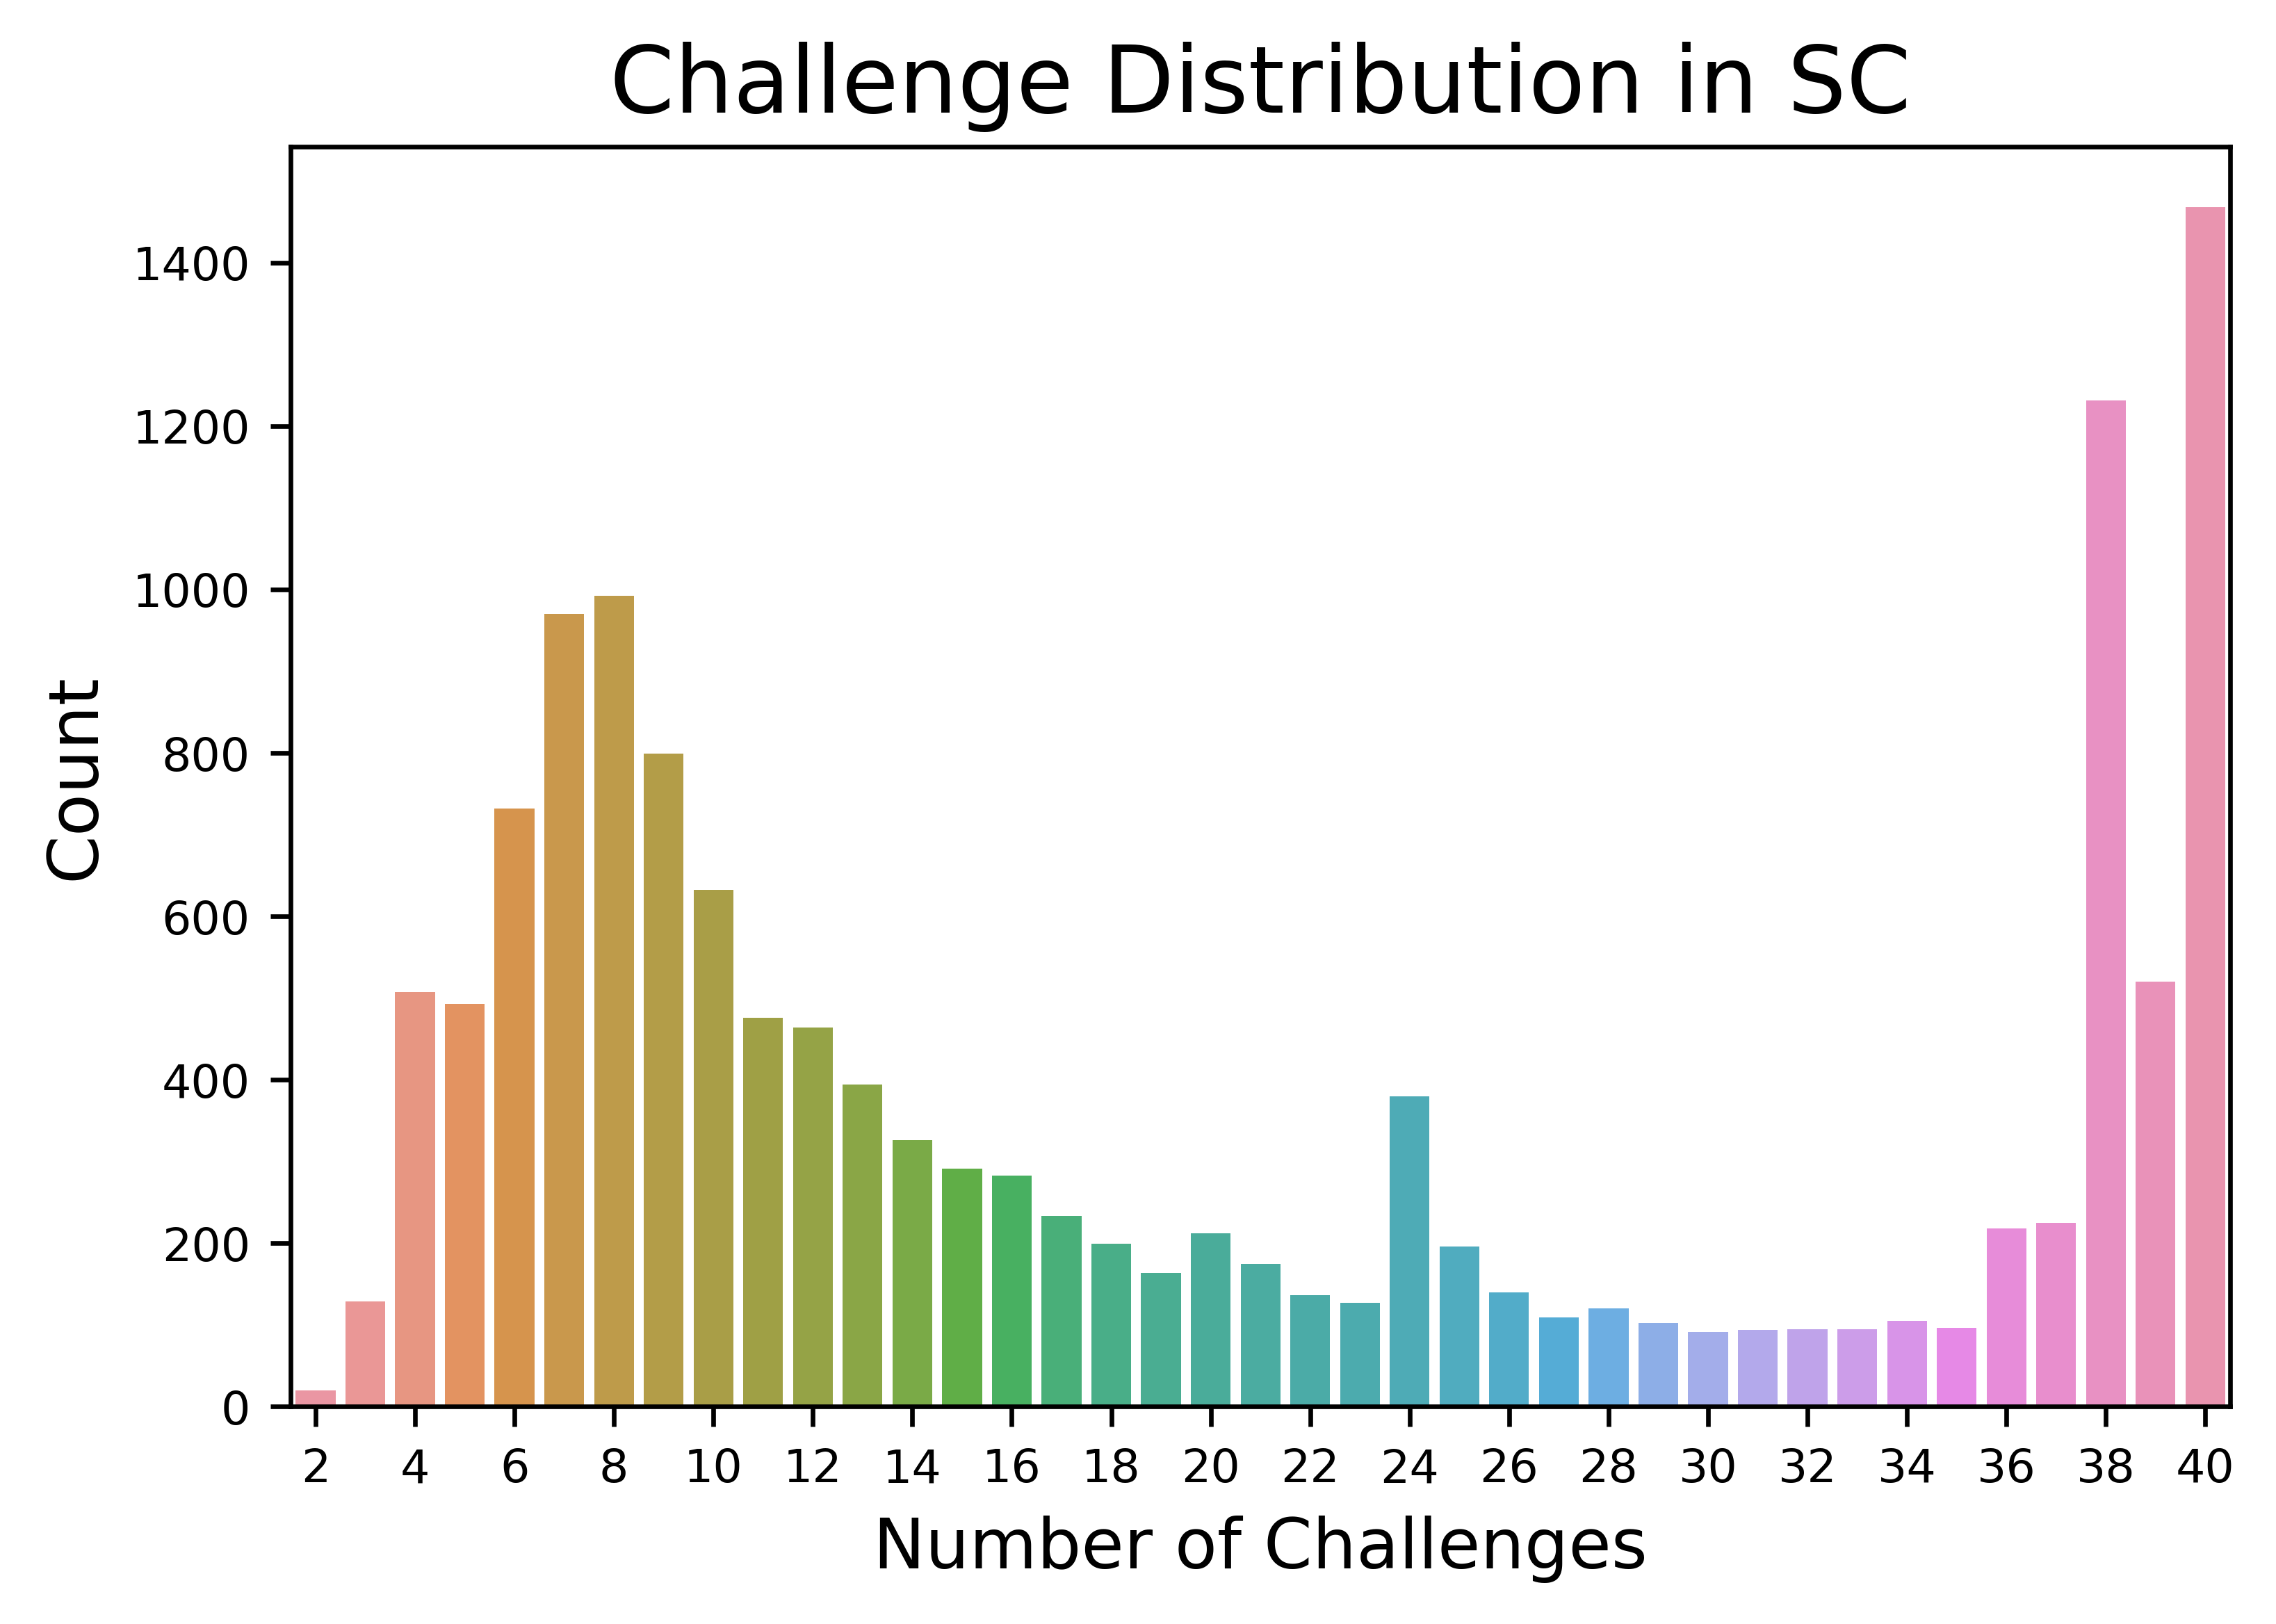

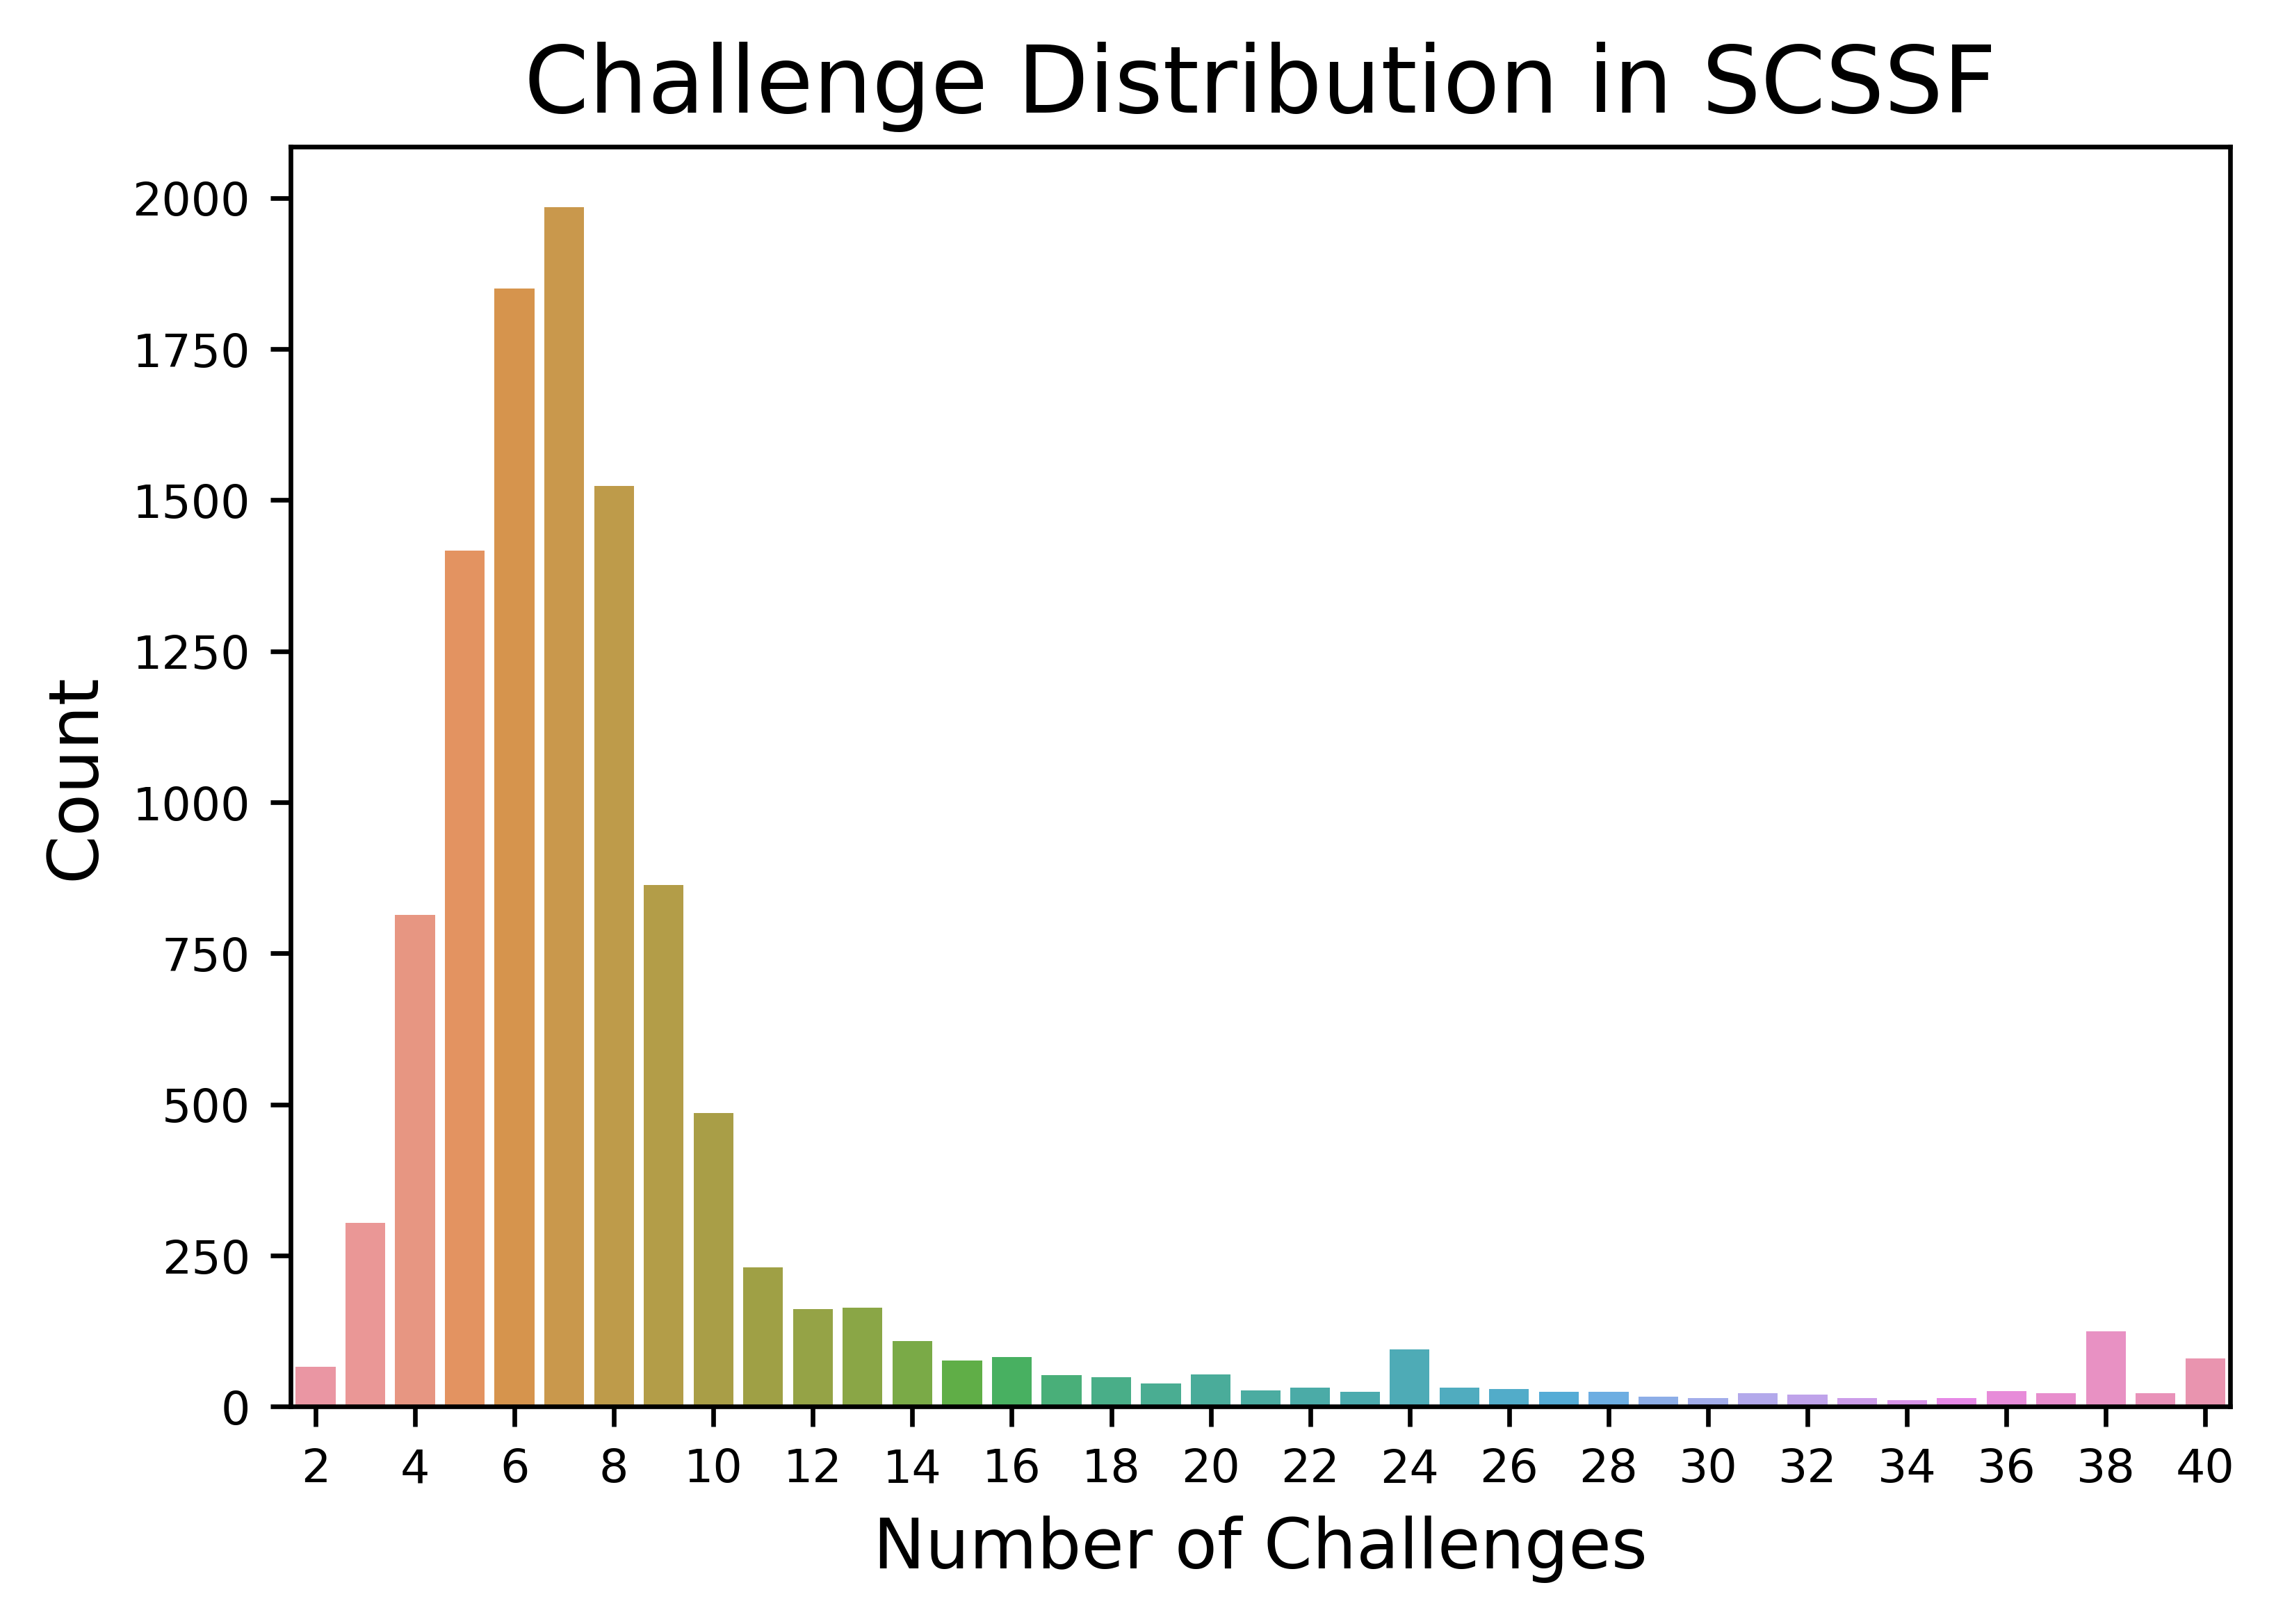

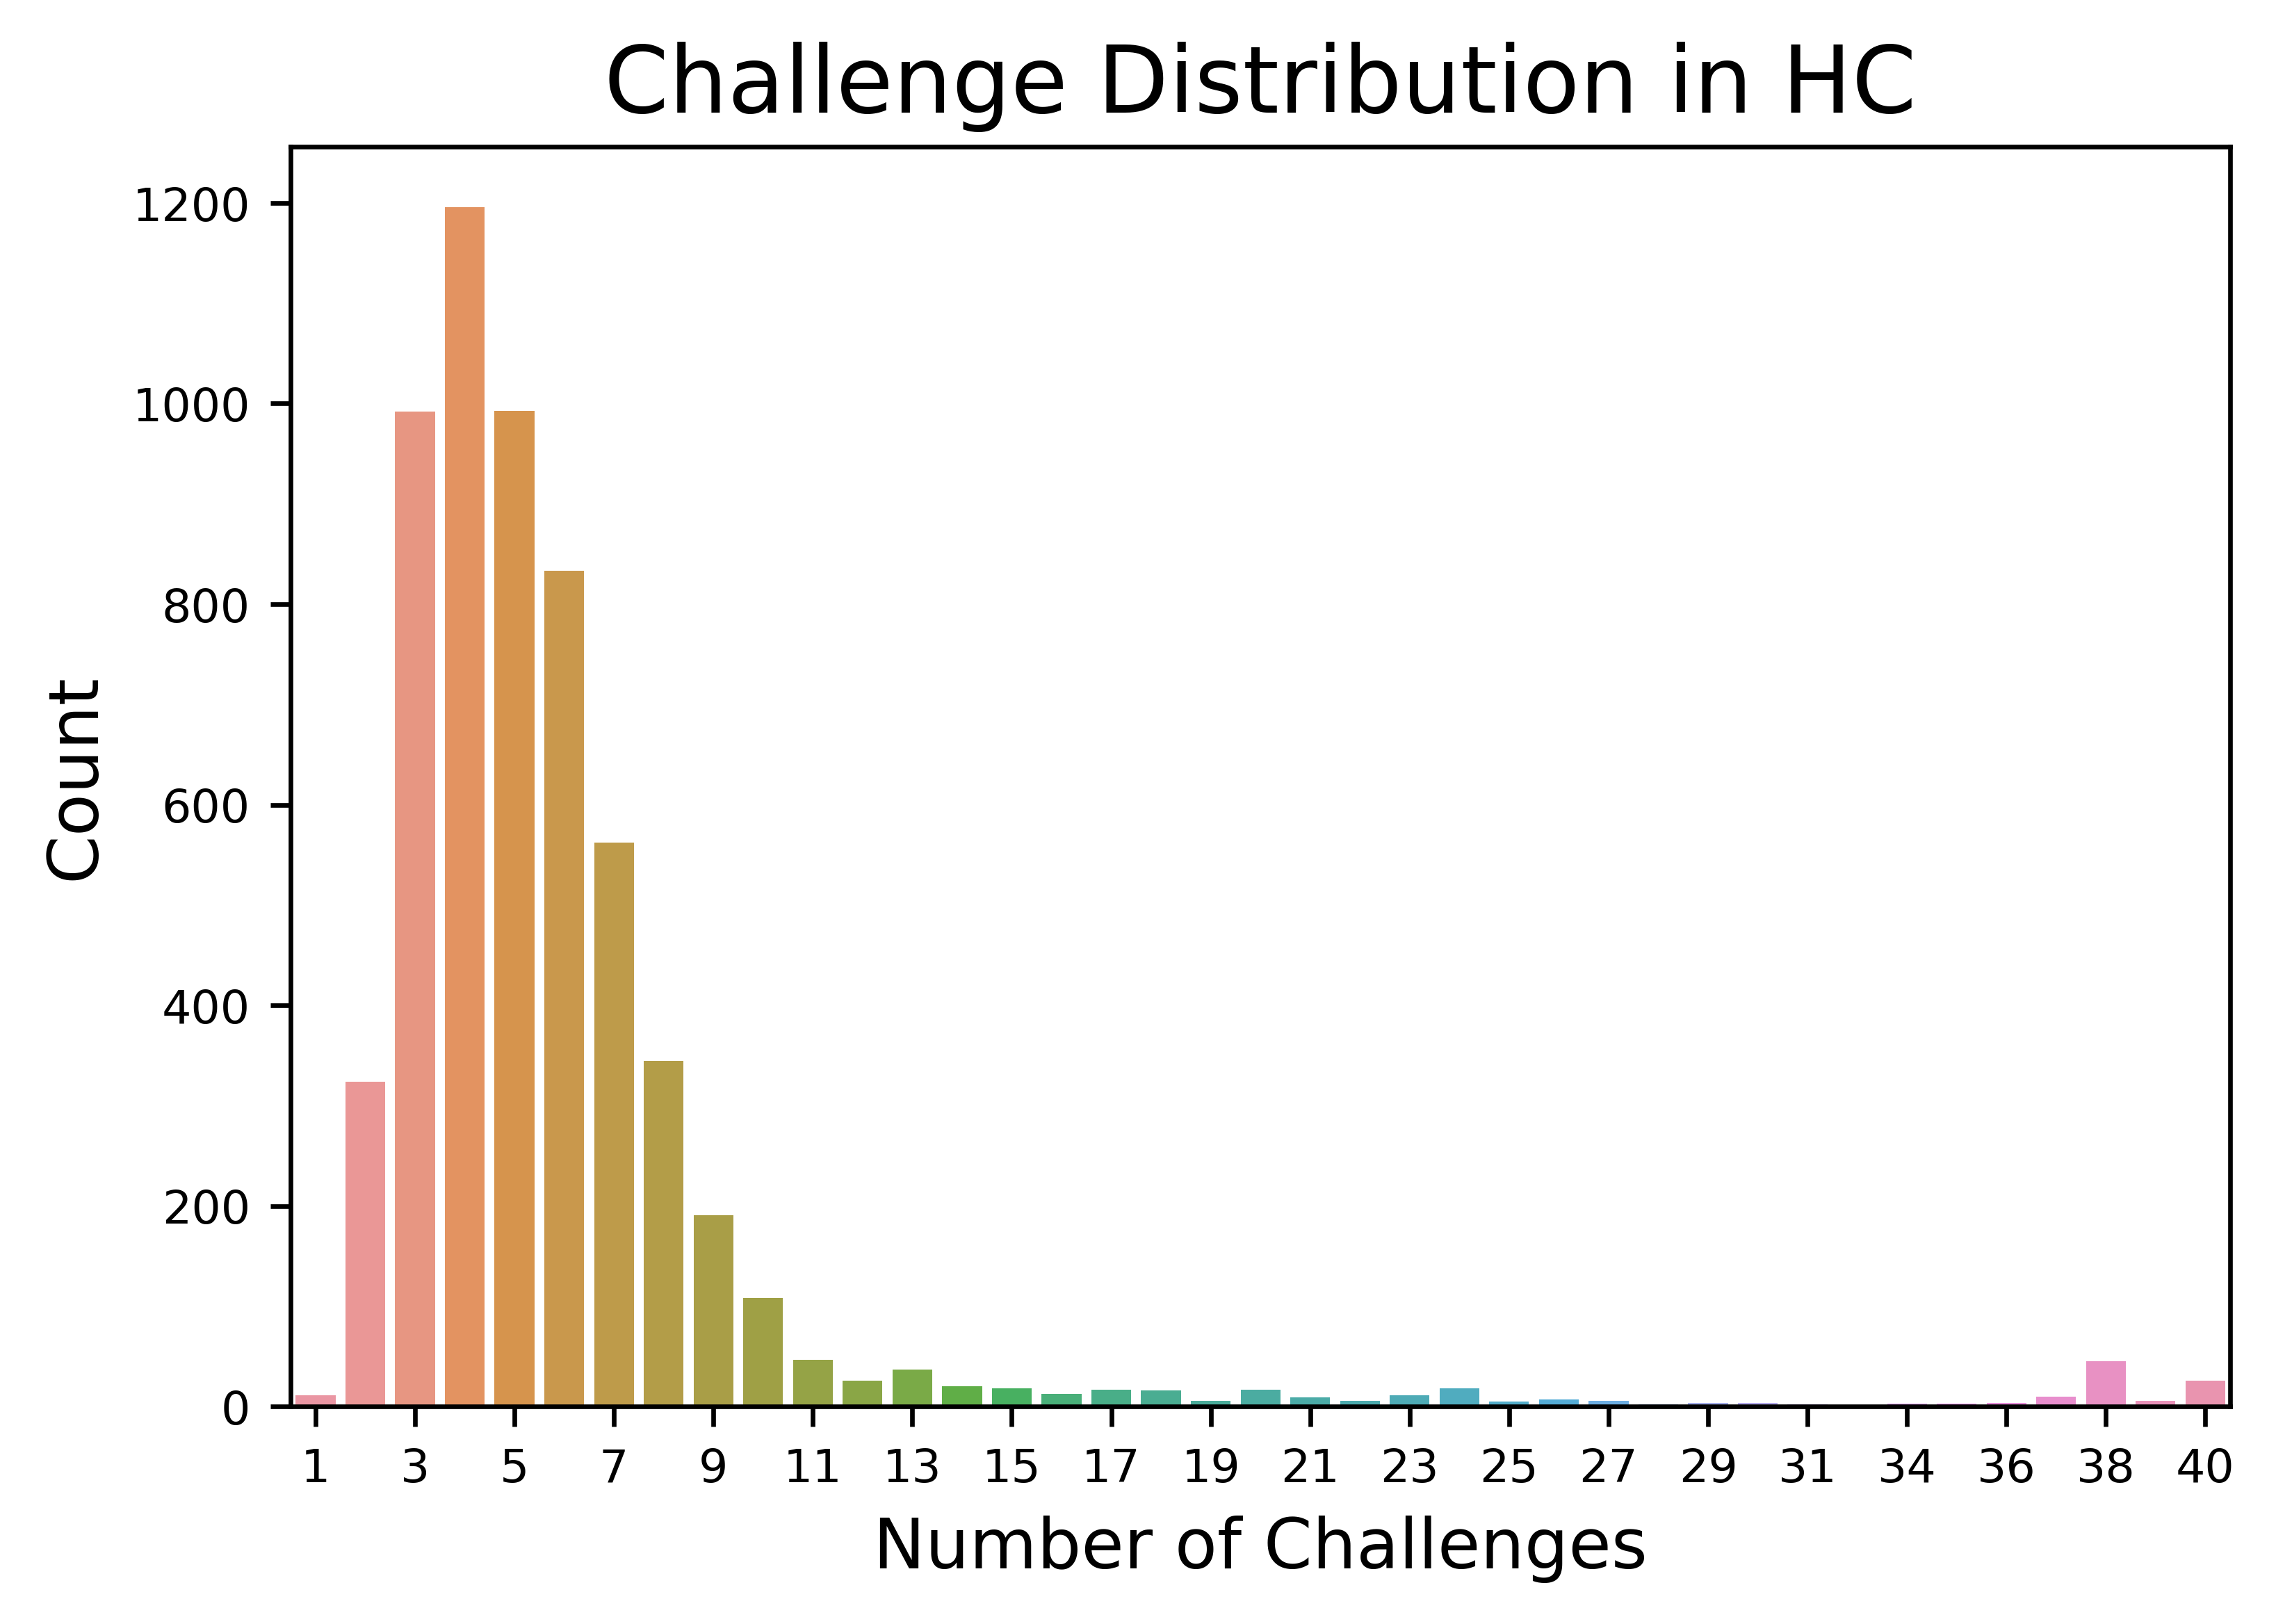

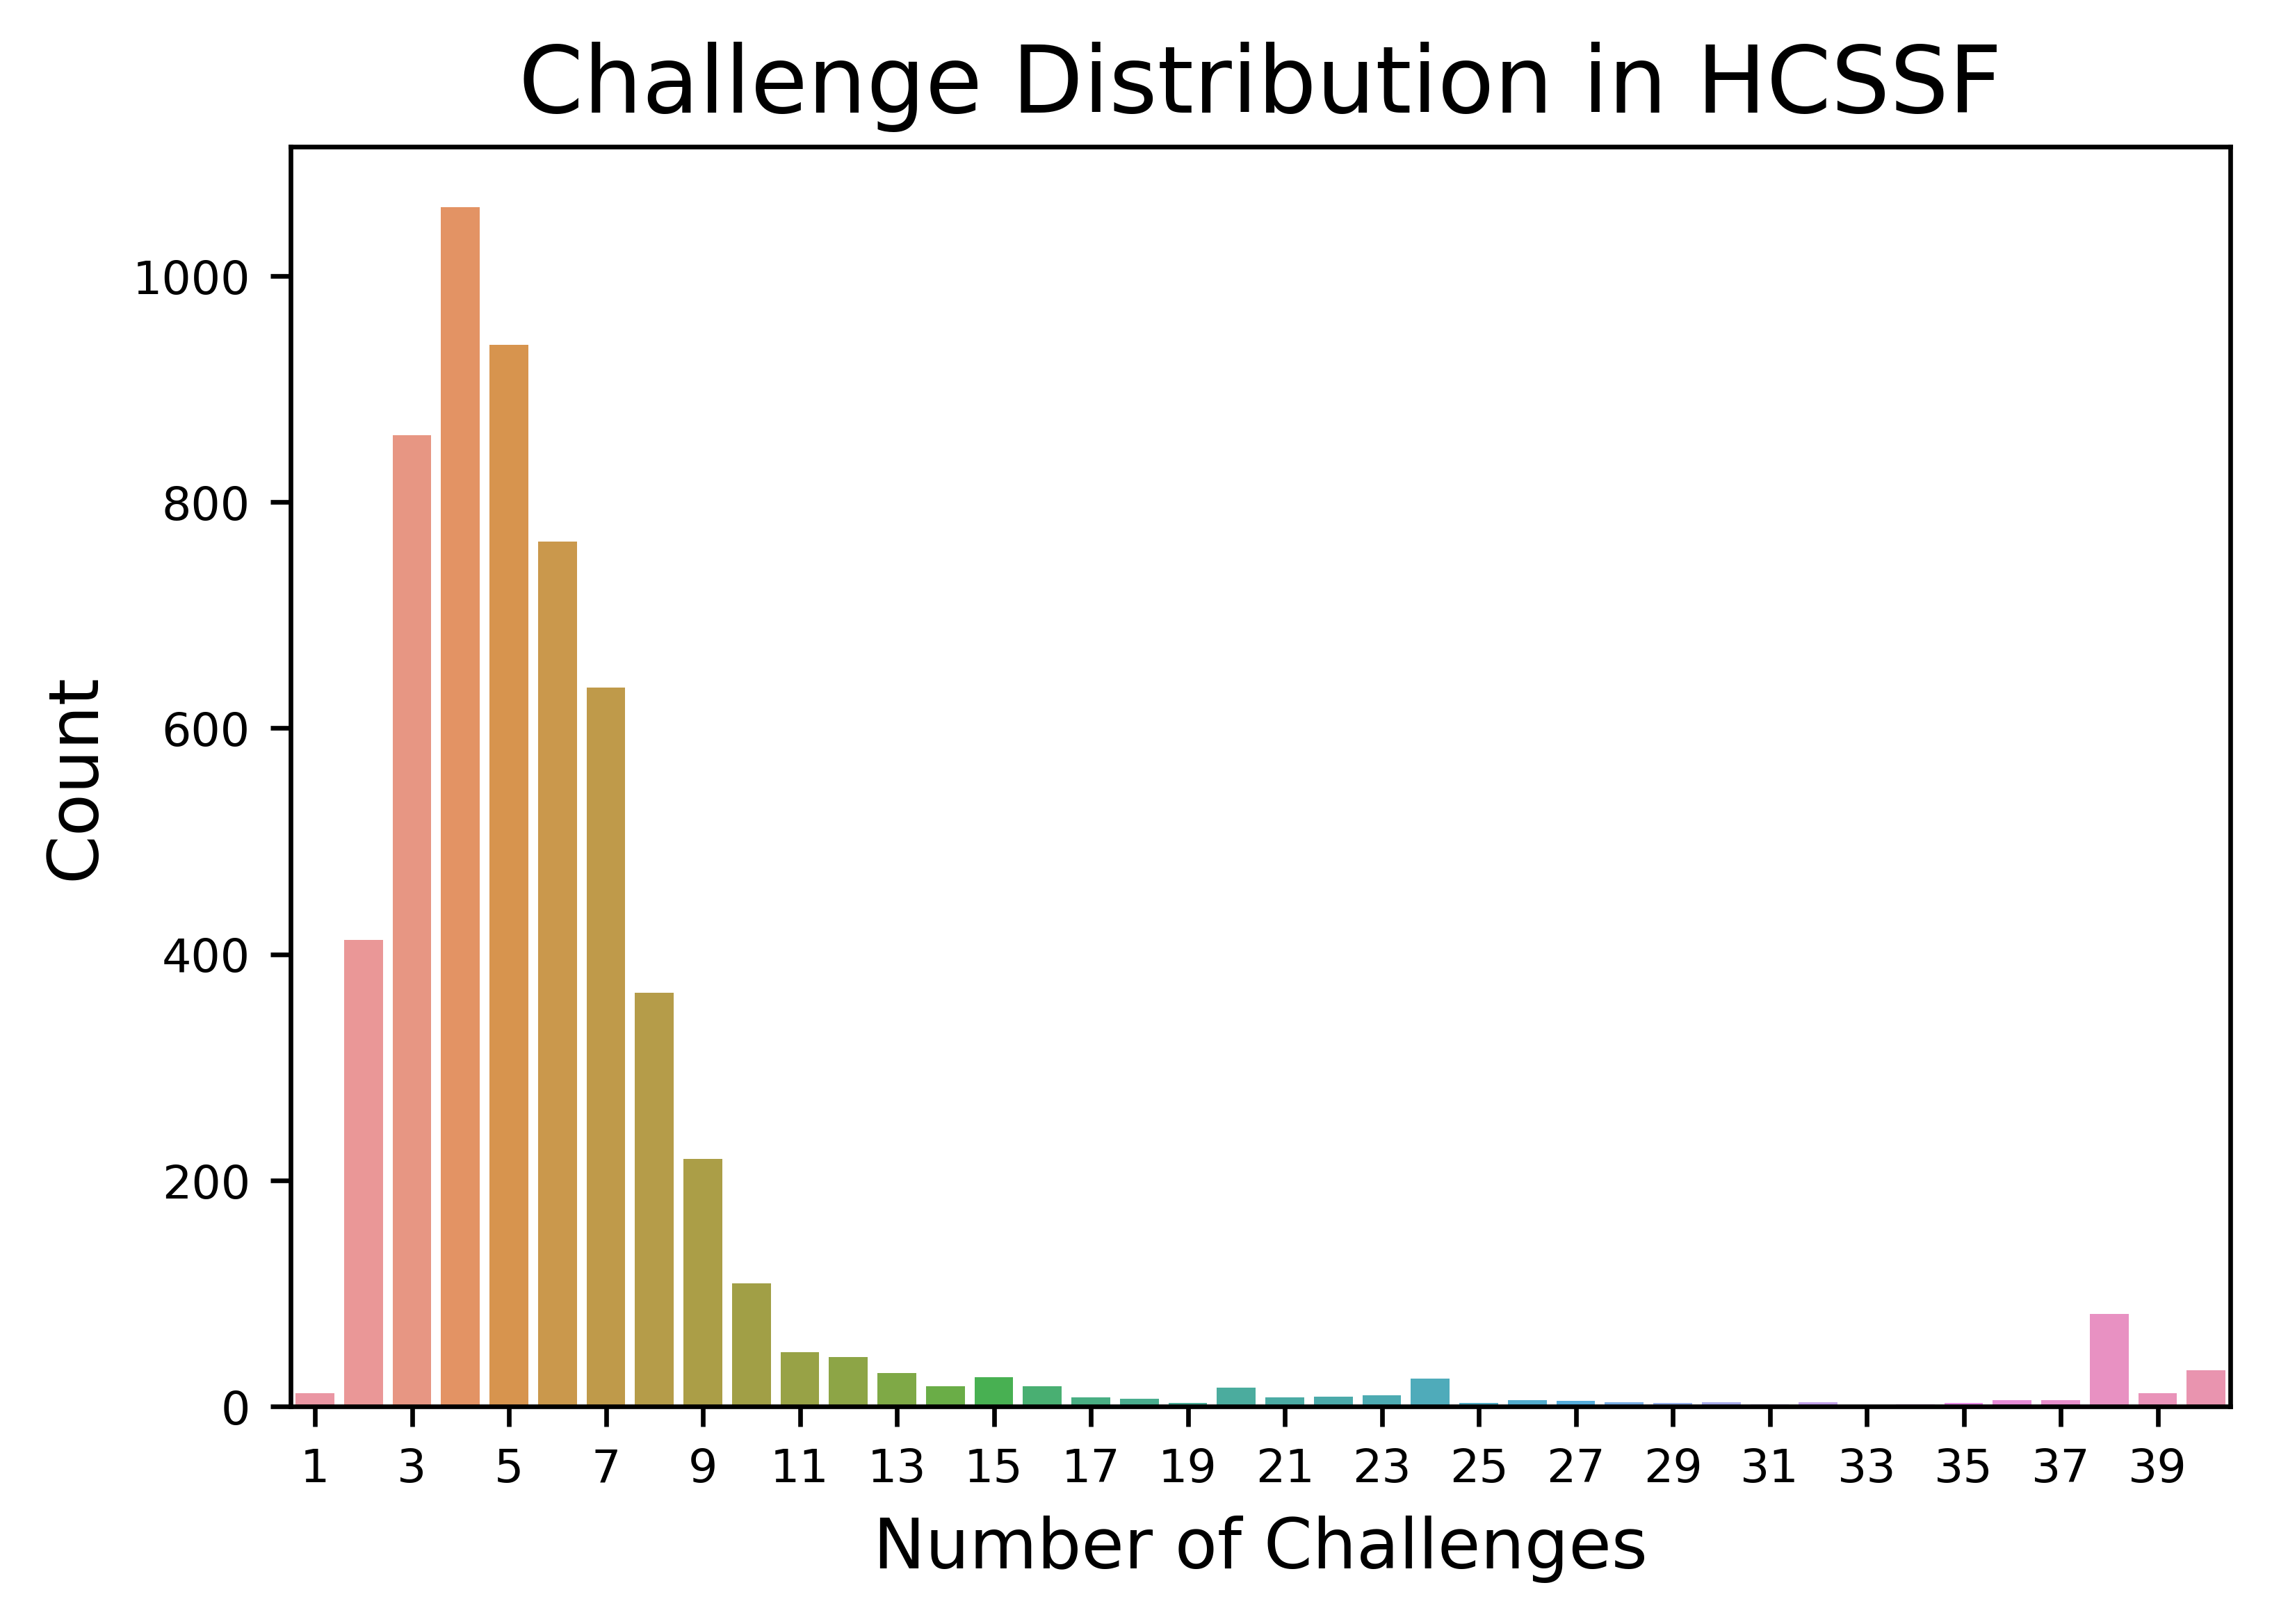

<Figure size 3600x2400 with 0 Axes>

In [43]:
sc_challenge = 'select challenges, count(distinct account_name) as unique_accounts from SC group by challenges'
sc_challenge_df = pd.read_sql_query(sc_challenge,conn)

scssf_challenge = 'select challenges, count(distinct account_name) as unique_accounts from SCSSF group by challenges'
scssf_challenge_df = pd.read_sql_query(scssf_challenge,conn)

hc_challenge = 'select challenges, count(distinct account_name) as unique_accounts from HC group by challenges'
hc_challenge_df = pd.read_sql_query(hc_challenge,conn)

hcssf_challenge = 'select challenges, count(distinct account_name) as unique_accounts from HCSSF group by challenges'
hcssf_challenge_df = pd.read_sql_query(hcssf_challenge,conn)

sc_challenge_graph = sns.barplot(data=sc_challenge_df, x = 'challenges', y= 'unique_accounts')
plt.title(label = 'Challenge Distribution in SC', fontsize = 16)

plt.xlabel('Number of Challenges', fontsize = 12)
plt.xticks(np.arange(0, 40, 2), fontsize = 8)

plt.ylabel('Count', fontsize = 12)
plt.yticks(fontsize = 8)

plt.figure(dpi=600)
plt.tight_layout()

scssf_challenge_graph = sns.barplot(data=scssf_challenge_df, x = 'challenges', y= 'unique_accounts')
plt.title(label = 'Challenge Distribution in SCSSF', fontsize = 16)

plt.xlabel('Number of Challenges', fontsize = 12)
plt.xticks(np.arange(0, 40, 2), fontsize = 8)

plt.ylabel('Count', fontsize = 12)
plt.yticks(fontsize = 8)

plt.figure(dpi=600)
plt.tight_layout()

hc_challenge_graph = sns.barplot(data=hc_challenge_df, x = 'challenges', y= 'unique_accounts')
plt.title(label = 'Challenge Distribution in HC', fontsize = 16)

plt.xlabel('Number of Challenges', fontsize = 12)
plt.xticks(np.arange(0, 40, 2), fontsize = 8)

plt.ylabel('Count', fontsize = 12)
plt.yticks(fontsize = 8)

plt.figure(dpi=600)
plt.tight_layout()

hcssf_challenge_graph = sns.barplot(data=hcssf_challenge_df, x = 'challenges', y= 'unique_accounts')
plt.title(label = 'Challenge Distribution in HCSSF', fontsize = 16)

plt.xlabel('Number of Challenges', fontsize = 12)
plt.xticks(np.arange(0, 40, 2), fontsize = 8)

plt.ylabel('Count', fontsize = 12)
plt.yticks(fontsize = 8)

plt.figure(dpi=600)
plt.tight_layout()

Do SSF players interact more with delve than trade players? Interaction is defined by those who have reached the highest monster level zones, aka depth 145 or higher. 

While a good question, this cannot be queried genuinely due to the 15000 character limit set by the API. 

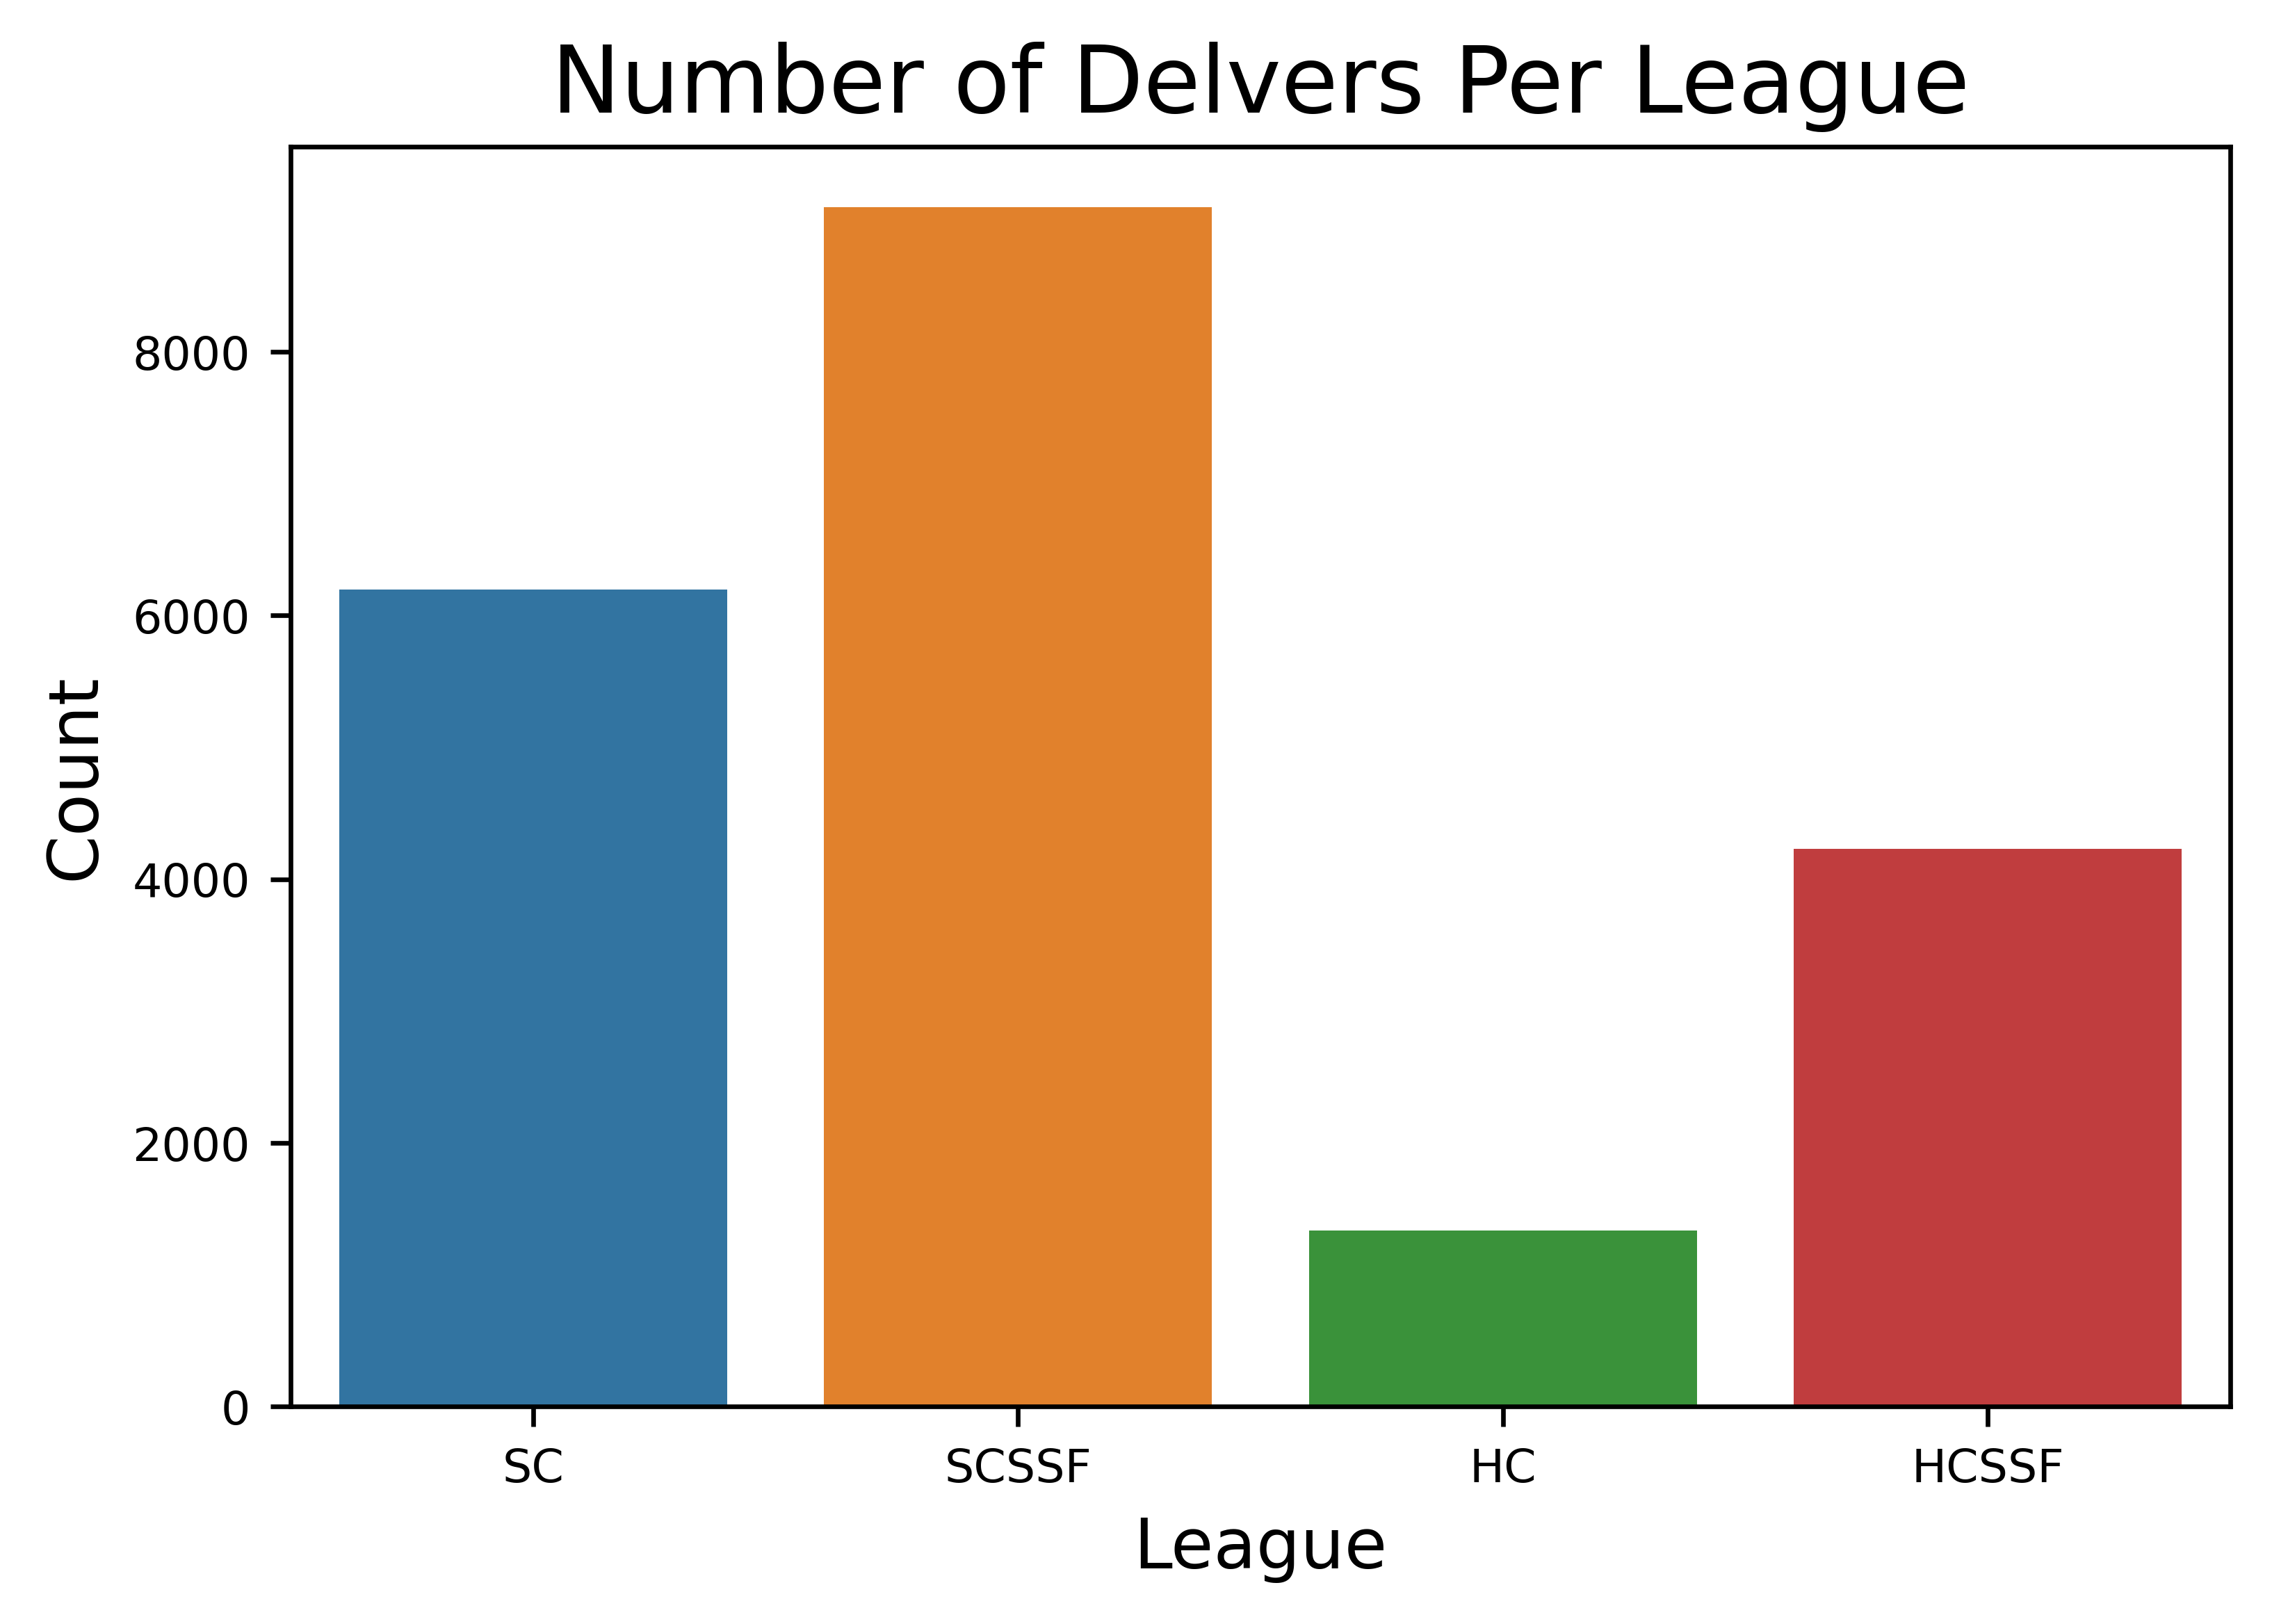

<Figure size 3600x2400 with 0 Axes>

In [44]:
sc_delvers = 'select count(solo_depth) as sc_delvers from sc where solo_depth !=0'
sc_delvers_df = pd.read_sql_query(sc_delvers, conn)

scssf_delvers = 'select count(solo_depth) as scssf_delvers from scssf where solo_depth !=0'
scssf_delvers_df = pd.read_sql_query(scssf_delvers, conn)

hc_delvers = 'select count(solo_depth) as hc_delvers from hc where solo_depth !=0'
hc_delvers_df = pd.read_sql_query(hc_delvers, conn)

hcssf_delvers = 'select count(solo_depth) as hcssf_delvers from hcssf where solo_depth !=0'
hcssf_delvers_df = pd.read_sql_query(hcssf_delvers, conn)

delvers = pd.concat([sc_delvers_df, scssf_delvers_df, hc_delvers_df, hcssf_delvers_df], axis=1)
delvers

delvers_graph = sns.barplot(data=delvers)
plt.title(label = 'Number of Delvers Per League', fontsize = 16)

plt.xlabel('League', fontsize = 12)
plt.xticks(ticks = [0,1,2,3], labels = ['SC','SCSSF','HC','HCSSF'], fontsize = 8)

plt.ylabel('Count', fontsize = 12)
plt.yticks(fontsize = 8)

plt.figure(dpi=600)
plt.tight_layout()

What ascendancies have delved the deepest in SC trade? HCSSF?

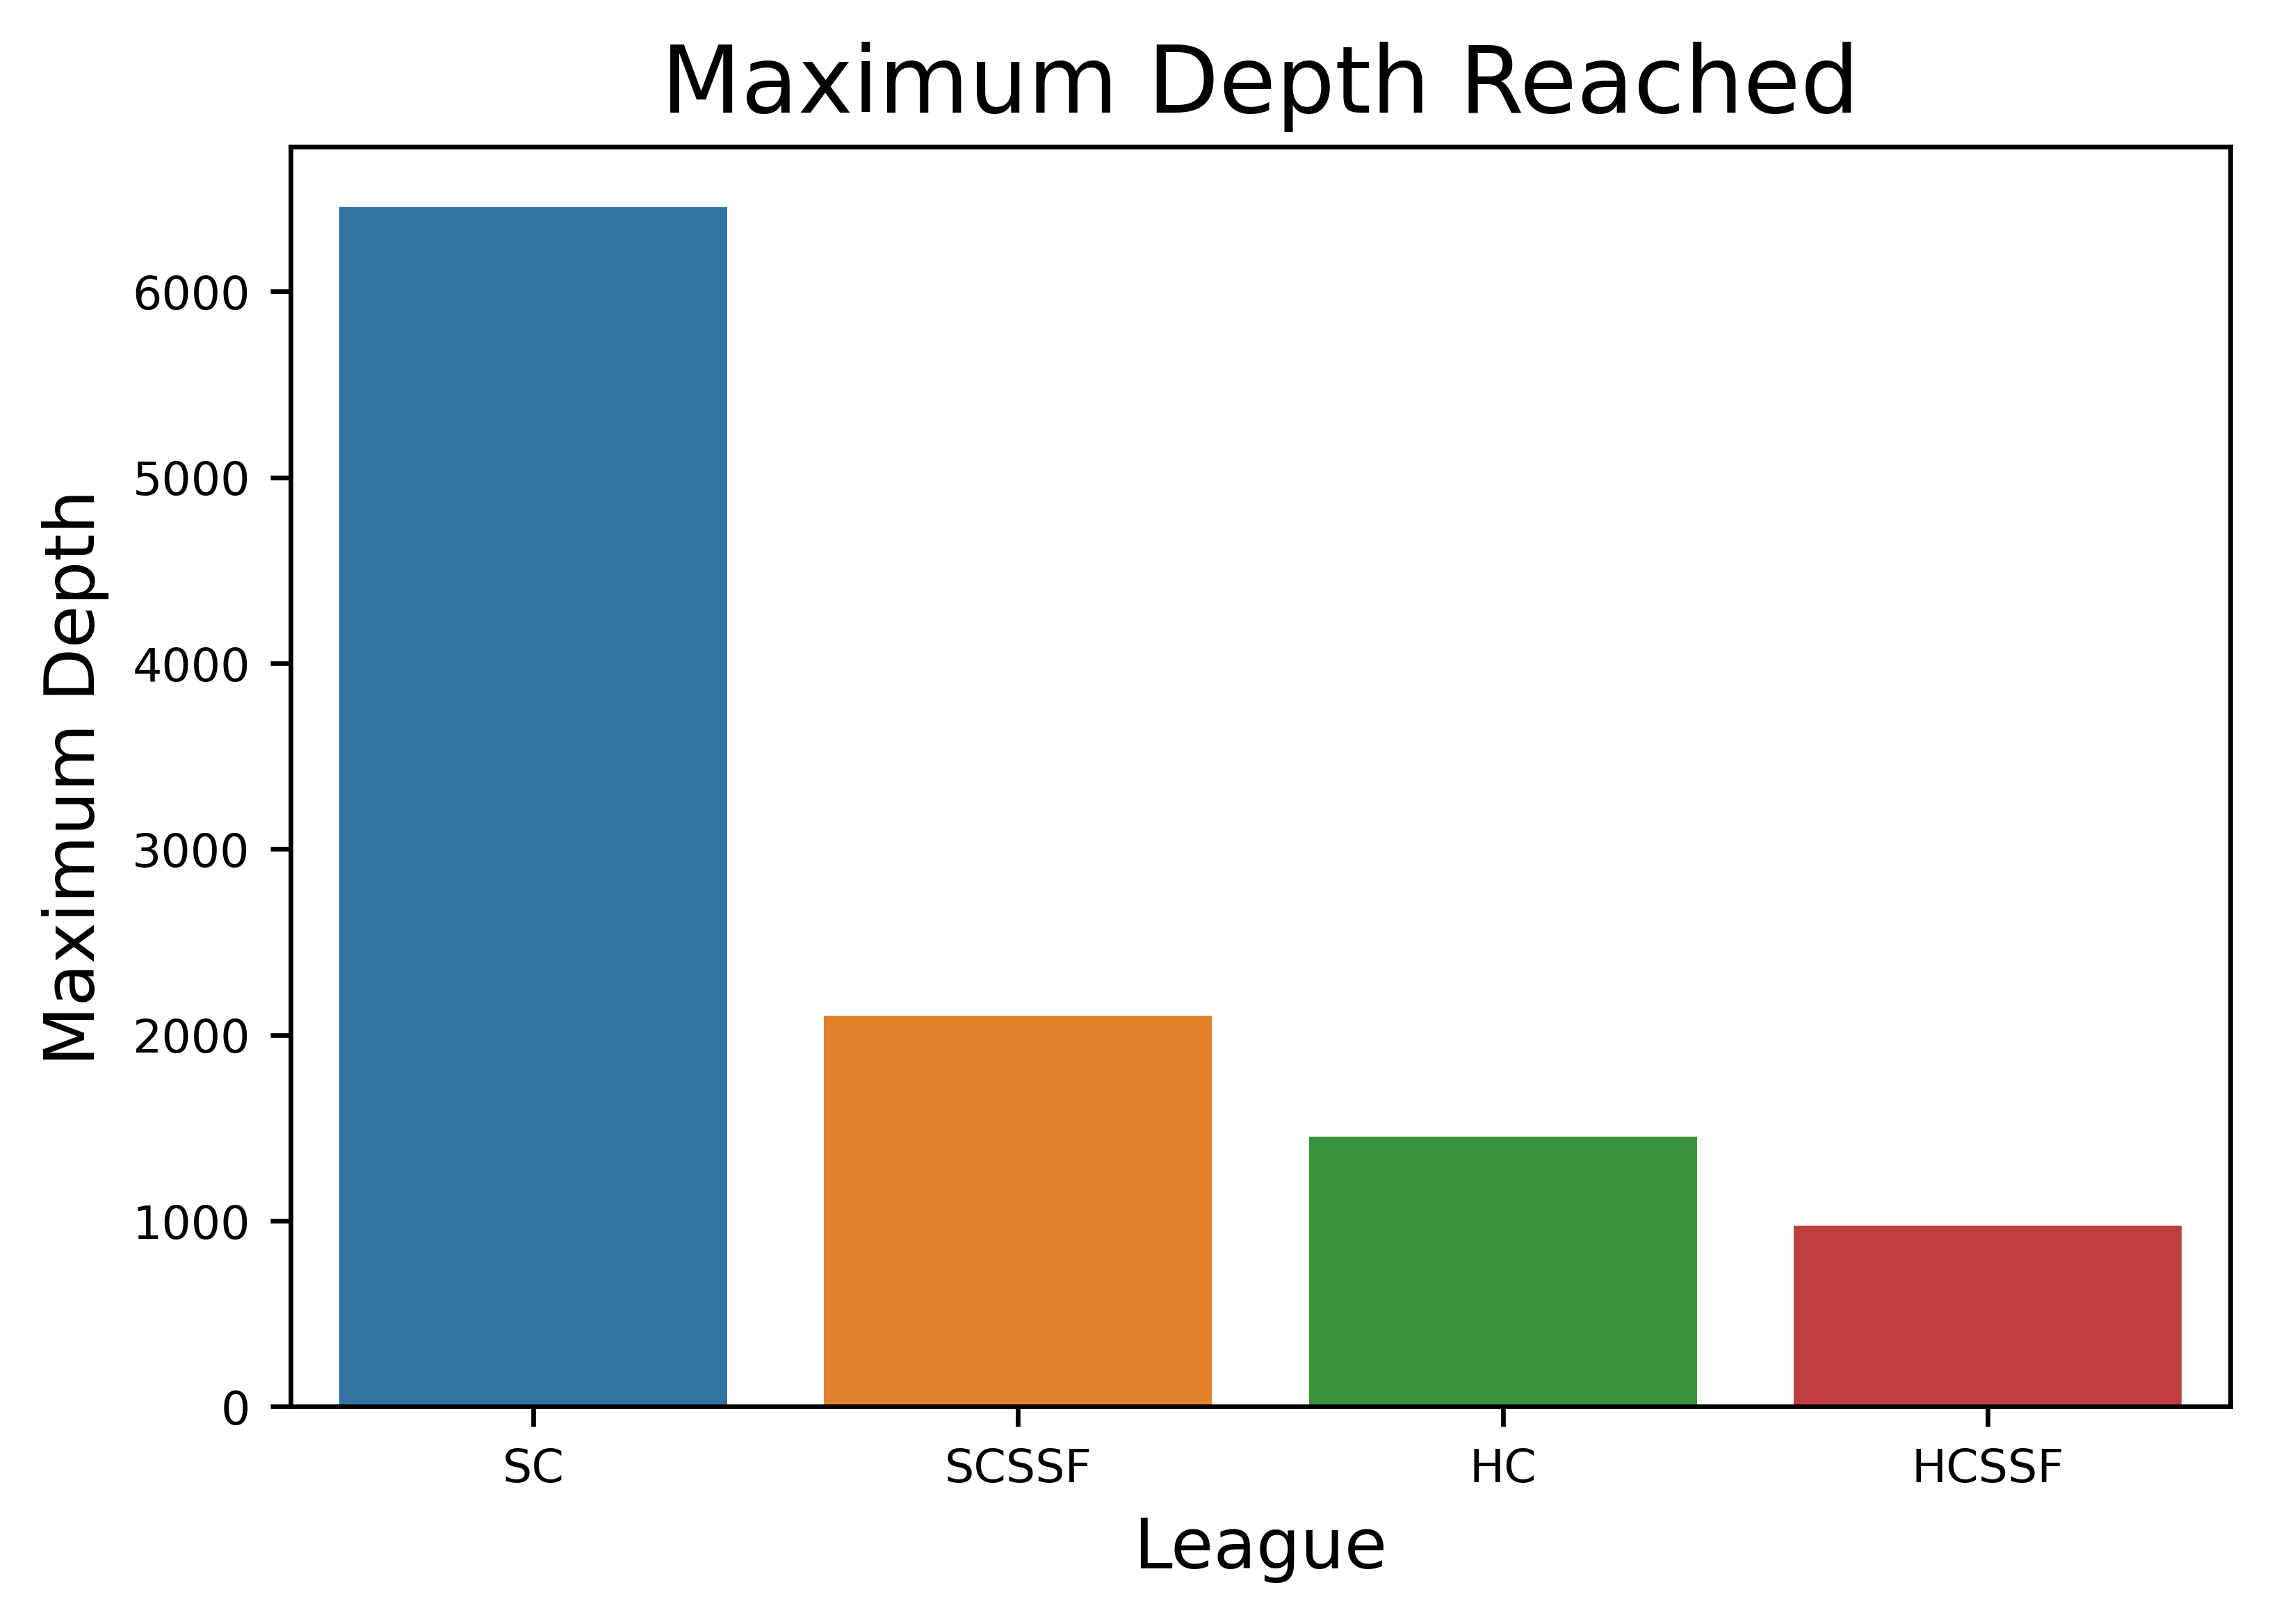

<Figure size 3600x2400 with 0 Axes>

In [46]:
sc_maxdepth = 'select max(solo_depth) as max_SC_depth from sc'
sc_maxdepth_df = pd.read_sql_query(sc_maxdepth, conn)

scssf_maxdepth = 'select max(solo_depth) as max_SCSSF_depth from scssf'
scssf_maxdepth_df = pd.read_sql_query(scssf_maxdepth, conn)

hc_maxdepth = 'select max(solo_depth) as max_HC_depth from hc'
hc_maxdepth_df = pd.read_sql_query(hc_maxdepth, conn)

hcssf_maxdepth = 'select max(solo_depth) as max_HCSSF_depth from hcssf'
hcssf_maxdepth_df = pd.read_sql_query(hcssf_maxdepth, conn)

maxdepth = pd.concat([sc_maxdepth_df, scssf_maxdepth_df, hc_maxdepth_df, hcssf_maxdepth_df], axis=1)

max_depth_graph = sns.barplot(data=maxdepth)
plt.title(label = 'Maximum Depth Reached', fontsize = 16)

plt.xlabel('League', fontsize = 12)
plt.xticks(ticks = [0,1,2,3], labels = ['SC','SCSSF','HC','HCSSF'], fontsize = 8)

plt.ylabel('Maximum Depth', fontsize = 12)
plt.yticks(fontsize = 8)

plt.figure(dpi=600)
plt.tight_layout()

In each of the 4 leagues, where do most people end up at their max_depth? 

A lot of people on the ladder have delved specifically to depth 600 for a challenge ...where do the rest end up?

In [47]:
sc_depth_count = 'select solo_depth, count(solo_depth) as sc_max_depth_count from sc where solo_depth!=0 group by solo_depth'
sc_depth_count_df = pd.read_sql_query(sc_depth_count, conn)

scssf_depth_count = 'select solo_depth, count(solo_depth) as scssf_max_depth_count from scssf where solo_depth!=0 group by solo_depth'
scssf_depth_count_df = pd.read_sql_query(scssf_depth_count, conn)

hc_depth_count = 'select solo_depth, count(solo_depth) as hc_max_depth_count from hc where solo_depth!=0 group by solo_depth'
hc_depth_count_df = pd.read_sql_query(hc_depth_count, conn)

hcssf_depth_count = 'select solo_depth, count(solo_depth) as hcssf_max_depth_count from hcssf where solo_depth!=0 group by solo_depth'
hcssf_depth_count_df = pd.read_sql_query(hcssf_depth_count, conn)


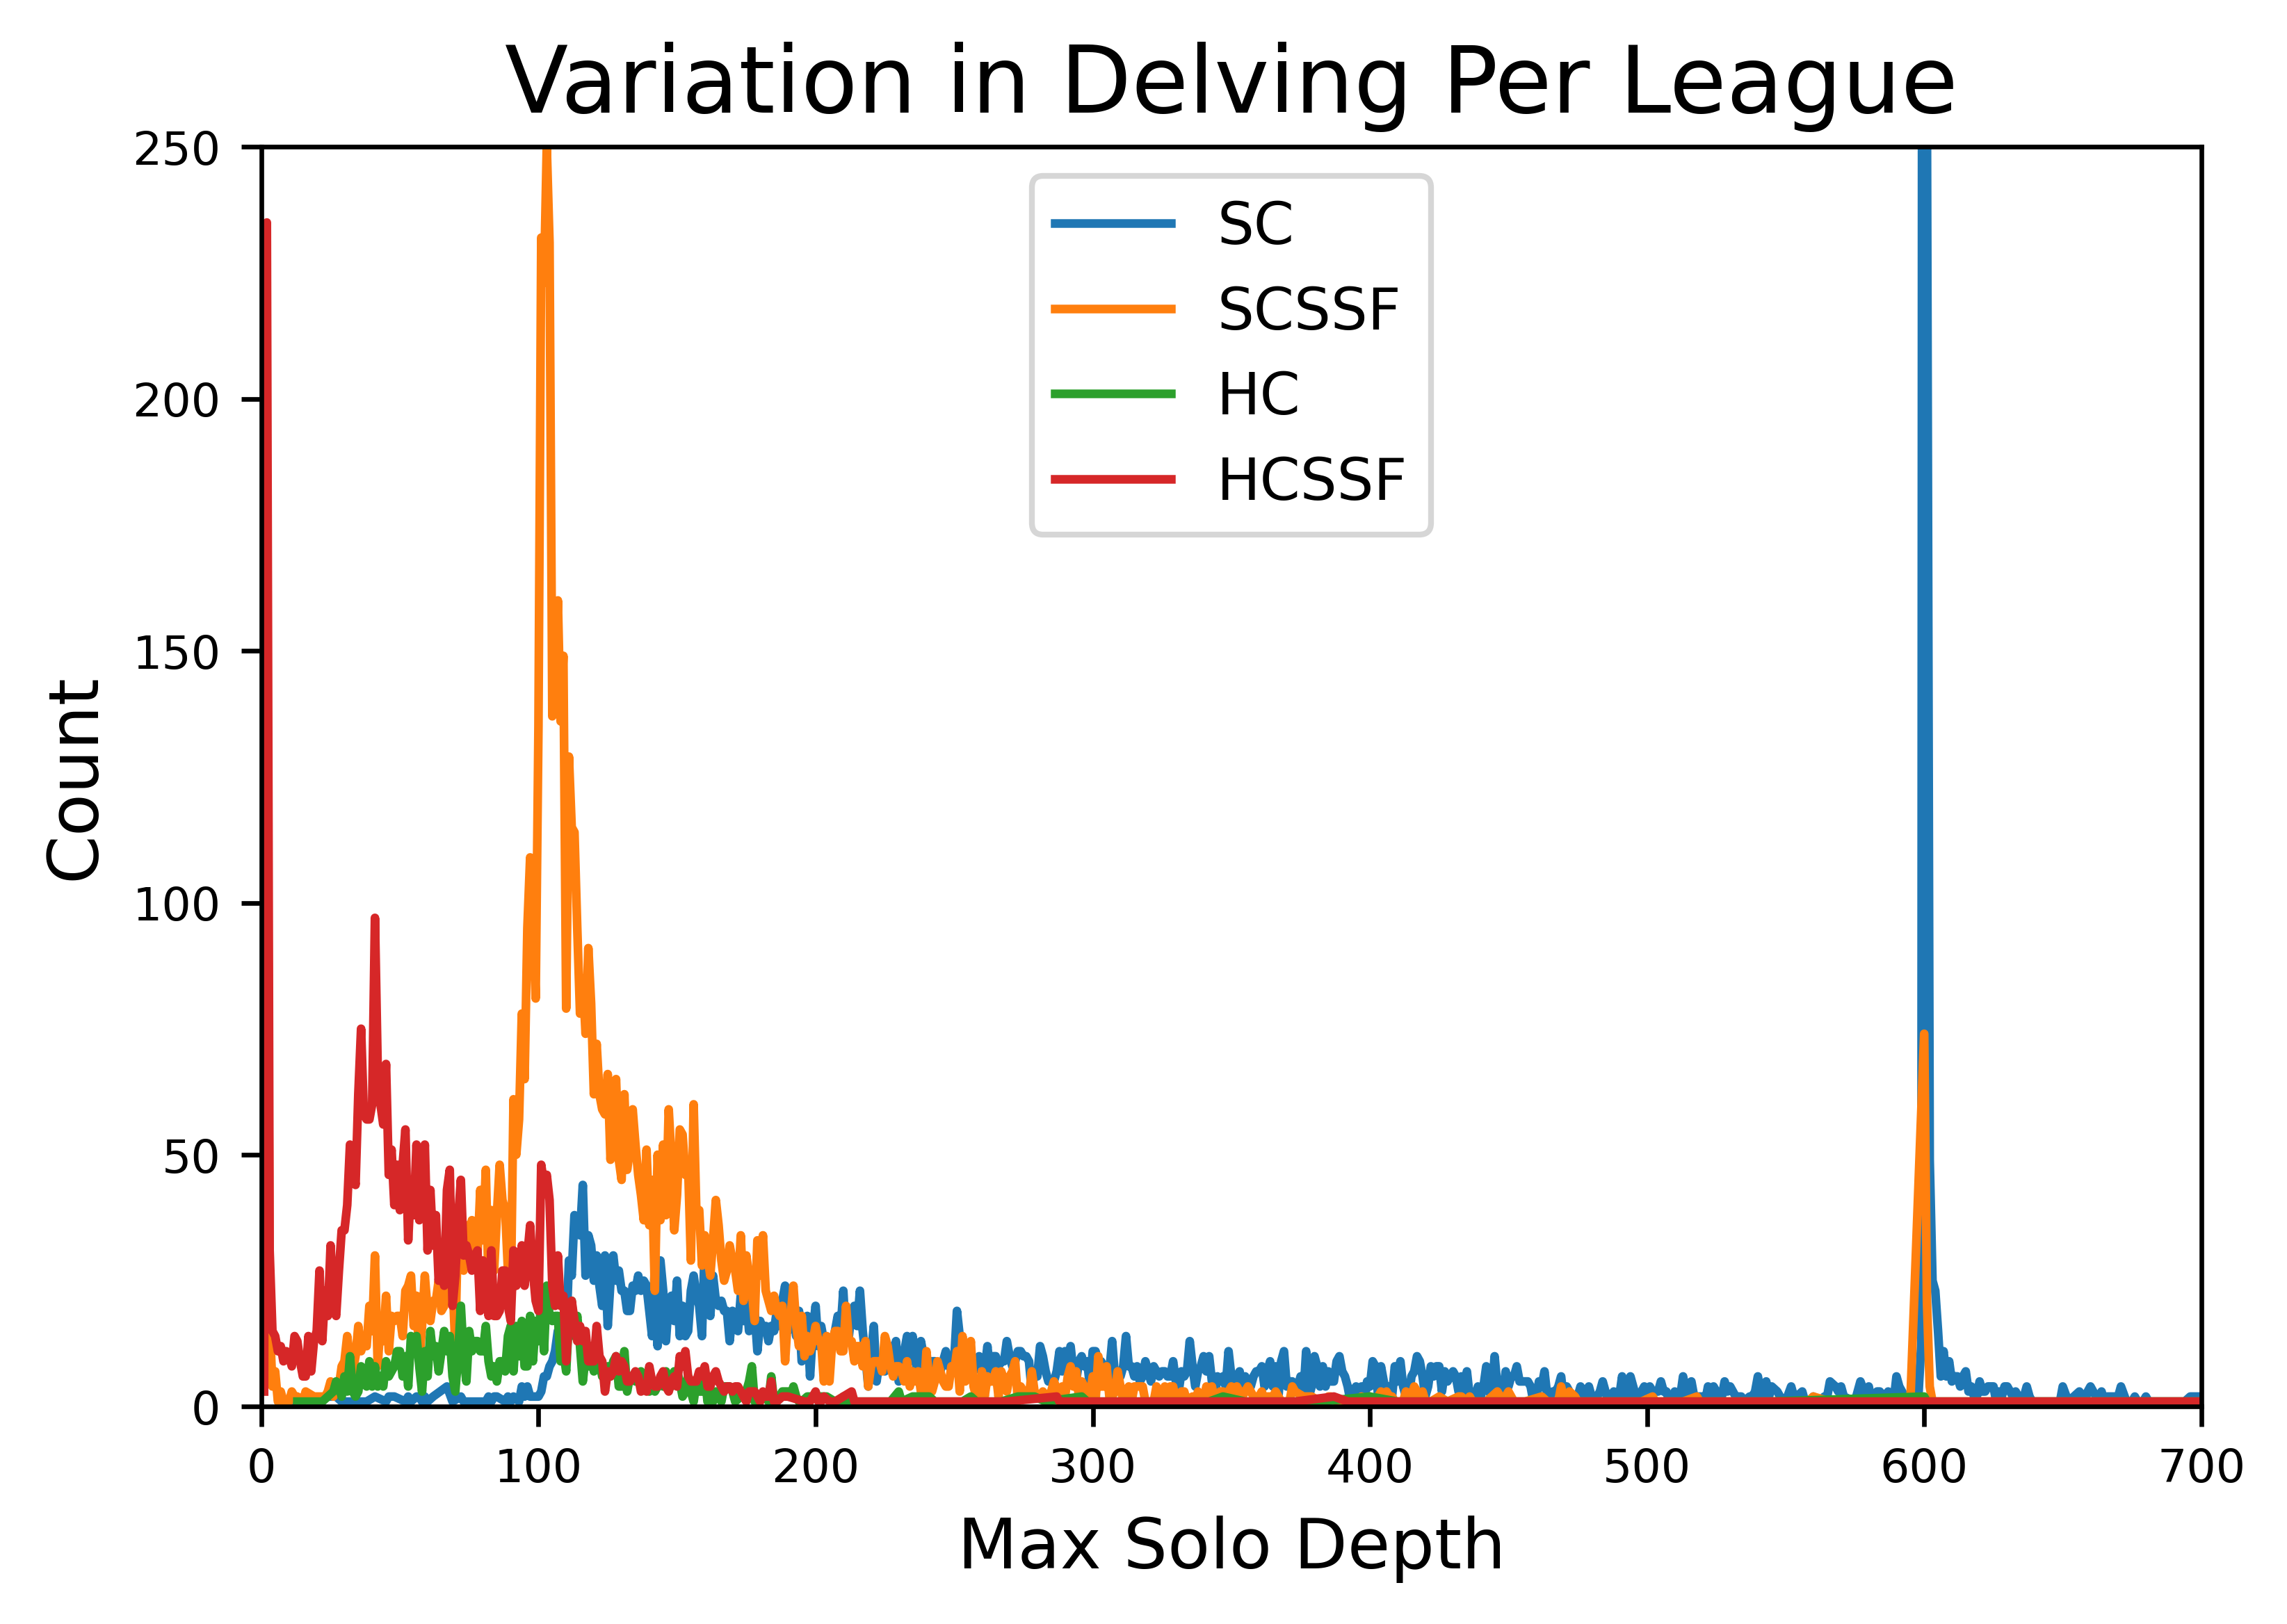

<Figure size 3600x2400 with 0 Axes>

In [51]:
sc_depth_graph = sns.lineplot(data=sc_depth_count_df, x='solo_depth',y='sc_max_depth_count', label='SC')
scssf_depth_graph = sns.lineplot(data=scssf_depth_count_df, x='solo_depth',y='scssf_max_depth_count', label = 'SCSSF')
hc_depth_graph = sns.lineplot(data=hc_depth_count_df, x='solo_depth',y='hc_max_depth_count', label = 'HC')
hcssf_depth_graph = sns.lineplot(data=hcssf_depth_count_df, x='solo_depth',y='hcssf_max_depth_count', label = 'HCSSF')
plt.title(label = 'Variation in Delving Per League', fontsize = 16)

plt.xlabel('Max Solo Depth', fontsize = 12)
plt.xticks(fontsize = 8)
plt.xlim(0,700)

plt.ylabel('Count', fontsize = 12)
plt.yticks(fontsize = 8)
plt.ylim(0,250)

plt.figure(dpi=600)
plt.tight_layout()

Another way to look at this data might be to analyze the variance of delving in the league.

In [49]:
sc_delver_stats = 'select solo_depth as sc_delver_stats from sc where solo_depth!=0'
sc_delver_stats_df = pd.read_sql_query(sc_delver_stats, conn)

scssf_delver_stats = 'select solo_depth as scssf_delver_stats from scssf where solo_depth!=0'
scssf_delver_stats_df = pd.read_sql_query(scssf_delver_stats, conn)

hc_delver_stats = 'select solo_depth as hc_delver_stats from hc where solo_depth!=0'
hc_delver_stats_df = pd.read_sql_query(hc_delver_stats, conn)

hcssf_delver_stats = 'select solo_depth as hcssf_delver_stats from hcssf where solo_depth!=0'
hcssf_delver_stats_df = pd.read_sql_query(hcssf_delver_stats, conn)

delver_stats = pd.concat([sc_delver_stats_df, scssf_delver_stats_df, hc_delver_stats_df, hcssf_delver_stats_df], axis =1)

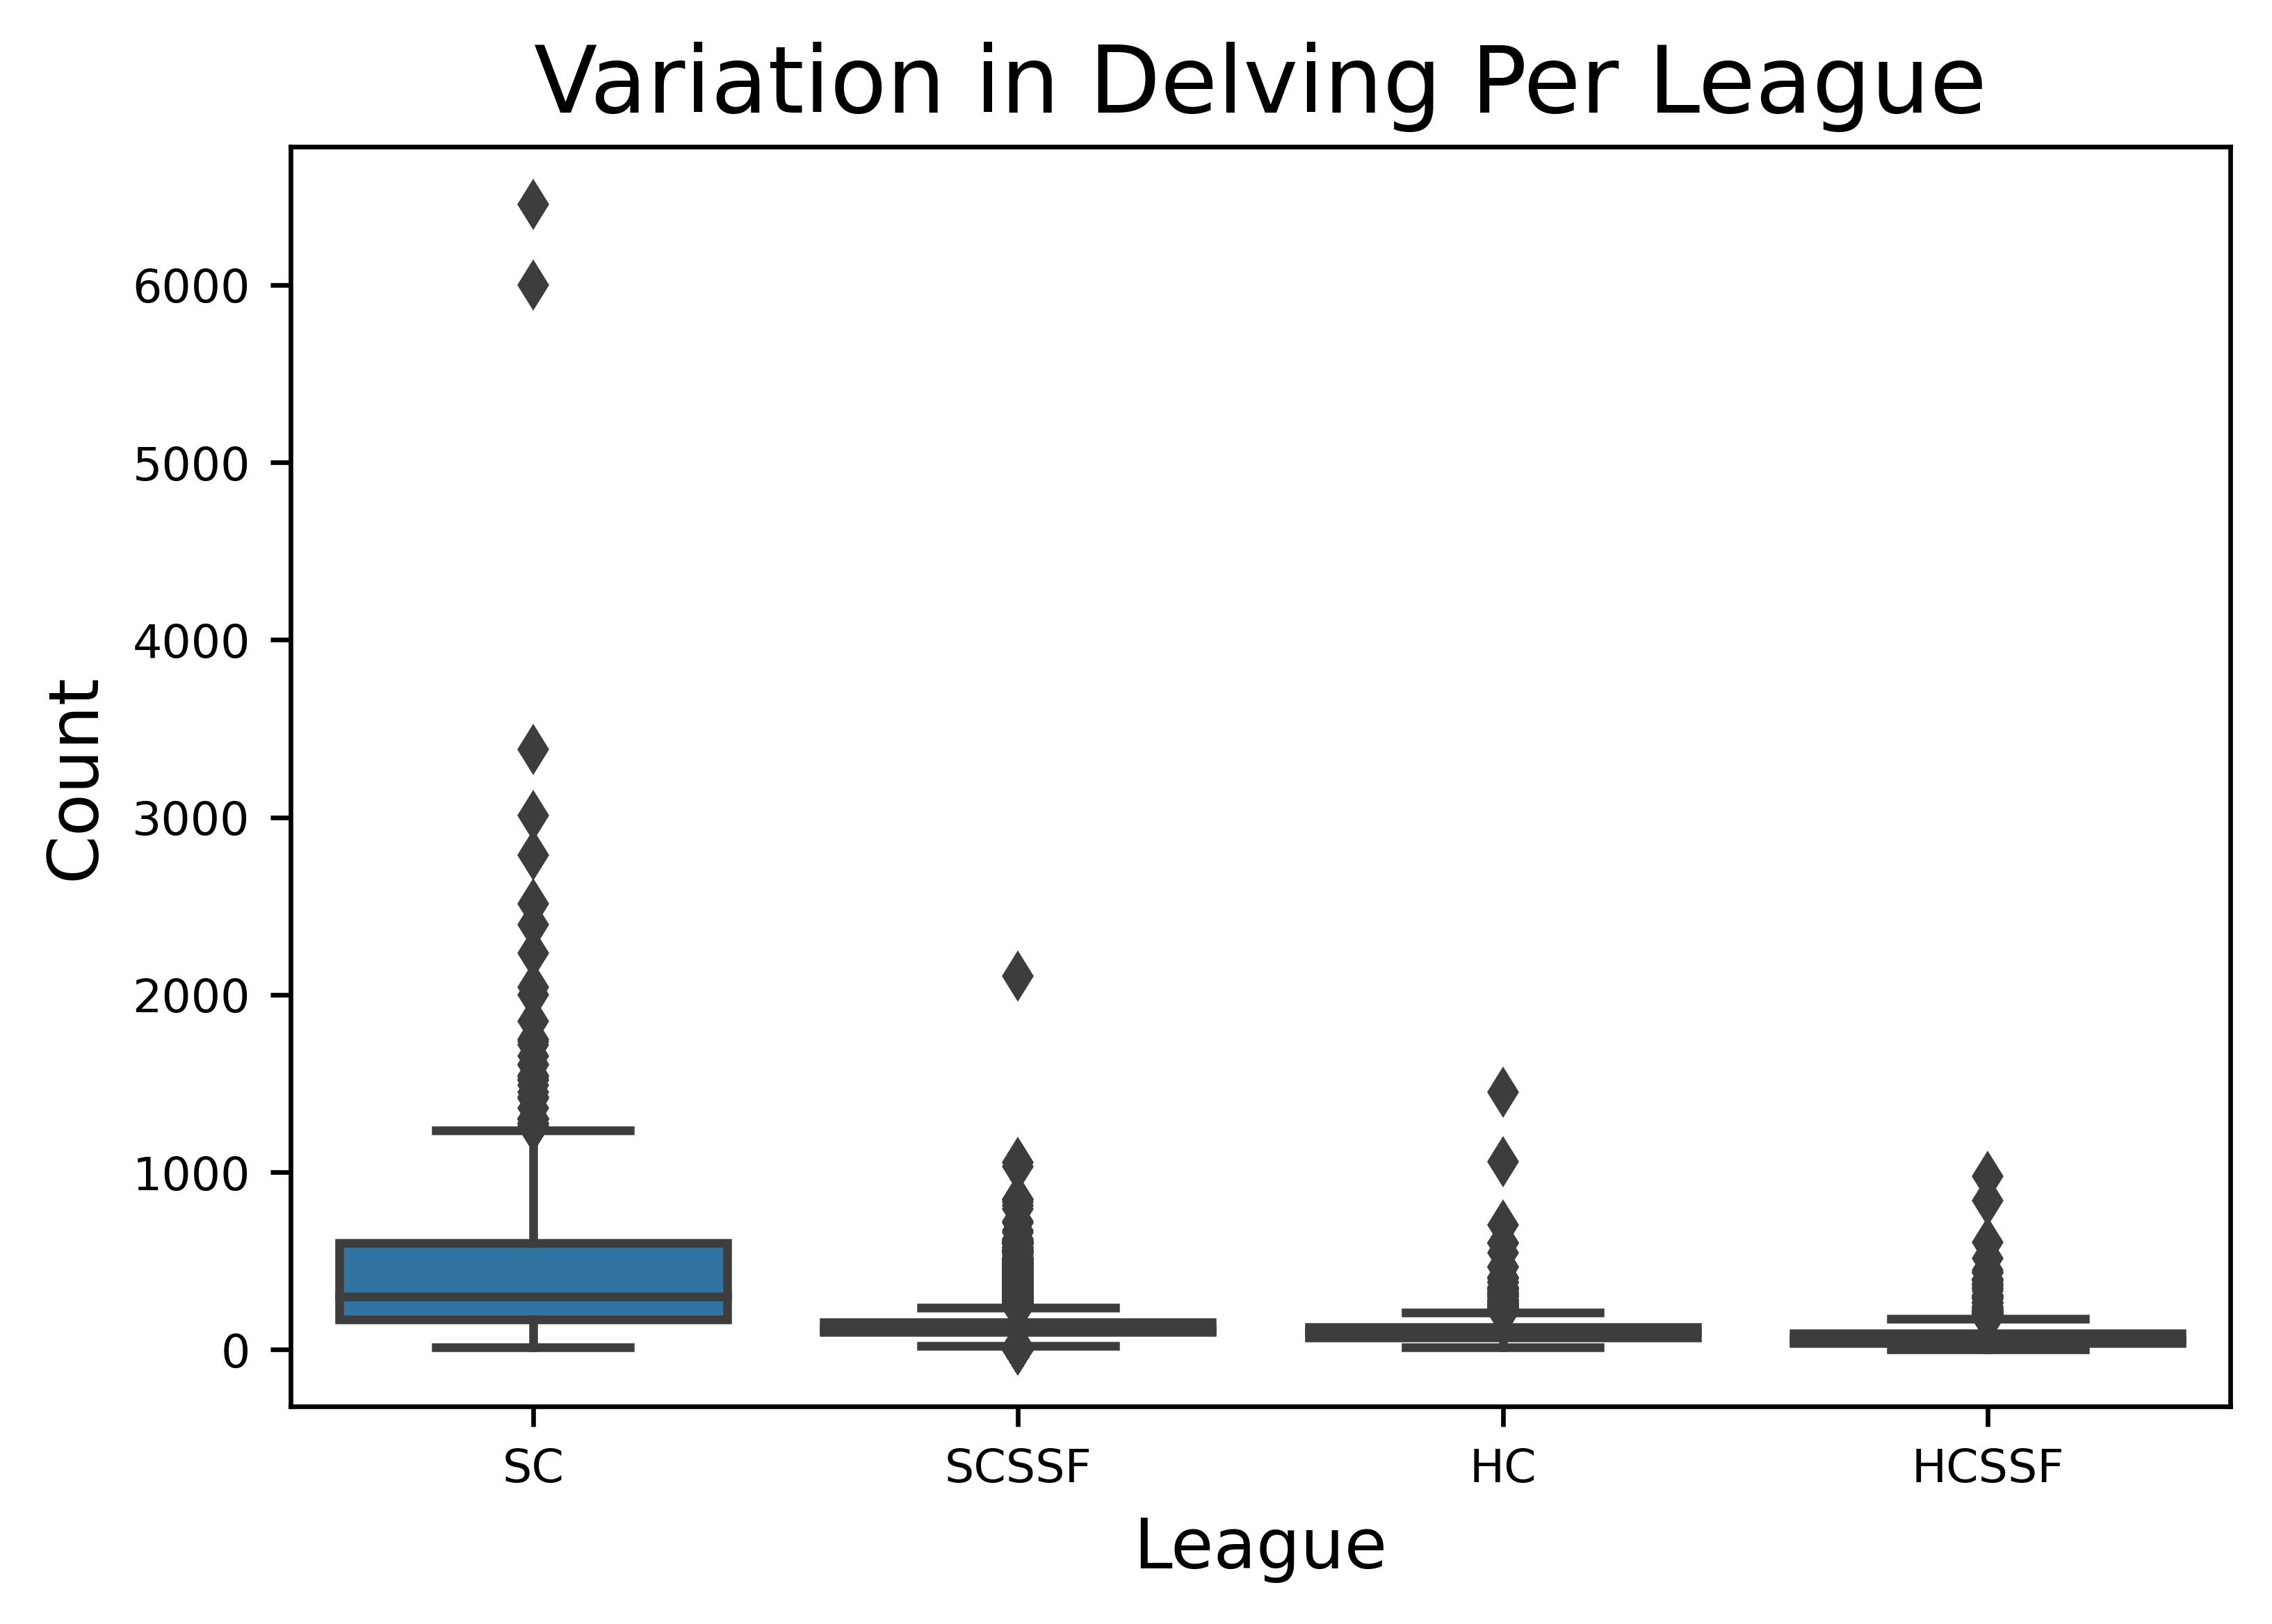

<Figure size 3600x2400 with 0 Axes>

In [52]:
sns.boxplot(data=delver_stats)
plt.title(label = 'Variation in Delving Per League', fontsize = 16)

plt.xlabel('League', fontsize = 12)
plt.xticks(ticks = [0,1,2,3], labels = ['SC','SCSSF','HC','HCSSF'], fontsize = 8)

plt.ylabel('Count', fontsize = 12)
plt.yticks(fontsize = 8)

plt.figure(dpi=600)
plt.tight_layout()